# Non Muscle Invasive Bladder Cancer (NMIBC) - Moffitt Cancer Center

In [115]:
library(ggplot2)
library(tidyverse)
library(ComplexHeatmap)
library(maftools)
library(RColorBrewer)
library(readxl)
library(stats)
library(pROC)
library(stringr)
#source("~/Desktop/puffin/R/helper_functions.R")
source("~/Desktop/Predicine/helper_functions.R")

# set some defaults
options(stringsAsFactors = FALSE)
options(repr.matrix.max.cols=75, repr.matrix.max.rows=50)
formals(table)$useNA <- "always"

print(Sys.time())
print(sessionInfo())

[1] "2024-06-18 10:06:18 PDT"
R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 14.4.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] eulerr_7.0.0          ggsignif_0.6.4        glue_1.7.0           
 [4] pROC_1.18.4           readxl_1.4.3          RColorBrewer_1.1-3   
 [7] maftools_2.16.0       ComplexHeatmap_2.16.0 lubridate_1.9.2      
[10] forcats_1.0.0         stringr_1.5.1         dplyr_1.1.4          
[13] purrr_1.0.2           readr_2.1.4           tidyr_1.3.1          
[16] tibble_3.2

In [116]:
## functions for harmonizing input sheets
source("../fix_PIDs.R")

fix_sampleTypes <- function(col){
  print(table(col, useNA="always"))
  col.new <- tolower(col)
  col.new <- gsub("ffpe", "tissue", col.new)
  col.new <- gsub("urine_supernatant|supernatant", "urine", col.new) 
  col.new <- gsub("pbmc|buffycoat", "buffy_coat", col.new)
  print(table(col.new, useNA="always"))
  return(col.new)
}

fix_StudyVisit <- function(col){
    warn_na(col)
    col.new <- sapply(str_split(col, pattern="_"), "[", 2)
    return(col.new)
}

In [117]:
# read in clinical data

df_clin.new = read.csv("clinical_data/NMIBC_clinical_data_merged_2024-04-16_BG_JL.csv")
#df_clin.new = read_excel("clinical_data/NMIBC_clinical_data_JL_Jan232024.xlsx", sheet = "Sheet1", n_max = 99, skip = 2)
df_clin.new = make_names(df_clin.new) %>% mutate(#disease.positive = factor(Repeat.Tumor > 0),
                                                PatientID = as.character(fix_PIDs(PatientID))) #%>% 
                                          #filter(PatientID != "0")
table(df_clin.new$PatientID)
sort(names(df_clin.new))
#df_clin = read.csv("./clinical_data//NMIBC_clinical_data_merged_2023-10-11.csv", as.is=T)
#df_clin = df_clin %>% mutate(PatientID.old=PatientID,
#                             PatientID = as.character(fix_PIDs(PatientID)))
#table(df_clin$PatientID)
#df_clin = df_clin.new %>% left_join(df_clin %>% select(-disease.positive), by="PatientID")
#table(df_clin$PatientID)

# df_clin = read_excel("./data_batch1_and_2/NMIBC Clinical for BG 10.19.22 (1).xlsx",
#                     sheet = "CtutDNAInNMIBC_DATA_LABELS_2022")
# df_clin = df_clin %>% rename("Record"="Record ID...1",
#                              "PatientID"="Study ID (Ex. NMIBC-***)",
#                              "has.IndexTURBT"="What was sent to Predicine (choice=Index TURBT Tissue)",
#                              "has.BloodPre"="What was sent to Predicine (choice=Pre-Repeat TURBT Blood)",
#                              "has.UrinePre"="What was sent to Predicine (choice=Pre-Repeat TURBT Urine)",
#                              "has.RepeatTURBT"="What was sent to Predicine (choice=Repeat TURBT Tissue)",
#                              "has.UrinePostop1A"="What was sent to Predicine (choice=Post-Op Urine)",
#                              "has.UrinePostop1B"="What was sent to Predicine (choice=Surveillance 1 Urine)",
#                              "has.UrinePostop2"="What was sent to Predicine (choice=Surveillance 2 Urine)",
#                              "has.UrinePostop3"="What was sent to Predicine (choice=Surveillance 3 Urine)",
#                              "has.UrinePostop4"="What was sent to Predicine (choice=Surveillance 4 Urine)",
#                              "Progression"="NMIBC Progression? (ex. TaLG to TaHG; TaHG to T1)",
#                              "Index.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...34",
#                              "IndexHistology"="Primary Histology...30",
#                              "Index.Stage"="PT STAGE...32",
#                              "IndexGrade"="Grade...33",
#                              "RepeatHistology"="Primary Histology...38",
#                              "Repeat.Stage"="PT STAGE...40",
#                              "RepeatGrade"="Grade...41",
#                              "Repeat.CIS"="Is CIS also present? (only yes if primary histology is not Tis)...42",
#                              "CytoscopyDate"="Date of Surveillance Cystoscopy (most recent if no recurrence; if there is recurrence, date of cysto that detected the recurrence)",
#                              "Smoking.Status"="Smoking status") %>%
#                         mutate_at(c("Repeat.Stage", "Index.Stage", "Progression", "IndexHistology", "IndexGrade",
#                                       "RepeatHistology", "RepeatGrade", "Repeat.CIS", "CytoscopyDate"), as.character)
# df = df_clin.new %>% select("PatientID", "Previous.Intravesical.Therapy..choice.None.",
#                         "Previous.Intravesical.Therapy..choice.BCG.",
#                         "Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.",
#                         "Previous.Intravesical.Therapy..choice.Mitomycin.C.") %>%
#                 rename("None"="Previous.Intravesical.Therapy..choice.None.",
#                         "BCG"="Previous.Intravesical.Therapy..choice.BCG.",
#                         "Mitomycin.C"="Previous.Intravesical.Therapy..choice.Mitomycin.C.",
#                        "Gemcitabine.Docetaxel"="Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.") %>%
#                  pivot_longer(-PatientID, names_to="Prev.IV.Therapy") %>% filter(value=="Yes") %>% select(-value)
# df_clin.new = df_clin.new %>% left_join(df, by="PatientID") #%>% 
#                 #mutate(Prev.IV.Therapy = ifelse(is.na(Prev.IV.Therapy), )) # not sure if NA=="None" here . .. 
# table(df_clin.new$Prev.IV.Therapy)

# # add batch 3 data
# df_clin_3 = read_excel("./data_batch3_02222023/Batch3_NMIBC Index Repeat Path for Billie_05082023.xlsx",skip = 1,
#                       sheet=1,)
# names(df_clin_3) <- c("PatientID","Index.Stage","Repeat.Stage","ExternalSampleID.repeat")
# df_clin_3 = df_clin_3 %>% filter(PatientID %!in% c("173334","172229")) # this info a duplicate of NMIBC013 and NMIBC003 in batch 1 sheet
# df_clin = plyr::rbind.fill(df_clin, df_clin_3)
# df_clin[df_clin$PatientID == "NMIBC013", "Index.Stage"] <- "T1HG"  # use stage info from batch3 sheet
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Index.Stage"] <- "T1HG (Squamous)"
# df_clin[df_clin$PatientID == "NMIBC003/MIBC021", "Repeat.Stage"] <- "T1HG (Squamous)"
# stopifnot(all(!duplicated(df_clin$PatientID)))
# ###
# df_clin = df_clin %>% mutate("disease.positive" = ifelse(Repeat.Stage!="T0",TRUE,FALSE),
#                             "Index.CIS" = grepl("cis", Index.Stage, ignore.case=T),
#                             "Repeat.CIS" = grepl("cis", Repeat.Stage, ignore.case=T))
# # dual label patients
# # patient notes:
#     # 165028 >> progressed to MIBC, use for detailed case study. see text file: Case_study_165028_details_06022023.txt
#     # "173983"="NMIBC035", # progressed to MIBC (=MIBC060), sending new samples 5/31
#     # "172229"="NMIBC003/MIBC021", # repeat sent with batch 1
#     # "173334"="NMIBC013", # index sent with batch 1, repeat with batch 3
#     # analyzed as part of the MIBC cohort:
#     # "175827"="NMIBC-066/MIBC-073", 
#     # "171126"="NMIBC-062/MIBC-071",
#     # "175743" = NMIBC-053/MIBC-069"
#     # "175702" = NMIBC-052/MIBC-068"

# from Josh Aug 2023 - recur data for ASCOGU patients
# df_clin2 = read.csv("./clinical_data/NMIBC_clinical_data_merged_missing_2023-09_06.csv") %>% 
#     filter(PatientID %!in% df_clin$PatientID)
# df_clin = rbind.common(df_clin, df_clin2)

stopifnot(all(!duplicated(df_clin.new$PatientID)))
nrow(df_clin.new)
#write.csv(df_clin, glue("./NMIBC_clinical_data_merged_{Sys.Date()}.csv"), row.names=F)
head(df_clin.new) #96 patients

 [1] "76224"  "116381" "152237" "161922" "165028" "167162" "169558" "171374"
 [9] "171769" "171821" "172153" "172229" "172530" "172586" "172602" "172749"
[17] "172851" "173075" "173254" "173281" "173334" "173350" "173359" "173362"
[25] "173509" "173743" "173912" "173975" "173983" "174083" "174091" "174872"
[33] "174947" "175325" "175387" "175425" "175492" "175526" "175610" "175648"
[41] "175672" "175725" "175733" "175831" "175854" "175980" "176349" "176388"
[49] "176828" "176992" "177967" "178886" "178919" "179692" "180264" "181439"
[57] "181568" "182022" "182170" "182435" "182910" "184289" "184485" "184615"
[65] "184957" "185014" "185159" "185212" "185382" "185581" "186478" "186652"
[73] "187204" "187260" "187807" "188867" "189083" "189342" "189953" "190233"
[81] "191632" "191692" "192682" "193186" "193187" "193248" "193330" "194171"
[89] "194650" "195312" "195407" "195451" "195778" "195874" "196111" "196412"



116381 152237 161922 165028 167162 169558 171374 171769 171821 172153 172229 
     1      1      1      1      1      1      1      1      1      1      1 
172530 172586 172602 172749 172851 173075 173254 173281 173334 173350 173359 
     1      1      1      1      1      1      1      1      1      1      1 
173362 173509 173743 173912 173975 173983 174083 174091 174872 174947 175325 
     1      1      1      1      1      1      1      1      1      1      1 
175387 175425 175492 175526 175610 175648 175672 175725 175733 175831 175854 
     1      1      1      1      1      1      1      1      1      1      1 
175980 176349 176388 176828 176992 177967 178886 178919 179692 180264 181439 
     1      1      1      1      1      1      1      1      1      1      1 
181568 182022 182170 182435 182910 184289 184485 184615 184957 185014 185159 
     1      1      1      1      1      1      1      1      1      1      1 
185212 185382 185581 186478 186652 187204 187260 187807 188867 

[1] "Age"                                                                                                            
 [2] "any_progression"                                                                                                
 [3] "Clinical.Recurrence."                                                                                           
 [4] "Complete."                                                                                                      
 [5] "CytoscopyDate"                                                                                                  
 [6] "Date.of.Subsequent.TURBT"                                                                                       
 [7] "disease.positive"                                                                                               
 [8] "ECOG.scoreAt.Repeat.TURBT"                                                                                      
 [9] "has.IndexTURBT"                                                                                                 
[10] "Immediate.Post.Op.Intravesical.Therapy.Index"                                                                   
[11] "Immediate.Post.Op.Intravesical.Therapy.Repeat"                                                                  
[12] "index_to_recurrence"                                                                                            
[13] "index_to_repeat"                                                                                                
[14] "Index.CIS"                                                                                                      
[15] "Index.Stage"                                                                                                    
[16] "Index.TURBT.Date"                                                                                               
[17] "IndexGrade"                                                                                                     
[18] "IndexHistology"                                                                                                 
[19] "Induction.Cycles"                                                                                               
[20] "Induction.Intravesical.Therapy.Administered."                                                                   
[21] "Induction.Intravesical.Therapy.Type."                                                                           
[22] "LVI...35"                                                                                                       
[23] "LVI...43"                                                                                                       
[24] "Maintenance.Duration..Pick.Closest.Time.Point."                                                                 
[25] "Maintenance.Intravesical.Therapy."                                                                              
[26] "Maintenance.Intravesical.Therapy.Type."                                                                         
[27] "mibc_progression"                                                                                               
[28] "Other.Intravesical.Therapy"                                                                                     
[29] "pathologic_recurrence"                                                                                          
[30] "PatientID"                                                                                                      
[31] "PatientID.old"                                                                                                  
[32] "Previous.history.of.NMIBC"                                                                                      
[33] "Previous.Intravesical.Therapy..choice.BCG."                                                                     
[34] "Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel."   

[1] 96

,PatientID,Recurrence.Follow.Up,Repeat.Tumor,disease.positive,has.IndexTURBT,Age,Sex,Race,Smoking.Status,ECOG.scoreAt.Repeat.TURBT,Previous.pelvic.XRT,Previous.history.of.NMIBC,Progression,Previous.Intravesical.Therapy..choice.None.,Previous.Intravesical.Therapy..choice.BCG.,Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.,Previous.Intravesical.Therapy..choice.Mitomycin.C.,Other.Intravesical.Therapy,Prior.Treatment.Free.Text..1.2.sentence.summary.of.treatment.prior.to.Index.TURBT.inclusive.of.NMIBC.Pathology.,Index.TURBT.Date,IndexHistology,Variant.Histology,Index.Stage,IndexGrade,Index.CIS,LVI...35,Immediate.Post.Op.Intravesical.Therapy.Index,Repeat.TURBT.Date,RepeatHistology,Variant.Histology.Repeat,Repeat.Stage,RepeatGrade,Repeat.CIS,LVI...43,Immediate.Post.Op.Intravesical.Therapy.Repeat,Induction.Intravesical.Therapy.Administered.,Induction.Intravesical.Therapy.Type.,Induction.Cycles,Maintenance.Intravesical.Therapy.,Maintenance.Intravesical.Therapy.Type.,Maintenance.Duration..Pick.Closest.Time.Point.,Complete.,Clinical.Recurrence.,CytoscopyDate,Date.of.Subsequent.TURBT,TURBT.Recurrence.Pathology,PatientID.old,index_to_repeat,pathologic_recurrence,index_to_recurrence,total_time,upfront_cystectomy,any_progression,mibc_progression
,<chr>,<int>,<int>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,76224,1,3,TRUE,NA,61,FEMALE,BLACK,Never Smoker,ECOG 0,No,Yes,No,No,Yes,No,No,,"Dx 2005. Multiple BCG inductions, but intoleratnt. 8 recurrences.",11/2/21,Urothelial,No,TaHG,High,None,No,No,3/9/22,Urothelial,No,TaHG,High,None,No,No,No,None,None,No Induction,None,None,NA,Yes,NA,10/17/22,TaHG,NA,4.0,Yes,11.4,13.1,No,No,No
2,116381,1,3,TRUE,NA,87,MALE,WHITE,Never Smoker,ECOG 0,Yes,Yes,No,No,Yes,No,No,,Induction w BCG 6-28-20,2/4/22,Urothelial,No,TaHG,High,None,No,No,3/24/22,Urothelial,No,TaHG,High,Concurrent CIS,No,No,No,None,None,No Induction,None,None,NA,Yes,NA,8/31/22,T1HG,116381,1.5,Yes,6.8,18.0,No,Yes,No
3,152237,0,0,FALSE,NA,77,MALE,WHITE,Former Smoker,ECOG 1,No,No,No Prior NMIBC,No,No,No,No,,,9/15/22,Urothelial,No,T1HG,High,None,No,No,10/19/22,No Tumor,No Tumor,T0,No Tumor,No Tumor,No Tumor,No,Yes,BCG,One,No,None,None,NA,No,NA,,,152237,1.1,No,NA,14.8,No,No,No
4,161922,1,0,FALSE,1,80,MALE,WHITE,Former Smoker,ECOG 0,No,Yes,No,No,Yes,No,No,,Hx Bladder cancer 2000; 9 months BCG; then pT3a L UTUC s/p NU,12/21/21,Urothelial,No,T1HG,High,None,No,No,2/15/22,No Tumor,No Tumor,T0,No Tumor,No Tumor,No Tumor,No,Yes,BCG,Two,Yes,BCG,3 months,Complete,No,8/26/22,12/22/22,TaHG,161922,1.8,Yes,12.0,18.7,No,No,No
5,165028,1,4,TRUE,NA,61,MALE,WHITE,Former Smoker,ECOG 0,No,Yes,No,No,Yes,No,No,NA,"T1HG w/CIS managed with induction BCG, recurred, then induction again",2/16/22,Urothelial,No,T1HG,High,Concurrent CIS,No,No,4/6/22,Urothelial,None,T1HG,High,None,No,No,Yes,GemDoce,One,Yes,GemDoce,6 months,NA,No,NA,1/31/23,>=T2,165028,1.9,No,NA,19.8,No,Yes,Yes
6,167162,0,4,TRUE,NA,81,FEMALE,WHITE,Former Smoker,ECOG 1,No,Yes,No,Yes,No,No,No,,"8/20/21 - T1HG (both HG and T1 were focal), 9/13/21 repeat - T0. Observed",2/4/22,Urothelial,No,T1HG,High,None,No,No,4/4/22,Urothelial,No,T1HG,High,None,No,Yes,Yes,Gemcitabine,Other,No,None,None,NA,No,NA,,,167162,0.9,No,NA,14.9,No,No,No


In [120]:
# Master sample list from manifests

df_samples_all = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_06072024.xlsx", sheet="all_Recieved_samples_FZ") %>%
    #"./NMIBC_Sample_Inventory_and_QC_11092023.xlsx", sheet="Sample information real time") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType)) %>%
                filter(!is.na(SampleID))
print("recieved samples")
table(df_samples_all$SampleType, df_samples_all$StudyVisit, useNA="always")
stopifnot(all(!(duplicated(df_samples_all$SampleID.short)))) #253
nrow(df_samples_all) # 680

# Lab QC
print("extracted samples")
df_lab_qc = read_excel("./NMIBC_STUDY_PLAN_and_avail_data_BG_06072024.xlsx", sheet="LabQC") %>%
                mutate(SampleID.short = make_SIDshort(SampleID, sid.format = "strict"),
                       PatientID = fix_PIDs(PatientID)) %>%
                separate(StudyVisit, sep="_",into = c("pid", "StudyVisit2"), remove = FALSE) %>%
                mutate(StudyVisit = gsub(" ","",ifelse(!is.na(StudyVisit2), StudyVisit2, StudyVisit)),
                      SampleType = fix_sampleTypes(SampleType))
table(df_lab_qc$SampleType, df_lab_qc$StudyVisit, useNA="always")
stopifnot(all(!duplicated(df_lab_qc$SampleID)))
nrow(df_lab_qc) #369 samples

SampleID.short format: strict
 [1] "76224"  "116381" "152237" "161922" "165028" "167162" "169558" "171374"
 [9] "171769" "171821" "172153" "172229" "172530" "172586" "172602" "172749"
[17] "172851" "173075" "173254" "173281" "173334" "173350" "173359" "173362"
[25] "173509" "173743" "173912" "173975" "173983" "174083" "174091" "174872"
[33] "174947" "175325" "175387" "175425" "175492" "175526" "175610" "175648"
[41] "175672" "175725" "175733" "175831" "175854" "175980" "176349" "176388"
[49] "176828" "176992" "177967" "178886" "178919" "179692" "180264" "181439"
[57] "181568" "182022" "182170" "182435" "182910" "184289" "184485" "184615"
[65] "184957" "185014" "185159" "185212" "185382" "185581" "186478" "186652"
[73] "187204" "187260" "187807" "188867" "189083" "189342" "189953" "190233"
[81] "191632" "191692" "192682" "193186" "193187" "193248" "193330" "194171"
[89] "194650" "195312" "195407" "195451" "195778" "195874" "196111" "196412"


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 620 rows [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 19, 20,
21, 22, 23, ...].”


col
        Buffycoat              FFPE            Plasma       Supernatant 
               92               155                92               161 
           Tissue Urine Cell Pellet              <NA> 
               20               160                 0 
col.new
       buffy_coat            plasma            tissue             urine 
               92                92               175               161 
urine cell pellet              <NA> 
              160                 0 
[1] "recieved samples"


                   
                    BenignUrothelium FollowUp1 FollowUp2 FollowUp3 Followup4
  buffy_coat                       0         0         0         0         0
  plasma                           0         0         0         0         0
  tissue                           9         0         0         0         0
  urine                            0        18         9         4         1
  urine cell pellet                0        18         9         4         1
  <NA>                             0         0         0         0         0
                   
                    IndexTURBT PostTURBT Pre-RepeatTURBT RepeatTURBT
  buffy_coat                 0         0              92           0
  plasma                     0         0              92           0
  tissue                    94         0               0          72
  urine                      0        30              96           0
  urine cell pellet          0        29              96           0
  <NA> 

[1] 680

[1] "extracted samples"
SampleID.short format: strict
 [1] "172602" "172851" "172586" "173983" "173359" "169558" "161922" "172530"
 [9] "173362" "172153" "172229" "173334" "171374" "173509" "171769" "175610"
[17] "175492" "152237" "176992" "177967" "173350" "178886" "175526" "175733"
[25] "175725" "171821" "174083" "182022" "174872" "175425" "176388" "175854"
[33] "175980" "175672" "173975" "173912" "176349" "174947" "176828" "180264"
[41] "172749" "175325" "165028" "167162" "175387" "175648" "173254" "174091"
[49] "173281" "173075" "116381" "182910" "179692" "181439" "181568" "184485"
[57] "175831" "185014" "184615" "184289" "184957" "186652" "185581" "185382"
[65] "185212" "182435" "187204" "186478" "187807" "188867" "189342" "189083"
[73] "190233" "191692" "191632" "192682" "193186" "196111" "196412" "195312"
[81] "195407" "195874" "194171" "195778" "195451" "194650" "193330" "193187"
[89] "193248" "189953" "187260" "185159" "182170" "178919" "173743" "76224" 


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 329 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
19, 20, ...].”


col
       Buffy_Coat              FFPE              PBMC            Plasma 
               58                52                15                15 
           Tissue               UCP             Urine Urine_Supernatant 
              106                28                29               131 
             <NA> 
                0 
col.new
buffy_coat     plasma     tissue        ucp      urine       <NA> 
        73         15        158         28        160          0 


            
             BenignUrothelium FollowUp1 FollowUp2 FollowUp3 IndexTURBT
  buffy_coat                0         0         0         0          0
  plasma                    0         0         0         0          0
  tissue                    9         0         0         0         73
  ucp                       0         0         0         0          0
  urine                     0        18         9         4          0
  <NA>                      0         0         0         0          0
            
             PostTURBT Pre-RepeatTURBT RepeatTURBT Surveillance1 <NA>
  buffy_coat         0              73           0             0    0
  plasma             0              15           0             0    0
  tissue             0               0          31             0   45
  ucp               10              15           0             3    0
  urine             30              96           0             3    0
  <NA>               0               0           0       

[1] 434

## Baseline (tumor/urine) WES+ analysis

In [121]:
# WES+ NGSQC data 

#df_wes_ngsqc.updated = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Batch1to5_WES_NGSQC_all_updated_2024-04-16.csv")
df_wes_ngsqc.updated = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_updated_2024-05-13.csv") %>%
    mutate(PatientID = as.character(fix_PIDs(PatientID)))

df_wes_ngsqc.updated$StudyVisit[df_wes_ngsqc.updated$StudyVisit == "BenignUrothelium"] <- "RepeatTURBT"

stopifnot(all(!(duplicated(df_wes_ngsqc.updated$SampleID.short))))
table(df_wes_ngsqc.updated$SampleType, df_wes_ngsqc.updated$StudyVisit)

# two mislabeled wes samples to remove (pbmc and repeat)
sid.remove = c("P228635","P237632")
df_wes_ngsqc.updated = df_wes_ngsqc.updated %>% filter(SampleID.short %!in% sid.remove)

df_wes_ngsqc.ffpe.paired = df_wes_ngsqc.updated %>% filter(SampleType == "tissue") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>1) %>% ungroup()

tab = table(df_wes_ngsqc.ffpe.paired$PatientID, df_wes_ngsqc.ffpe.paired$StudyVisit)
print(tab)
stopifnot(all(rowSums(head(tab, n = -1)) == 2 ))
nrow(df_wes_ngsqc.ffpe.paired)


 [1] "173983" "173334" "172586" "172530" "173509" "172602" "169558" "172851"
 [9] "173362" "161922" "172229" "171769" "171374" "172153" "173359" "175610"
[17] "175492" "152237" "176992" "177967" "173350" "178886" "175526" "175733"
[25] "175725" "171821" "174083" "182022" "174872" "175425" "176388" "175854"
[33] "175980" "175672" "173975" "173912" "176349" "174947" "176828" "180264"
[41] "172749" "175325" "165028" "167162" "175387" "175648" "116381" "173075"
[49] "173281" "174091" "173254" "184615" "184485" "182435" "184289" "189342"
[57] "175831" "189083" "186652" "191632" "190233" "185212" "181568" "182910"
[65] "185382" "185581" "187204" "188867" "179692" "193186" "186478" "181439"
[73] "184957" "187807" "182170" "192682" "191692" "195407" "194171" "195874"
[81] "76224"  "173743" "189953" "187260" "195451" "193187" "193330" "193248"
[89] "195778" "194650" "196111" "185159" "178919" "195312" "196412"


            
             IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  buffy_coat          0              69           0    0
  tissue             89               0          64    0
  urine               0              63           0    0
  <NA>                0               0           0    0

        
         IndexTURBT RepeatTURBT <NA>
  116381          1           1    0
  152237          1           1    0
  161922          1           1    0
  167162          1           1    0
  171769          1           1    0
  171821          1           1    0
  172229          1           1    0
  172530          1           1    0
  172586          1           1    0
  172602          1           1    0
  172749          1           1    0
  172851          1           1    0
  173334          1           1    0
  173350          1           1    0
  173509          1           1    0
  173743          1           1    0
  173912          1           1    0
  173975          1           1    0
  173983          1           1    0
  174083          1           1    0
  174091          1           1    0
  174872          1           1    0
  175325          1           1    0
  175387          1           1    0
  175425          1           1    0
  175492          1          

[1] 120

In [8]:
## case study patient 165028 variants - rerun
# probe panel of 9 variants based on low TF index FFPE was designed and ordered for this patient for tissue-based mrd
# PatientID	Panel_Name	SampleID	VariantCount.good	VariantCount	VariantCount.ext	probeCount
# 165028	P228840_1	P228840	      9	                  12	          12	              52

#case.snvs = read.csv("./data_batch3_02222023/PRDC-MOFFITT-NMIBC-22001-B_Variant_all_2023-05-03_ffpe_marked.csv") %>% filter(PatientID=="165028")
# table(case.snvs$trialVisitNum, case.snvs$VariantType) # 35 somatic variants (apparently not included in the short output file)
# write.csv(case.snvs, "./case_study_data/snv_wes_Variant_all_marked_pt165028.csv", row.names=F, quote=F)

# #case.snvs2 = all.ffpe_snv_b %>% filter(PatientID=="165028") #short marked, 147 germline variants
# table(case.snvs2$trialVisitNum, case.snvs2$VariantType)
# write.csv(case.snvs2, "./case_study_data/snv_wes_short_marked_pt165028.csv", row.names=F, quote=F)

# #case.snvs3 = read.csv("./tissue_probe_mrd/PRDC-MOFFITT-NMIBC-A-B-ffpe_Variant_all_2023-08-11_ffpe_selected.csv") %>% filter(PatientID=="165028")
# table(case.snvs3$trialVisitNum_, case.snvs3$VariantType) # 107 variants, 2 selected=="Yes"
# write.csv(case.snvs3, "./case_study_data/snv_wes_marked_selected_pt165028.csv", row.names=F, quote=F)


In [29]:
## create ATLAS filtered WES variants for analysis (supplemental, may not need) - rerun
# library(GenomicRanges)
# #source("~/Desktop/puffin/R/NGS_utilities.R") #see this

# dataframe = all.snv.wes
# atlas.panel = readRDS("~/Desktop/Translational_Science/code_versions/atlas_target_region_09222023.rds") # Granges obj
# all.snv.wes.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.atlas <- all.snv.wes[overlapsAny(all.snv.wes.gr, atlas.panel),]
# class(all.snv.wes.atlas)
# nrow(all.snv.wes.atlas)

# dataframe = all.snv.wes.patched
# all.snv.wes.patched.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.patched.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.patched.atlas <- all.snv.wes.patched[overlapsAny(all.snv.wes.patched.gr, atlas.panel),]
# nrow(all.snv.wes.patched.atlas)

# dataframe = all.snv.wes.patched.somatic
# all.snv.wes.patched.somatic.gr <- GRanges(seqnames=dataframe[, "seqnames"], 
#                           ranges=IRanges(start=as.numeric(dataframe[, 'start']), end=as.numeric(dataframe[, 'end'])),
#                           strand='*')
# values(all.snv.wes.patched.somatic.gr) <- dataframe[, !(names(dataframe) %in% c("seqnames", 'start', 'end', 'width', 'strand')), drop=FALSE]
# all.snv.wes.patched.somatic.atlas <- all.snv.wes.patched.somatic[overlapsAny(all.snv.wes.patched.somatic.gr, atlas.panel),]
# nrow(all.snv.wes.patched.somatic.atlas)

[1] "data.frame"

[1] 3016

[1] 3450

[1] 2399

# WES Analysis

In [125]:
# sample sets 

wes.ngsqc.pbmc = df_wes_ngsqc.updated %>% filter(SampleType=="buffy_coat") %>% distinct()
pbmc.wes.pats = unique(as.character(wes.ngsqc.pbmc$PatientID))
pbmc.wes.pats = pbmc.wes.pats[!is.na(pbmc.wes.pats)]

samples.orig = df_wes_ngsqc.updated %>% mutate(has.pbmc.wes = PatientID %in% pbmc.wes.pats,
                                               benign = PatientID %in% as.character(unique(df_clin.new$PatientID[df_clin.new$disease.positive=="FALSE"])))
table(samples.orig$PatientID, samples.orig$StudyVisit)
table(samples.orig$Panel)

samples.rep_urine_paired = samples.orig %>% filter(StudyVisit != "IndexTURBT", SampleType != "buffy_coat") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.rep_urine_paired) # 68 (34 patients)
#table(samples.rep_urine_paired$PatientID, samples.rep_urine_paired$StudyVisit)

samples.ind_urine_paired = samples.orig %>% filter(StudyVisit != "RepeatTURBT", SampleType != "buffy_coat") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.ind_urine_paired) 
#table(samples$PatientID, samples$StudyVisit)

samples.ind_rep_paired = samples.orig %>% filter(StudyVisit != "Pre-RepeatTURBT", SampleType == "tissue") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.ind_rep_paired) 

samples.ind_rep_urine_paired = samples.orig %>% filter(SampleType != "buffy_coat",
                                                      has.pbmc.wes == "TRUE") %>%
                group_by(PatientID) %>% mutate(count=n()) %>% filter(count==3) %>% ungroup()

        
         IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  116381          1               0           1    0
  152237          1               0           1    0
  161922          1               1           1    0
  165028          1               1           0    0
  167162          1               1           1    0
  169558          1               1           0    0
  171374          1               2           0    0
  171769          1               2           1    0
  171821          1               2           1    0
  172153          0               1           0    0
  172229          1               2           1    0
  172530          1               1           1    0
  172586          1               2           1    0
  172602          1               2           1    0
  172749          1               2           1    0
  172851          1               2           1    0
  173075          1               1           0    0
  173254          0               1  


PredicineWES_V1 PREDICINEWES_V1            <NA> 
            247              36               0 

[1] 68

[1] 118

[1] 120

In [126]:
##. cohort summary for WES
excluded.pids = c("165028","172153",
                           "173254",
                           "173281",
                           "173350",
                           "173359",
                           "174947",
                           "175526",
                           "176828",
                           "185014",
                           "185014",
                           "191692",
                           "192682")

df.index = samples.orig %>% filter(StudyVisit=="IndexTURBT")
nrow(df.index)
df.repeat = samples.orig %>% filter(StudyVisit=="RepeatTURBT")
nrow(df.repeat)
df.urine = samples.orig %>% filter(StudyVisit=="Pre-RepeatTURBT", SampleType == "urine") %>% distinct(PatientID, .keep_all=T)
head(df.urine)
nrow(df.urine)
table(df.urine$Panel)
write.csv(df.urine, "data_delivery/summaries_not_delivered_yet/Urine_WES+_sample_list.csv", row.names=F)

df_out = samples.orig %>% select(PatientID, benign, has.pbmc.wes) %>%
        mutate(PatientID = as.character(fix_PIDs(PatientID))) %>%
        distinct(PatientID, .keep_all=TRUE) %>%

        left_join(df_clin.new, by="PatientID")

df_out = df_out %>% mutate(has.Index.wes = PatientID %in% df.index$PatientID,
                           has.Repeat.wes = PatientID %in% df.repeat$PatientID,
                           has.Urine.wes = PatientID %in% df.urine$PatientID,
                        group1.index_repeat_paired = PatientID %in% samples.ind_rep_paired$PatientID,
                        group2.index_urine_paired = PatientID %in% samples.ind_urine_paired$PatientID,
                        group3.index_repeat_urine_trio = PatientID %in% samples.ind_rep_urine_paired$PatientID,
                        JL.excluded = PatientID %in% excluded.pids)
write.csv(df_out, glue("./data_delivery/cohort_summary_WES_{Sys.Date()}.csv"), row.names=F)

[1] 89

[1] 63

,X,SampleID,Total.reads..M.,Mapped.reads..M.,Mapping.rate....,Consensus.reads..M.,Duplication.rate....,Target.unique.fragment.coverage,Panel2.Target.unique.fragment.coverage,Target.read.coverage,Mean.target.read.coverage,Panel2.Target.read.coverage,Percentage.of.target...20..Mean.coverage,Within.2.fold.....after.dedup,Within.2.fold.....before.dedup,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,onTarget.rate....,onTarget.rate.ext200....,gcRatio.low,gcRatio.high,Mean.error.rate.....after.dedup,background.50..after.dedup,background.99..after.dedup,Fragment_Size_Mode,Fragment_Size_Bandwidth,Softclip.ratio,Double.strand.ratio,BC_totalCount,SNP_BC,QC_Status,Action,Load,SNV_Num,Indel_Num,pTMB,pTMB_norm,pTMB.adj,pTMB_norm.adj,pTMB.weighted,pTMB_norm.weighted,maxAF_TMB,tumorFraction,tmsi_score,msi_status,msi_QC,Specimen_type,Gender,Panel,ProjectDir,work_order,original_adapter,total_dna_input,total_cfdna_input,library_dna_input_ug,enriched_library_fa_or_ba_nm,qubit_ng_ul,pversion,category,sampleFolder,externalSampleID,Duplicated,SampleID.short,PatientID,StudyVisit,SampleType,has.pbmc.wes,benign
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>
1,34,P219772,1500,1490,99.8,604,59.6,4827,1030,19000,19580,2030,99.7,79.7,61.9,67.1,64.1,72.0,89.5,0.655,1.33,0.00124,0.121,0.565,91.5,119.0434,1.980,10.40,NA,'22210000100020002011100010111110110',Pass,NA,NA,299,26,34,1.1041,34.00000,1.1041,33.50594,1.0881,23.0,0.3736527,0,MSS,PASS,Urine_Supernatant,male,PREDICINEWES_V1,/prednet/bdata22/OutputByRunB22/221014_A01832_0052_BH7CWVDSX5_runtask_221017125730_3ef199c0//dsrun1.7.1/lbwfresult1.7.1/WOP00253_PRDC-MOFFITT-NMIBC-22001_WES,WOP00253_PRDC-MOFFITT-NMIBC-22001_WES,HBC80_v2,31.60000,20.0000,2,20.3,6.030,1.7.1,RUO,P219772_221014,06S21164690,FALSE,P219772,171374,Pre-RepeatTURBT,urine,TRUE,FALSE
2,35,P217593,1260,1260,99.7,566,55.0,4937,920,15900,17282,1640,99.7,71.2,57.1,65.0,62.9,68.6,88.9,0.667,1.36,0.00121,0.131,0.641,134.7,139.9620,1.850,12.50,NA,'10101101000110101102002000100100100',Pass,NA,NA,758,37,205,6.6574,199.00000,6.4625,193.78721,6.2932,57.0,0.5155039,1,MSS,PASS,Urine_Supernatant,male,PREDICINEWES_V1,/prednet/bdata22/OutputByRunB22/221014_A01832_0052_BH7CWVDSX5_runtask_221017125730_3ef199c0//dsrun1.7.1/lbwfresult1.7.1/WOP00254_PRDC-MOFFITT-NMIBC-22001_WES,WOP00254_PRDC-MOFFITT-NMIBC-22001_WES,HBC94_v2,50.00000,19.0000,2,28.2,9.230,1.7.1,RUO,P217593_221014,06S22024400,FALSE,P217593,173359,Pre-RepeatTURBT,urine,TRUE,FALSE
3,36,P217589,1170,1160,99.7,527,54.7,5150,839,14400,15524,1540,99.7,69.4,57.5,62.8,60.7,71.1,89.6,0.658,1.46,0.00138,0.130,0.605,136.1,118.3918,2.250,3.51,NA,'12011010100110001011210000001110010',Pass,NA,NA,607,43,412,13.3800,501.39211,16.2830,494.16380,16.0480,29.9,0.4606543,0,MSS,PASS,Urine_Supernatant,male,PREDICINEWES_V1,/prednet/bdata22/OutputByRunB22/221014_A01832_0052_BH7CWVDSX5_runtask_221017125730_3ef199c0//dsrun1.7.1/lbwfresult1.7.1/WOP00254_PRDC-MOFFITT-NMIBC-22001_WES,WOP00254_PRDC-MOFFITT-NMIBC-22001_WES,HBC90_v2,44.64000,20.0000,2,19.0,6.170,1.7.1,RUO,P217589_221014,06S22017869,FALSE,P217589,172602,Pre-RepeatTURBT,urine,TRUE,FALSE
4,125,P228680,1150,1150,99.8,452,60.6,4095,760,14200,14359,1600,99.8,80.8,66.5,72.6,69.5,70.1,89.2,0.669,1.25,0.02010,0.140,0.635,81.3,116.5299,0.852,3.75,35140209,'22121120002011111111111010221011000',Pass,NA,NA,264,14,26,1.5549,47.87754,1.5549,47.09748,1.5296,11.6,0.2084574,0,MSS,PASS,Urine_Supernatant,male,PredicineWES_V1,/prednet/bdata23/OutputByRunB23/230612_A00934_0319_AH7VKKDSX7_runtask_230614094627_07ad0657/dsrun1.7.1/lbwfresult1.7.1/WOP00873_PRDC-MOFFITT-NMIBC-22001,WOP00873,HBC11_v2,38.67751,2

[1] 63


PredicineWES_V1 PREDICINEWES_V1            <NA> 
             60               3               0 

 [1] "173983" "173334" "172586" "172530" "173509" "172602" "169558" "172851"
 [9] "173362" "161922" "172229" "171769" "171374" "172153" "173359" "175610"
[17] "175492" "176992" "177967" "173350" "178886" "175526" "175733" "175725"
[25] "171821" "174083" "182022" "174872" "175425" "176388" "175854" "175980"
[33] "175672" "173975" "173912" "176349" "174947" "176828" "180264" "172749"
[41] "175325" "165028" "167162" "175387" "175648" "116381" "152237" "173075"
[49] "173281" "174091" "173254" "184615" "184485" "182435" "184289" "189342"
[57] "175831" "189083" "186652" "191632" "190233" "185212" "181568" "182910"
[65] "185382" "185581" "187204" "188867" "179692" "193186" "186478" "181439"
[73] "184957" "187807" "182170" "192682" "191692" "195407" "194171" "195874"
[81] "76224"  "173743" "189953" "187260" "195451" "193187" "193330" "193248"
[89] "195778" "194650" "196111" "185159" "178919" "195312" "196412"


In [42]:
## function to plot MAF comparisons by patient

compareMAF_byPatient <- function(varinats, df_samples, selectors, 
                                 log.axes=FALSE, color.by="white.list", title_suffix="",
                                 color.by.foreground.value = "TRUE", colors=c("TRUE"="coral1","FALSE"="darkturquoise")){
    plot.me = TRUE
    patients = unique(df_samples$PatientID)
    plots = list()
    for (pid in patients){
        print(pid)
        status = ifelse(unique(df_samples$benign[df_samples$PatientID==pid]),"benign","recurred")
        germ = ifelse(unique(df_samples$has.pbmc.wes[df_samples$PatientID==pid]),"has.pbmc","no.pbmc")
        plot.title=glue("{pid}:{status};{germ};{title_suffix}")
        pid.snv_wes = variants %>% filter(PatientID==pid)
        pid.out = compareMAFs(pid.snv_wes, selectors=selectors,samples = samples, fill.na = 0,
                              plot=plot.me, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors)
        plots[[pid]] = pid.out$plot
    }
    return(plots)
}

## WES index vs repeat tissue

In [172]:
## Concordance scatter plots # index vs repeat
source("~/Desktop/Predicine/compareMAFs.R")
#006 and 001 have failed index samples

# unpatched
variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic",VariantType, ignore.case=T)) # all short
pdf(glue("Conferences/ASCO/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_unpatched_{Sys.Date()}.pdf"), onefile = TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_Patched_09222023.pdf", onefile = TRUE)

samples = samples.ind_rep_paired %>% arrange(-has.pbmc.wes, benign)
selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue")
title_suffix="WES.unpatched"

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title_suffix=title_suffix,
                             log.axes=FALSE)
dev.off()
# which ones increase in frequency, which decerase? percentages?

[1] "173983"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 150
[1] 119
[1] "173334"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 1392
[1] 7
[1] "173509"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 31
[1] 2
[1] "172602"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 87
[1] 12
[1] "172851"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 94
[1] 95
[1] "172229"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 177
[1] 165
[1] "171769"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 388
[1] 310
[1] "167162"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 12
[1] 48
[1] "171821"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 9
[1] 2
[1] "172749"
[1] "input selectors

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "175854"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 182
[1] 172
[1] "176992"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 77
[1] 33
[1] "177967"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 1012
[1] 1113
[1] "178886"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 513
[1] 90
[1] "172530"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 217
[1] 1
[1] "161922"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 154
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "173912"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 198
[1] 2
[1] "174872"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 450
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "175648"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 126
[1] 1
[1] "175980"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 0
[1] 2
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: RepeatTURBT_tissue


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "176349"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 660
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "176388"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 74
[1] 1
[1] "180264"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 236
[1] 1
[1] "182022"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 822
[1] 3
[1] "187204"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 115
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "179692"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 6
[1] 1
[1] "193186"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 41
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "187807"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 66
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "116381"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 154
[1] 35
[1] "182170"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 76
[1] 49
[1] "194171"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 101
[1] 22
[1] "195874"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 12
[1] 4
[1] "76224"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 101
[1] 176
[1] "187260"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 78
[1] 8
[1] "193330"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 54
[1] 5
[1] "194650"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 7
[1] 4
[1] "196111"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 50
[1] 0
[1] "WARN: No variants selected for one 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "185159"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 12
[1] 6
[1] "152237"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 179
[1] 75
[1] "174091"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 691
[1] 5
[1] "195407"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 436
[1] 1
[1] "173743"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 345
[1] 5
[1] "193187"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 30
[1] 2
[1] "195778"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 458
[1] 2
[1] "195312"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 61
[1] 5


pdf 
  2

In [108]:
# combined plot index vs repeat

# unpatched
variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic",VariantType, ignore.case=T)) # all short
# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#

# has.pbmc only
options(repr.plot.width=10, repr.plot.height=10)
samples = samples.ind_rep_paired %>% filter(has.pbmc.wes=="TRUE")
selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue")

#pdf(glue("Conferences/ASCO/NMIBC_MAF_All_pats_index_repeat_FFPE_WES_unpatched_{Sys.Date()}.pdf"), onefile=TRUE)
# color.by="white.list"
# color.by.foreground.value = "TRUE"
# colors=c("TRUE"="coral1","FALSE"="darkturquoise")

pdf(glue("Manuscript/plots/NMIBC_MAF_All_Pats_Combined_index_repeat_WES_unpatched_wPBMC_{Sys.Date()}.pdf"), onefile=TRUE)
color.by="PatientID"
color.by.foreground.value = NA
colors=NULL
# wpbmc vs wopbmc not a big difference between plots

########### 2 plots benign/recurrent ####
## recurrent
samples.sel = samples %>% filter(benign=="FALSE")
plot.title = glue("Index_vs_Repeat_WES-Recurring_wPBMC(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="right", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
## benign
samples.sel = samples %>% filter(benign=="TRUE")
plot.title = glue("Index_vs_Repeat_WES-Benign_wPBMC(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="right", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
dev.off()

# remove outlier
# weird one 177967
# df_ngsqc_all %>% filter(PatientID=="177967") # was pbmc wes+ for this sample very bad? lots hom/het "somatic" variants
# all.ffpe_snv_ = all.ffpe_snv %>% filter(PatientID != "177967")
# options(repr.plot.width=10, repr.plot.height=10)
# df_concord = compareMAFs(all.ffpe_snv_, selectors=c("IndexTURBT_Tissue","RepeatTURBT_Tissue"), log.axes = F,
#                          samples=df_ffpe_paired_wgerm, plot=TRUE, fill.na=0, colors=saved.colors)


[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 6362
[1] 2913
 [1] "173983" "173334" "172586" "173509" "172851" "172229" "171769" "175526"
 [9] "172749" "167162" "173975" "175610" "175325" "175492" "176828" "171821"
[17] "177967" "175672" "175425" "178886" "173350" "175387" "174083" "175854"
[25] "175725" "176992" "172602"
[1] "input selectors: IndexTURBT_tissue"  "input selectors: RepeatTURBT_tissue"
[1] 3969
[1] 12
 [1] "172530" "161922" "176349" "175733" "176388" "182022" "173912" "175648"
 [9] "174872" "180264" "179692" "187204" "187807" "193186" "175980"


pdf 
  2

## WES index vs urine

In [176]:
# unpatched, by patient
#
pdf(glue("Conferences/ASCO/NMIBC_MAF_scatter_by_patient_index_urine_WES_unpatched_wPBMC_{Sys.Date()}.pdf"), onefile = TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_Patched_09222023.pdf", onefile = TRUE)
 
# has.pbmc only
samples = samples.ind_urine_paired %>% filter(has.pbmc.wes=="TRUE") %>% arrange(benign)
selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue")
nrow(samples) 
table(samples$PatientID, samples$StudyVisit)

selectors = c("IndexTURBT_tissue","Pre-RepeatTURBT_urine")
title.suff = "WES.unpatched"

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title_suffix=title.suff,
                             log.axes=FALSE)
dev.off()


[1] 74

        
         IndexTURBT Pre-RepeatTURBT <NA>
  171374          1               1    0
  171769          1               1    0
  171821          1               1    0
  172229          1               1    0
  172602          1               1    0
  172749          1               1    0
  172851          1               1    0
  173362          1               1    0
  174083          1               1    0
  175425          1               1    0
  175648          1               1    0
  175672          1               1    0
  175725          1               1    0
  175831          1               1    0
  176388          1               1    0
  179692          1               1    0
  181439          1               1    0
  181568          1               1    0
  182435          1               1    0
  182910          1               1    0
  184289          1               1    0
  184485          1               1    0
  184615          1               1    0
  18495

[1] "172851"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 94
[1] 211
[1] "173362"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 5
[1] 86
[1] "172229"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 177
[1] 295
[1] "171769"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 388
[1] 436
[1] "171374"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 138
[1] 48
[1] "172602"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 87
[1] 357
[1] "171821"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 9
[1] 809
[1] "172749"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 1
[1] 122
[1] "174083"
[1] "input selectors: IndexTURBT_tissue"    


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "187204"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 115
[1] 9
[1] "179692"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 6
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: IndexTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] "193186"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 41
[1] 10
[1] "186478"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 36
[1] 134
[1] "187807"
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 66
[1] 43


pdf 
  2

In [107]:
# all patients conbined index vs urine
source("~/Desktop/Predicine/compareMAFs.R")
# unpatched
variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic
pdf(glue("Manuscript/plots/NMIBC_MAF_All_pats_index_urine_WES_unpatched_wPBMC_{Sys.Date()}.pdf"), onefile=TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#

# has.pbmc only
samples = samples.ind_urine_paired %>% filter(has.pbmc.wes=="TRUE") %>% arrange(benign)
nrow(samples) # 118 (59 patients)
table(samples$PatientID, samples$StudyVisit)

selectors = c("IndexTURBT_tissue","Pre-RepeatTURBT_urine")
title.suff = "WES.unpatched"
color.by="white.list"
color.by.foreground.value = "TRUE"
colors=c("TRUE"="coral1","FALSE"="darkturquoise")

########### 2 plots per output ####
samples.sel = samples %>% filter(benign=="FALSE")
plot.title = glue("Index_vs_Urine_WES-Recurring_Pats(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
    
samples.sel = samples %>% filter(benign=="TRUE")
plot.title = glue("Index_vs_Urine_WES-Benign_Pats(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
dev.off()


[1] 78

        
         IndexTURBT Pre-RepeatTURBT <NA>
  171374          1               1    0
  171769          1               1    0
  171821          1               1    0
  172229          1               1    0
  172586          1               1    0
  172602          1               1    0
  172749          1               1    0
  172851          1               1    0
  173362          1               1    0
  174083          1               1    0
  175425          1               1    0
  175648          1               1    0
  175672          1               1    0
  175725          1               1    0
  175831          1               1    0
  176388          1               1    0
  176828          1               1    0
  179692          1               1    0
  181439          1               1    0
  181568          1               1    0
  182435          1               1    0
  182910          1               1    0
  184289          1               1    0
  18448

[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 4858
[1] 5779
[1] "input selectors: IndexTURBT_tissue"    
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 1280
[1] 302


pdf 
  2

## WES repeat vs urine

In [178]:
# by patient, unpatched
#
pdf(glue("Conferences/ASCO/NMIBC_MAF_scatter_by_patient_repeat_urine_WES_unpatched_wPBMC_{Sys.Date()}.pdf"), onefile = TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#pdf("./ASCO_GU/NMIBC_MAF_scatter_by_patient_index_repeatFFPE_WES_Patched_09222023.pdf", onefile = TRUE)

# has.pbmc only
samples = samples.rep_urine_paired %>% filter(has.pbmc.wes=="TRUE") %>% arrange(benign)
table(samples$has.pbmc.wes)
nrow(samples) 
table(samples$PatientID, samples$StudyVisit)

selectors = c("RepeatTURBT_tissue","Pre-RepeatTURBT_urine")
title.suff = "WES.unpatched"

### plot by whitelist
plots = compareMAF_byPatient(varinats=variants, 
                             df_samples=samples, 
                             selectors=selectors,
                             title_suffix="WES.unpatched.wPBMC",
                             log.axes=FALSE)
dev.off()


[1] 32

        
         Pre-RepeatTURBT RepeatTURBT <NA>
  171769               1           1    0
  171821               1           1    0
  172229               1           1    0
  172602               1           1    0
  172749               1           1    0
  172851               1           1    0
  174083               1           1    0
  175425               1           1    0
  175648               1           1    0
  175672               1           1    0
  175725               1           1    0
  176388               1           1    0
  179692               1           1    0
  187204               1           1    0
  187807               1           1    0
  193186               1           1    0
  <NA>                 0           0    0

[1] "172602"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 12
[1] 357
[1] "172851"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 95
[1] 211
[1] "171769"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 310
[1] 436
[1] "171821"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 2
[1] 809
[1] "172229"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 165
[1] 295
[1] "172749"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 6
[1] 122
[1] "174083"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 9
[1] 97
[1] "175425"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 13
[1] 84
[1] "175672"
[1] "input selectors: RepeatTURBT_tissue"   
[

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "176388"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 1
[1] 48
[1] "175648"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 1
[1] 23
[1] "187204"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 0
[1] 9
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: Pre-RepeatTURBT_urine


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "193186"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 0
[1] 10
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: Pre-RepeatTURBT_urine


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "187807"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 0
[1] 43
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: Pre-RepeatTURBT_urine


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


[1] "179692"
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 1
[1] 0
[1] "WARN: No variants selected for one or both sample types."
Selectors in the data: RepeatTURBT_tissue


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

In [179]:
# combined plot REPEAT vs URINE

# unpatched
variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic
pdf(glue("Conferences/ASCO/NMIBC_MAF_All_pats_repeat_urine_WES_unpatched_{Sys.Date()}.pdf"), onefile=TRUE)

# patched
#variants = all.snv.wes.patched #WARN: patched variants are often info==NA here
#

#has.pbmc only
samples = samples.rep_urine_paired %>% filter(has.pbmc.wes=="TRUE") %>% arrange(benign)
nrow(samples) 
table(samples$PatientID, samples$StudyVisit)

selectors = c("RepeatTURBT_tissue","Pre-RepeatTURBT_urine")
title.suff = "WES.unpatched"
color.by="white.list"
color.by.foreground.value = "TRUE"
colors=c("TRUE"="coral1","FALSE"="darkturquoise")

########### 2 plots per output ####
samples.sel = samples %>% filter(benign=="FALSE")
plot.title = glue("Repeat_vs_Urine_WES-Recurring_Pats(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
    
samples.sel = samples %>% filter(benign=="TRUE")
plot.title = glue("Repeat_vs_Urine_WES-Benign_Pats(n={nrow(samples.sel)/2})")
df_concord = compareMAFs(all.snvs = variants, selectors=selectors, samples = samples.sel,
                              plot=TRUE, legend.position="top", plot.title=plot.title, 
                              color.by=color.by, color.by.foreground.value = color.by.foreground.value, 
                              colors=colors, log.axes=FALSE)
dev.off()


[1] 32

        
         Pre-RepeatTURBT RepeatTURBT <NA>
  171769               1           1    0
  171821               1           1    0
  172229               1           1    0
  172602               1           1    0
  172749               1           1    0
  172851               1           1    0
  174083               1           1    0
  175425               1           1    0
  175648               1           1    0
  175672               1           1    0
  175725               1           1    0
  176388               1           1    0
  179692               1           1    0
  187204               1           1    0
  187807               1           1    0
  193186               1           1    0
  <NA>                 0           0    0

[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 698
[1] 2796
[1] "input selectors: RepeatTURBT_tissue"   
[2] "input selectors: Pre-RepeatTURBT_urine"
[1] 3
[1] 133


pdf 
  2

## WES Venn Diagrams

In [92]:
## Venns (unweighted by patient, better way to show that is with a by-patient bar plot of concordance)

#library(eulerr)
source("~/Desktop/Predicine/helper_functions.R")
source("~/Desktop/Predicine/get_concordance_stats.R")
options(repr.plot.width=6, repr.plot.height=6)

plot_venn_3 <- function(variants, plt.data){
    cex = 1.0
    fontsize = 9
    ven.colors = c("RepeatTURBT_tissue"="darkgreen",
             "IndexTURBT_tissue"="cornflowerblue",
            "Pre-RepeatTURBT_urine"="darkgoldenrod")

    concordance_venn(variants = variants, 
                     samples = plt.data, 
                     cex = cex, fontsize = fontsize,
                     selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue","Pre-RepeatTURBT_urine"), 
                     colors = ven.colors)
    }

# patched somatic
# variants = all.snv.wes.patched.somatic
# pdf("./ASCO_GU/Venn_short_variants_ffpe_urine_somatic_Patched_09282023.pdf", width=5, height=5)

#unpatched somatic
variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic
# includes w/o pbmc patients
samples.ind_rep_urine_trio = samples.orig %>% filter(SampleType != "buffy_coat") %>%
                group_by(PatientID) %>% mutate(count=n()) %>% filter(count==3) %>% ungroup()
nrow(samples.ind_rep_urine_trio)/3
table(samples.ind_rep_urine_trio$SampleType) 
table(samples.ind_rep_urine_trio$benign) # 21 recur vs. 11 benign patients

## patients w/o pbmc - all
plt.data = samples.ind_rep_urine_paired %>% filter(has.pbmc.wes == "FALSE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_NoPBMC_all_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()
# recur
plt.data = samples.ind_rep_urine_trio %>% filter(has.pbmc.wes == "FALSE", benign=="FALSE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_NoPBMC_Recur_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()
#benign
plt.data = samples.ind_rep_urine_trio %>% filter(has.pbmc.wes == "FALSE", benign=="TRUE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_NoPBMC_Benign_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()

####### wPBMC patients
plt.data = samples.ind_rep_urine_trio %>% filter(has.pbmc.wes == "TRUE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_wPBMC_all_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()
#recur
plt.data = samples.ind_rep_urine_trio %>% filter(has.pbmc.wes == "TRUE", benign=="FALSE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_wPBMC_Recur_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()
#benign
plt.data = samples.ind_rep_urine_trio %>% filter(has.pbmc.wes == "TRUE", benign=="TRUE")
nrow(plt.data)/3
table(plt.data$SampleType)
pdf(glue("Manuscript/plots/NMIBC_Venn_Diagrams_WES_unpatched_wPBMC_Benign_{Sys.Date()}.pdf"), width=5, height=5, onefile=TRUE)
plot_venn_3(variants, plt.data)
dev.off()

# supp plots
# index vs repeat
# concordance_venn(variants=variants, samples = plt.data, 
#                  cex = cex, fontsize = fontsize,
#                  selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue"), 
#                  colors = c("IndexTURBT_tissue"="cornflowerblue","RepeatTURBT_tissue"="darkgreen"))
# ## index vs urine 
# concordance_venn(variants, samples = plt.data,
#                 cex = cex,fontsize = fontsize,
#                  selectors = c("IndexTURBT_tissue","Pre-RepeatTURBT_urine"), 
#                  colors = c("IndexTURBT_tissue"="cornflowerblue","Pre-RepeatTURBT_urine"="darkgoldenrod"))
# # repeat vs urine
# concordance_venn(variants, samples = plt.data,
#                  cex = cex,fontsize = fontsize,
#                  selectors = c("RepeatTURBT_tissue","Pre-RepeatTURBT_urine"), 
#                  colors = c("RepeatTURBT_tissue"="darkgreen","Pre-RepeatTURBT_urine"="darkgoldenrod"))

[1] 32


tissue  urine   <NA> 
    64     32      0 

[1] 14


tissue  urine   <NA> 
    28     14      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

[1] 9


tissue  urine   <NA> 
    18      9      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

[1] 5


tissue  urine   <NA> 
    10      5      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

[1] 18


tissue  urine   <NA> 
    36     18      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

[1] 12


tissue  urine   <NA> 
    24     12      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

[1] 6


tissue  urine   <NA> 
    12      6      0 

  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "EXON"        

NULL

pdf 
  2

In [185]:
## set of one venn per patient
#library(gridExtra)
source("~/Desktop/Predicine/helper_functions.R")
source("~/Desktop/Predicine/get_concordance_stats.R")

# three way
# wpbmc only
samples.ind_rep_urine_paired = samples.orig %>% filter(SampleType != "buffy_coat",
                                                      has.pbmc == "TRUE") %>%
                group_by(PatientID) %>% mutate(count=n()) %>% filter(count==3) %>% ungroup()
table(samples.ind_rep_urine_paired$PatientID)

pdf(glue("Conferences/ASCO/NMIBC_Venn_Diagrams_WES_By_Patient_unpatched_{Sys.Date()}.pdf"), onefile=TRUE)
for (pid in unique(samples.ind_rep_urine_paired$PatientID)){
    print(pid)
    concordance_venn(variants = variants %>% filter(PatientID==pid), 
                 samples = samples.ind_rep_urine_paired %>% filter(PatientID==pid), 
                 cex = cex, fontsize = fontsize,
                 plot.title = glue("patient:{pid}"),
                 selectors = c("IndexTURBT_tissue","RepeatTURBT_tissue","Pre-RepeatTURBT_urine"), 
                 colors = ven.colors)
    }

dev.off()


171769 171821 172229 172602 172749 172851 174083 175425 175648 175672 175725 
     3      3      3      3      3      3      3      3      3      3      3 
176388 179692 187204 187807 193186   <NA> 
     3      3      3      3      3      0 

[1] "172602"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "172851"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "172229"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "171769"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "171821"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "172749"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "174083"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "175425"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "175648"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "175672"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

[1] "175725"
  [1] "X.x"                                     
  [2] "seqnames"                                
  [3] "start"                                   
  [4] "end"                                     
  [5] "width"                                   
  [6] "ref"                                     
  [7] "alt"                                     
  [8] "totalDepth"                              
  [9] "refDepth"                                
 [10] "altDepth"                                
 [11] "sampleNames"                             
 [12] "VariantFreq"                             
 [13] "SYMBOL"                                  
 [14] "GeneID"                                  
 [15] "Feature"                                 
 [16] "HGVSc"                                   
 [17] "HGVSp"                                   
 [18] "Amino_acids"                             
 [19] "Codons"                                  
 [20] "BIOTYPE"                                 
 [21] "

ERROR: Error in concordance_venn(variants = variants %>% filter(PatientID == : concordance_venn:: WARN: No variants present for RepeatTURBT_tissue


## concordance statistics

In [347]:
## index/urine concordance stats - rerun

variants = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-13.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic

res = get_concordance_stats(variant.data = variants, 
                            ref_sample_type = "IndexTURBT_Tissue",
                            df_samples = df_index_urine_paired)
head(res)
res.f = res %>% filter(StudyVisit=="Pre-RepeatTURBT")
res.f
min(res.f$pct.concord)
max(res.f$pct.concord)
median(res.f$pct.concord)

## repeat/urine concordance stats
res = get_concordance_stats(variant.data = all.snv.wes.patched.somatic, 
                            ref_sample_type = "RepeatTURBT_Tissue",
                            df_samples = df_repeat_urine_paired)
head(res)
res.f = res %>% filter(StudyVisit=="Pre-RepeatTURBT")
res.f
min(res.f$pct.concord)
max(res.f$pct.concord)
median(res.f$pct.concord)


[1] "IndexTURBT"      "Pre-RepeatTURBT"
[1] "Tissue" "Urine" 
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 163"
[1] "min: 37"
[1] "max: 427"
[1] "sd: 117.90843905336"
[1] "MRD sample: Pre-RepeatTURBT_Urine"
[1] "median number MRD variants: 195"
[1] "min: 46"
[1] "max: 809"
[1] "sd: 206.986841081631"


,PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,172586,P220069,Tissue,IndexTURBT,163,163,163,0,100.00000,IndexTURBT_Tissue
2,172586,P217591,Urine,Pre-RepeatTURBT,163,195,162,33,83.07692,Pre-RepeatTURBT_Urine
3,172851,P220074,Tissue,IndexTURBT,192,192,192,0,100.00000,IndexTURBT_Tissue
4,172851,P217590,Urine,Pre-RepeatTURBT,192,281,177,104,62.98932,Pre-RepeatTURBT_Urine
5,173362,P220082,Tissue,IndexTURBT,37,37,37,0,100.00000,IndexTURBT_Tissue
6,173362,P219768,Urine,Pre-RepeatTURBT,37,93,34,59,36.55914,Pre-RepeatTURBT_Urine


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
172586,P217591,Urine,Pre-RepeatTURBT,163,195,162,33,83.07692,Pre-RepeatTURBT_Urine
172851,P217590,Urine,Pre-RepeatTURBT,192,281,177,104,62.98932,Pre-RepeatTURBT_Urine
173362,P219768,Urine,Pre-RepeatTURBT,37,93,34,59,36.55914,Pre-RepeatTURBT_Urine
172229,P219770,Urine,Pre-RepeatTURBT,311,396,310,86,78.28283,Pre-RepeatTURBT_Urine
171769,P219774,Urine,Pre-RepeatTURBT,427,485,425,60,87.62887,Pre-RepeatTURBT_Urine
172749,P228691,Urine,Pre-RepeatTURBT,37,123,37,86,30.08130,Pre-RepeatTURBT_Urine
176828,P228689,Urine,Pre-RepeatTURBT,40,52,25,27,48.07692,Pre-RepeatTURBT_Urine
176388,P228680,Urine,Pre-RepeatTURBT,84,70,40,30,57.14286,Pre-RepeatTURBT_Urine
175672,P228683,Urine,Pre-RepeatTURBT,106,149,102,47,68.45638,Pre-RepeatTURBT_Urine


[1] 22.49691

[1] 87.69231

[1] 66.32653

[1] "RepeatTURBT"     "Pre-RepeatTURBT"
[1] "Tissue" "Urine" 
[1] "reference sample: RepeatTURBT_Tissue"
[1] "median number reference variants: 206.5"
[1] "min: 47"
[1] "max: 510"
[1] "sd: 146.915689360326"
[1] "MRD sample: Pre-RepeatTURBT_Urine"
[1] "median number MRD variants: 323.5"
[1] "min: 52"
[1] "max: 1237"
[1] "sd: 349.595904872035"


,PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,172586,P220070,Tissue,RepeatTURBT,162,162,162,0,100.00000,RepeatTURBT_Tissue
2,172586,P217591,Urine,Pre-RepeatTURBT,162,195,162,33,83.07692,Pre-RepeatTURBT_Urine
3,172602,P220072,Tissue,RepeatTURBT,336,336,336,0,100.00000,RepeatTURBT_Tissue
4,172602,P217589,Urine,Pre-RepeatTURBT,336,366,328,38,89.61749,Pre-RepeatTURBT_Urine
5,172851,P220075,Tissue,RepeatTURBT,220,220,220,0,100.00000,RepeatTURBT_Tissue
6,172851,P217590,Urine,Pre-RepeatTURBT,220,281,211,70,75.08897,Pre-RepeatTURBT_Urine


PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
172586,P217591,Urine,Pre-RepeatTURBT,162,195,162,33,83.07692,Pre-RepeatTURBT_Urine
172602,P217589,Urine,Pre-RepeatTURBT,336,366,328,38,89.61749,Pre-RepeatTURBT_Urine
172851,P217590,Urine,Pre-RepeatTURBT,220,281,211,70,75.08897,Pre-RepeatTURBT_Urine
171769,P219774,Urine,Pre-RepeatTURBT,412,485,412,73,84.94845,Pre-RepeatTURBT_Urine
174947,P228687,Urine,Pre-RepeatTURBT,510,1237,509,728,41.14794,Pre-RepeatTURBT_Urine
172229,P219770,Urine,Pre-RepeatTURBT,318,396,317,79,80.05051,Pre-RepeatTURBT_Urine
171821,P228675,Urine,Pre-RepeatTURBT,193,809,192,617,23.73300,Pre-RepeatTURBT_Urine
175425,P228679,Urine,Pre-RepeatTURBT,84,195,83,112,42.56410,Pre-RepeatTURBT_Urine
172749,P228691,Urine,Pre-RepeatTURBT,60,123,59,64,47.96748,Pre-RepeatTURBT_Urine


[1] 23.733

[1] 89.61749

[1] 64.61409

## Oncoprints

In [115]:
## combined data files - variantType updated but not patched yet

study.patients = c("76224","116381","152237","161922","167162","169558",
                   "171374","171769","171821","172229","172530","172602","172749","172851","173075","173334","173362","173509","173743","173912","173975","173983","174083","174091","174872","175325","175387","175425","175492","175648","175672","175725","175831","175854","175980","176349","176388","177967","178919","179692",
                   "180264","181439","181568","182022","182170","182435","182910","184289","184485","184615","184957","185159","185212","185382","185581","186478","186652","187204","187260","187807","188867","189083","189342","189953",
                   "190233","191632","193186","193187","193248","193330","194171","194650","195312","195407","195451","195778","195874","196111","196412")
length(study.patients) #79
## 72/79 patients have PBMC

study.patients.plus = c("76224","116381","152237","161922","167162","169558",
                   "171374","171769","171821","172229","172530","172602","172749","172851","173075","173334","173362","173509","173743","173912","173975","173983","174083","174091","174872","175325","175387","175425","175492","175648","175672","175725","175831","175854","175980","176349","176388","177967","178919","179692",
                   "180264","181439","181568","182022","182170","182435","182910","184289","184485","184615","184957","185159","185212","185382","185581","186478","186652","187204","187260","187807","188867","189083","189342","189953",
                   "190233","191632","193186","193187","193248","193330","194171","194650","195312","195407","195451","195778","195874","196111","196412",
                   "176992","175526","175610","178886") ## 4 extra UCP mrd patients to include?
length(study.patients.plus) #83


####### NGSQC WES (some study visit annotaitons are incorrect, replace these below)
df_wes_ngsqc.updated = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_updated_2024-05-13.csv") %>%
    mutate(SampleID.short = make_SIDshort(SampleID, "strict")) %>% 
    filter(PatientID %in% study.patients.plus,
           SampleID.short %!in% sid.remove) %>%
    select(-StudyVisit, -SampleType, -PatientID) %>%
    left_join(df_samples_all %>% select(SampleID.short, SampleType, StudyVisit, PatientID), by="SampleID.short") %>%
    mutate(StudyVisit = ifelse(StudyVisit == "BenignUrothelium", "RepeatTURBT", gsub(" ","",StudyVisit)))
print("Study WES Seq Sample Counts (83 patients)")
table(all.ngsqc.wes$SampleType)
table(all.ngsqc.wes$StudyVisit)
########################

## input variants

# unpatched
all.snv = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-13.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic
all.cnv = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_CNV_all_combined_2024-05-13.csv") 

[1] 79

[1] 83

SampleID.short format: strict
[1] "Study WES Seq Sample Counts (83 patients)"



buffy_coat     tissue      urine       <NA> 
        60        138         57          0 


     IndexTURBT Pre-RepeatTURBT     RepeatTURBT            <NA> 
             83             117              55               0 

In [116]:
# sample sets 
samples.orig = df_wes_ngsqc.updated %>% mutate(has.pbmc = (PatientID %in% unique(df_wes_ngsqc.updated$PatientID[df_wes_ngsqc.updated$SampleType == "buffy_coat"])),
          benign = PatientID %in% unique(df_clin.new$PatientID[df_clin.new$disease.positive=="FALSE"]))
table(samples.orig$PatientID, samples.orig$StudyVisit)

samples.rep_urine_paired = samples.orig %>% filter(StudyVisit != "IndexTURBT", SampleType != "buffy_coat") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.rep_urine_paired) # 68 (34 patients)
#table(samples.rep_urine_paired$PatientID, samples.rep_urine_paired$StudyVisit)

samples.ind_urine_paired = samples.orig %>% filter(StudyVisit != "RepeatTURBT", SampleType != "buffy_coat") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.ind_urine_paired) 
#table(samples$PatientID, samples$StudyVisit)

samples.ind_rep_paired = samples.orig %>% filter(StudyVisit != "Pre-RepeatTURBT", SampleType == "tissue") %>%
    group_by(PatientID) %>% mutate(count=n()) %>% filter(count>=2) %>% ungroup()
nrow(samples.ind_rep_paired) 


        
         IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  116381          1               0           1    0
  152237          1               0           1    0
  161922          1               1           1    0
  167162          1               1           1    0
  169558          1               1           0    0
  171374          1               2           0    0
  171769          1               2           1    0
  171821          1               2           1    0
  172229          1               2           1    0
  172530          1               1           1    0
  172602          1               2           1    0
  172749          1               2           1    0
  172851          1               2           1    0
  173075          1               1           0    0
  173334          1               1           1    0
  173362          1               2           0    0
  173509          1               1           1    0
  173743          1               1  

[1] 60

[1] 114

[1] 110

In [49]:
## select clinical data for plot
#str(df_clin.new)
clin.vars = c("Index.Stage", "Repeat.Stage", "Sex", "Index.CIS", "Repeat.CIS", "Previous.history.of.NMIBC",
             "Smoking.Status","PatientID" #,
             #"Previous.Intravesical.Therapy..choice.None.",
             #"Previous.Intravesical.Therapy..choice.BCG.",
             #"Previous.Intravesical.Therapy..choice.Mitomycin.C.",
             #"Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel."
             )
for (v in clin.vars){
    print(table(df_clin.new[[v]]))
}

# format the names / set colors
df_annot = df_clin.new %>% select(all_of(clin.vars)) %>% 
    mutate("Index Stage" = factor(Index.Stage, levels=c("T0","TIS","TaLG","TaHG","T1HG",">=T2")),
           "Repeat Stage" = factor(Repeat.Stage, levels=c("T0","TIS","TaLG","TaHG","T1HG",">=T2")),
           "CIS at Index" = factor(ifelse(Index.CIS =="No Tumor","None", Index.CIS),
                                       levels=c("None","Concurrent CIS","Pure CIS")),
           "CIS at Repeat" = factor(ifelse(Repeat.CIS =="No Tumor","None", Repeat.CIS),
                                        levels=c("None","Concurrent CIS","Pure CIS")),
           "Smoking Status" = factor(Smoking.Status, levels=c("Current Smoker", "Former Smoker", "Never Smoker")),
           "Prev. History NMIBC" = factor(Previous.history.of.NMIBC, levels=c("No","Yes")),
           "Sex" = factor(tolower(Sex), levels=c("male","female")),
           "PatientID" = as.character(PatientID)
          ) #%>%
#     mutate(#"No.prev.IVT"=factor(Previous.Intravesical.Therapy..choice.None.),
#            "prev.BCG"=factor(Previous.Intravesical.Therapy..choice.BCG.),
#            "prev.Mitomycin.C"=factor(Previous.Intravesical.Therapy..choice.Mitomycin.C.),
#            "prev.Gemcitabine.Docetaxel"=factor(Previous.Intravesical.Therapy..choice.Gemcitabine.....Docetaxel.)
#           )
# set column and clin data row order
df_annot = df_annot %>%
               arrange(df_annot[["Repeat Stage"]], df_annot[["Index Stage"]]) %>% #column order
                select(all_of(c("PatientID",
                              "Repeat Stage",
                              "CIS at Repeat",
                              "Index Stage",
                              "CIS at Index",
                              #"prev.BCG", "prev.Mitomycin.C", "prev.Gemcitabine.Docetaxel",
                              "Sex","Smoking Status","Prev. History NMIBC"))) # row order

sex_cols = RColorBrewer::brewer.pal(n=8, name = "Set1")[c(2,8)]
names(sex_cols) = levels(df_annot$Sex)

smoking_cols = RColorBrewer::brewer.pal(n = 8,name = "Greys")[c(8,6,4)]
names(smoking_cols) = levels(df_annot[["Smoking Status"]])

stage_cols = RColorBrewer::brewer.pal(n=8, name="Greens")[c(1,2,3,5,6,8)]
names(stage_cols) = levels(df_annot[["Index Stage"]])

history_cols = RColorBrewer::brewer.pal(n=8, name="BuPu")[c(2,8)]
names(history_cols) = levels(df_annot[["Prev. History NMIBC"]])

CIS_cols = RColorBrewer::brewer.pal(n=8, name="Reds")[c(1,4,8)]
names(CIS_cols) = levels(df_annot[["CIS at Index"]])

# IVT_cols = RColorBrewer::brewer.pal(n=8, name="Set3")[1:4]
# names(IVT_cols)= levels(df_annot[["Prev. IV Therapy"]])

# IVT_cols = RColorBrewer::brewer.pal(n = 8,name = "Greys")[c(2,8)]
# names(IVT_cols) = levels(df_annot[["prev.BCG"]])

# sample_type_cols = RColorBrewer::brewer.pal(n=8, name="Set1")[c(7,6,3,1)]
# names(sample_type_cols) = c("ffpe", "urine", "ucp","plasma")

#cnb_cols = colorRamp2(c(7.5,11.5), c("white", "red4"))

annot.colors = list("Index Stage" = stage_cols, 
                     "Repeat Stage"= stage_cols,
                     "CIS at Index" = CIS_cols,
                     "CIS at Repeat"= CIS_cols,
                     #"Prev. IV Therapy"= IVT_cols,
                     "Prev. History NMIBC" = history_cols,
                     "Smoking Status" = smoking_cols,
                     "Sex" = sex_cols#,
                    #"No.prev.IVT" = IVT_cols,
                    #"prev.BCG" = IVT_cols,
                    #"prev.Mitomycin.C" = IVT_cols,
                    #"prev.Gemcitabine.Docetaxel" = IVT_cols
                   )
stopifnot(all(names(df_annot)[names(df_annot) != "PatientID"] %in% names(df_annot)))
annot.colors = annot.colors[names(df_annot)[names(df_annot) != "PatientID"]] # set plot row order
annot.colors


T1HG TaHG  TIS <NA> 
  63   24    9    0 

>=T2   T0 T1HG TaHG TaLG  TIS <NA> 
   5   30   25   20    1   15    0 

FEMALE   MALE   <NA> 
    19     77      0 

Concurrent CIS           None       Pure CIS           <NA> 
            11             78              7              0 

Concurrent CIS       No Tumor           None       Pure CIS           <NA> 
            18             30             33             15              0 

  No  Yes <NA> 
  60   36    0 

Current Smoker  Former Smoker   Never Smoker           <NA> 
             5             58             33              0 

116381 152237 161922 165028 167162 169558 171374 171769 171821 172153 172229 
     1      1      1      1      1      1      1      1      1      1      1 
172530 172586 172602 172749 172851 173075 173254 173281 173334 173350 173359 
     1      1      1      1      1      1      1      1      1      1      1 
173362 173509 173743 173912 173975 173983 174083 174091 174872 174947 175325 
     1      1   

$`Repeat Stage`
       T0       TIS      TaLG      TaHG      T1HG      >=T2 
"#F7FCF5" "#E5F5E0" "#C7E9C0" "#74C476" "#41AB5D" "#005A32" 

$`CIS at Repeat`
          None Concurrent CIS       Pure CIS 
     "#FFF5F0"      "#FC9272"      "#99000D" 

$`Index Stage`
       T0       TIS      TaLG      TaHG      T1HG      >=T2 
"#F7FCF5" "#E5F5E0" "#C7E9C0" "#74C476" "#41AB5D" "#005A32" 

$`CIS at Index`
          None Concurrent CIS       Pure CIS 
     "#FFF5F0"      "#FC9272"      "#99000D" 

$Sex
     male    female 
"#377EB8" "#F781BF" 

$`Smoking Status`
Current Smoker  Former Smoker   Never Smoker 
     "#252525"      "#737373"      "#BDBDBD" 

$`Prev. History NMIBC`
       No       Yes 
"#E0ECF4" "#6E016B"

[1] 110

[1] "Setting params and formatting data . . ."
[1] "selecting snvs . . ."
[1] "Original annotations:"
annotations
                   5_prime_UTR_variant                     frameshift_variant 
                                     6                                     40 
                     inframe_insertion                       missense_variant 
                                     4                                    195 
missense_variant&splice_region_variant                splice_acceptor_variant 
                                    10                                      1 
                  splice_donor_variant                            stop_gained 
                                     2                                     71 
     stop_gained&splice_region_variant                  stop_retained_variant 
                                     2                                      2 
                 upstream_gene_variant                                   <NA> 
                 

All mutation types: indexturbt_tissue.Promoter,
indexturbt_tissue.Missense, indexturbt_tissue.Truncating,
indexturbt_tissue.Multi_hit, indexturbt_tissue.Loss,
repeatturbt_tissue.Truncating, repeatturbt_tissue.Loss,
indexturbt_tissue.Gain, repeatturbt_tissue.Promoter,
indexturbt_tissue.UTR_5p, repeatturbt_tissue.UTR_5p,
repeatturbt_tissue.Multi_hit, repeatturbt_tissue.Missense,
indexturbt_tissue.In_Frame, repeatturbt_tissue.In_Frame,
repeatturbt_tissue.Gain.

Colors are not defined for: repeatturbt_tissue.Missense,
repeatturbt_tissue.Truncating, repeatturbt_tissue.In_Frame,
repeatturbt_tissue.UTR_5p, repeatturbt_tissue.Promoter,
repeatturbt_tissue.Gain, repeatturbt_tissue.Loss,
repeatturbt_tissue.Multi_hit, indexturbt_tissue.Missense,
indexturbt_tissue.Truncating, indexturbt_tissue.In_Frame,
indexturbt_tissue.UTR_5p, indexturbt_tissue.Promoter,
indexturbt_tissue.Gain, indexturbt_tissue.Loss,
indexturbt_tissue.Multi_hit. They won't be shown in the barplots.



[1] "plot written to file: {out.file.name}.jpg"


$oncoprint

$legend
[1] NA


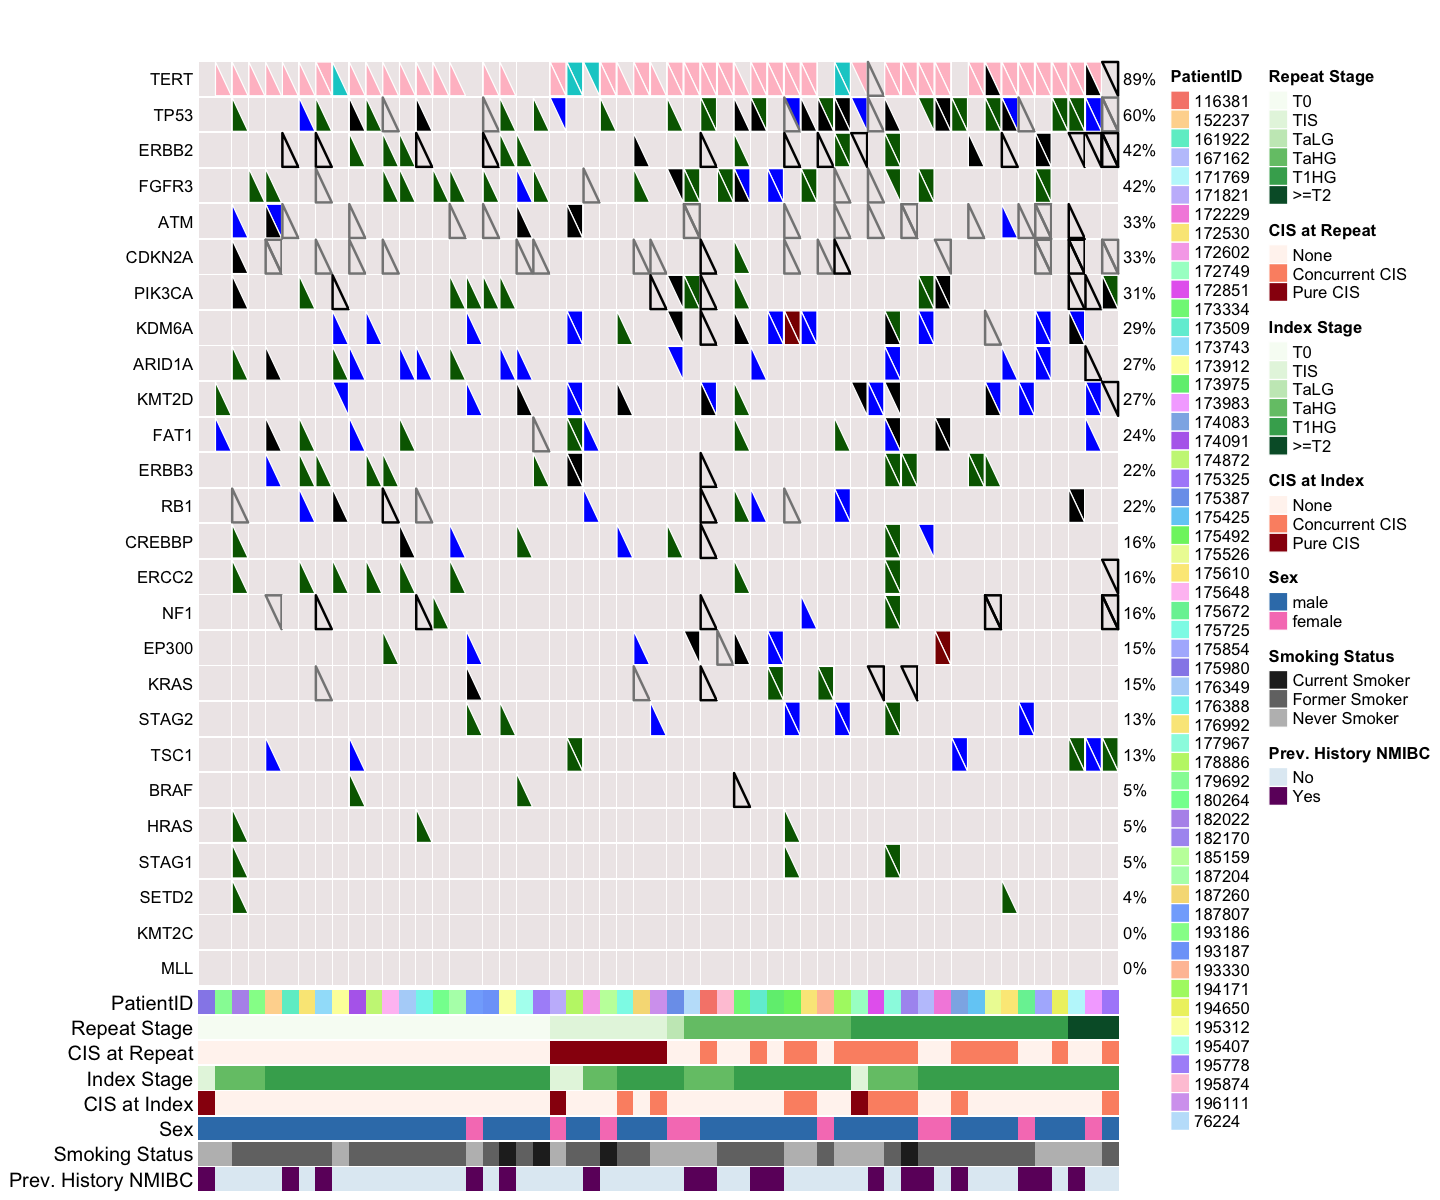

In [119]:
## FFPE WES Oncoprints

## need rerun with Patched variant file (?)

source("~/Desktop/Predicine/concordance_oncoprint.R")
options(repr.plot.width=12,repr.plot.height=10)

# select genes
nmibc.genes = read.csv("Manuscript/NMIBC_genes_JL_April2024.csv", as.is=T)

#######
out.file = glue("./Conferences/AUA/OncoPrint_Index_vs_Repeat_FFPE_wPIDs_unpatched_{Sys.Date()}")
df_samples = samples.ind_rep_paired
nrow(df_samples)
snv.data = all.snv %>% filter(SampleID.short %in% df_samples$SampleID.short,
                              SYMBOL %in% nmibc.genes$Name)
cnv.data = all.cnv %>% filter(SampleID.short %in% df_samples$SampleID.short,
                              Gene %in% nmibc.genes$Name)

concordance_oncoprint(snv.data = snv.data,
                      cnv.data = cnv.data,
                      df_samples = df_samples,
                      ref_sample_type="IndexTURBT_tissue",
                      mrd_sample_type="RepeatTURBT_tissue",
                      clin.data = df_annot,
                      show.clin.data = T,
                      clin.data.cols = names(annot.colors),
                      clin.annotation.colors = annot.colors,
                      show.patient.id=T,
                      make.legend=F,
                      concord.barplot=F,
                      #show.top.n=25,
                      genes = sort(nmibc.genes$Name),
                      var.reduc.set="consequence_reduced",
                      out.file=out.file)


In [100]:
# check a few PIDS against the plot
pid = "195312" #"152237"

snv.data %>% filter(PatientID==pid, ) %>% arrange(SYMBOL) %>% relocate(PatientID, StudyVisit, SYMBOL)
cnv.data %>% filter(PatientID==pid, ) %>% arrange(Gene) %>% relocate(PatientID, Gene)

min(snv.data$VariantFreq, na.rm = T)

PatientID,StudyVisit,SYMBOL,X,seqnames,start,end,width,ref,alt,totalDepth,refDepth,altDepth,sampleNames,VariantFreq,GeneID,Feature,HGVSc,HGVSp,Amino_acids,Codons,BIOTYPE,EXON,INTRON,Consequence,DISTANCE,Existing_variation,VARIANT_CLASS,CLIN_SIG,Clinvar,dbSNP,COSMIC,COSMIC.CNT,genome1000,AF,CANONICAL,filteredCnt,DSCnt,⋯,repeatRegion,white.list,wl.tier,GC.Percent,tandemRepeat,AF.th,AF.diff,bgFilter,generalFilter,localVariantFilter,ReadEndFilter,DS.filter,highQ.ratio,fc.ds.ratio,CopyNumber,zScore.cnv,coVariant,ol.coVariant,coVariantFilter,sideVariant,sideVariant.AF.ratio,prevalenceInternal,filterPrevalence,filterScore,finalKeep,VariantID,sampleDir,VariantType,sampleFolder,externalSampleID,SpecimenType,ID,highFrequent.inbatch,concordant,VariantType.old,SampleID.short,SampleType
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<int>,⋯,<lgl>,<lgl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<chr>,<chr>
195312,IndexTURBT,ARID1A,74711,chr1,27056181,27056181,1,C,T,1208,1140,68,P237650A01,5.629139,8289,NM_006015.6,c.1177C>T,p.Gln393Ter,p.Q393*,Cag/Tag,protein_coding,'2/20',NA,stop_gained,NA,COSV61376568,SNV,NA,NA,NA,COSM51446,8,,NA,yes,53,9,⋯,FALSE,FALSE,,52.9,NA,0.14436411,5.484775,TRUE,TRUE,TRUE,TRUE,TRUE,0.779,2.717020,2.1400000,1.97,chr1:27056112:C68C:G68T,0.698,TRUE,,NA,0.01390,TRUE,8.2917,TRUE,chr1:27056181:C:T,/prednet/data30/OutputByRun30/20240126_LH00405_0030_B223H2LLT4_runtask_240126224313_fd9ec821/dsrun1.7.1/work/eb/5330f4e4c58369715f81bf1b52b11f,Likely somatic,P237650A01_20240126,06S23104864,FFPE,P237650A01:chr1:27056181:C:T,1,FALSE,Likely somatic,P237650,tissue
195312,IndexTURBT,ERBB2,74851,chr17,37866662,37866662,1,G,T,1386,1305,81,P237650A01,5.844156,2064,NM_004448.3,c.829G>T,p.Asp277Tyr,p.D277Y,Gac/Tac,protein_coding,'7/27',NA,missense_variant,NA,COSV54062992&COSV54071143,SNV,NA,NA,NA,COSM1749995,14,,NA,yes,61,6,⋯,FALSE,FALSE,T3B,57.9,NA,0.15150412,5.692652,TRUE,TRUE,TRUE,TRUE,TRUE,0.753,4.951299,1.9400000,-0.86,,NA,TRUE,,NA,0.00143,TRUE,8.3250,TRUE,chr17:37866662:G:T,/prednet/data30/OutputByRun30/20240126_LH00405_0030_B223H2LLT4_runtask_240126224313_fd9ec821/dsrun1.7.1/work/eb/5330f4e4c58369715f81bf1b52b11f,Likely somatic,P237650A01_20240126,06S23104864,FFPE,P237650A01:chr17:37866662:G:T,1,FALSE,Likely somatic,P237650,tissue
195312,IndexTURBT,PIK3CA,74974,chr3,178936091,178936091,1,G,A,1632,1442,190,P237650A01,11.642157,5290,NM_006218.4,c.1633G>A,p.Glu545Lys,p.E545K,Gag/Aag,protein_coding,'10/21',NA,missense_variant,NA,rs104886003&CM126692&COSV55873239&COSV55878227,SNV,likely_pathogenic&not_provided&pathogenic&pathogenic/likely_pathogenic,"Likely pathogenic:24,Pathogenic:22,not provided:2",rs104886003,COSM763,3058,rs104886003,8.879e-06,yes,166,18,⋯,FALSE,TRUE,T0,38.8,NA,0.03036617,11.611791,TRUE,TRUE,TRUE,TRUE,TRUE,0.874,3.233766,2.1900000,2.63,,NA,TRUE,,NA,0.03000,TRUE,10.7500,TRUE,chr3:178936091:G:A,/prednet/data30/OutputByRun30/20240126_LH00405_0030_B223H2LLT4_runtask_240126224313_fd9ec821/dsrun1.7.1/work/eb/5330f4e4c58369715f81bf1b52b11f,Somatic,P237650A01_20240126,06S23104864,FFPE,P237650A01:chr3:178936091:G:A,5,FALSE,Somatic,P237650,tissue
195312,IndexTURBT,STAG2,75092,chrX,123200213,123200213,1,T,C,1148,1037,111,P237650A01,9.668990,10735,NM_006603.5,c.2192T>C,p.Ile731Thr,p.I731T,aTt/aCt,protein_coding,'22/33',NA,missense_variant,NA,rs774873046,SNV,NA,NA,NA,,NA,rs774873046,2.471e-05,yes,94,8,⋯,FALSE,FALSE,,33.9,NA,NA,NA,TRUE,TRUE,TRUE,TRUE,TRUE,0.847,4.577922,1.1800000,4.75,,NA,TRUE,,NA,NA,TRUE,8.9833,TRUE,chrX:123200213:T:C,/prednet/data30/OutputByRun30/20240126_LH00405_0030_B223H2LLT4_runtask_240126224313_fd9ec821/dsrun1.7.1/work/eb/5330f4e4c58369715f81bf1b52b11f,Likely somatic,P237650A01_20

PatientID,Gene,X,SampleID,CNV_Type,Cytoband,seqnames,start,end,CopyNumber,zScore,zScore.withinSample,gender,meanCoverage,gcPercent,DetectRegionSize,probeNum,combinedResidual,tumorfraction.cnv,tumorfraction.snp,cnvScore,baseline.method,CopyNumber_SNP,SD.CopyNumber_SNP,NumberOfSNP,GC.Percent_SNP,CopyNumber_SNP_wide,SD.CopyNumber_SNP_wide,NumberOfSNP_wide,GC.Percent_SNP_wide,DetectRegionSize_SNP,baseline.snp.percent,baseline.snp.count,uniformity_2fold,whitelist,cytoband_count,chrArm_count,nearby_consistency,geneType,EM_confidence,CNLTumorFraction,subcloningIndex,majorityCount,NeighborNum,CNL_Type,CNL_Type.score,LOH_Type,LOH.score,VariantID,sampleDir,CopyNumber.sm,SampleID.short,StudyVisit,SampleType
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>


[1] 1.05364

## concordance bar plots

In [44]:
## to match patients/order in the oncoprint

all.snv = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_combined_2024-05-16.csv") %>%
                filter(grepl("somatic", VariantType, ignore.case=TRUE)) # all short somatic
all.cnv = read.csv("data_delivery/WES/PRDC-MOFFITT-NMIBC-22001_CNV_all_combined_2024-05-13.csv") 

        
         IndexTURBT RepeatTURBT  <NA>
  tissue      13617        3362     0
  <NA>            0           0     0

[1] "IndexTURBT"  "RepeatTURBT"
[1] "tissue"
[1] "reference sample: IndexTURBT_tissue"
[1] "median number reference variants: 108"
[1] "min: 0"
[1] "max: 1392"
[1] "sd: 275.765831944055"
[1] "MRD sample: RepeatTURBT_tissue"
[1] "median number MRD variants: 6"
[1] "min: 0"
[1] "max: 1113"
[1] "sd: 154.586706147437"


[1] "175980" "169558" "179692" "182022" "193186" "152237" "161922" "172530"
 [9] "173254" "173743" "173912" "174091" "174872" "175648" "175733" "175831"
[17] "176349" "176388" "180264" "181568" "182435" "185014" "186478" "187204"
[25] "187807" "191692" "193187" "195312" "195407" "195778" "171821" "173359"
[33] "178886" "184485" "195451" "172602" "185159" "189953" "171374" "172153"
[41] "175725" "178919" "187260" "189342" "196111" "175387" "181439" "76224" 
[49] "116381" "173075" "173350" "173362" "185382" "188867" "193248" "195874"
[57] "196412" "173334" "173509" "173975" "175492" "176992" "185212" "186652"
[65] "193330" "194171" "172749" "182910" "172851" "176828" "177967" "182170"
[73] "185581" "190233" "165028" "167162" "172229" "172586" "174083" "174947"
[81] "175425" "175526" "175610" "175672" "175854" "184615" "184957" "189083"
[89] "191632" "192682" "194650" "173281" "171769" "173983" "175325" "184289"

[1] "175980:T0"   "179692:T0"   "182022:T0"   "193186:T0"   "152237:T0"  
 [6] "161922:T0"   "172530:T0"   "173743:T0"   "173912:T0"   "174091:T0"  
[11] "174872:T0"   "175648:T0"   "175733:T0"   "176349:T0"   "176388:T0"  
[16] "180264:T0"   "187204:T0"   "187807:T0"   "193187:T0"   "195312:T0"  
[21] "195407:T0"   "195778:T0"   "171821:TIS"  "178886:TIS"  "172602:TIS" 
[26] "185159:TIS"  "175725:TIS"  "187260:TIS"  "196111:TIS"  "175387:TaLG"
[31] "76224:TaHG"  "116381:TaHG" "173350:TaHG" "195874:TaHG" "173334:TaHG"
[36] "173509:TaHG" "173975:TaHG" "175492:TaHG" "176992:TaHG" "193330:TaHG"
[41] "194171:TaHG" "172749:T1HG" "172851:T1HG" "176828:T1HG" "177967:T1HG"
[46] "182170:T1HG" "167162:T1HG" "172229:T1HG" "172586:T1HG" "174083:T1HG"
[51] "175425:T1HG" "175526:T1HG" "175610:T1HG" "175672:T1HG" "175854:T1HG"
[56] "192682:T1HG" "194650:T1HG" "171769:>=T2" "173983:>=T2" "175325:>=T2"

PatientID,SampleID.short,SampleType,StudyVisit,n_ref_vars,n_sample_vars,n_concord_vars,n_unique_vars,pct.concord,sample_type,Repeat.Stage,label,Category,N.variants
<ord>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>
175980,P232623,tissue,RepeatTURBT,0,2,0,2,0,RepeatTURBT_tissue,T0,175980:T0,Index.Only,0
175980,P232623,tissue,RepeatTURBT,0,2,0,2,0,RepeatTURBT_tissue,T0,175980:T0,Concordant,0
175980,P232623,tissue,RepeatTURBT,0,2,0,2,0,RepeatTURBT_tissue,T0,175980:T0,Repeat.Only,2
179692,P237635,tissue,RepeatTURBT,6,1,0,1,0,RepeatTURBT_tissue,T0,179692:T0,Index.Only,6
179692,P237635,tissue,RepeatTURBT,6,1,0,1,0,RepeatTURBT_tissue,T0,179692:T0,Concordant,0
179692,P237635,tissue,RepeatTURBT,6,1,0,1,0,RepeatTURBT_tissue,T0,179692:T0,Repeat.Only,1


pdf 
  2

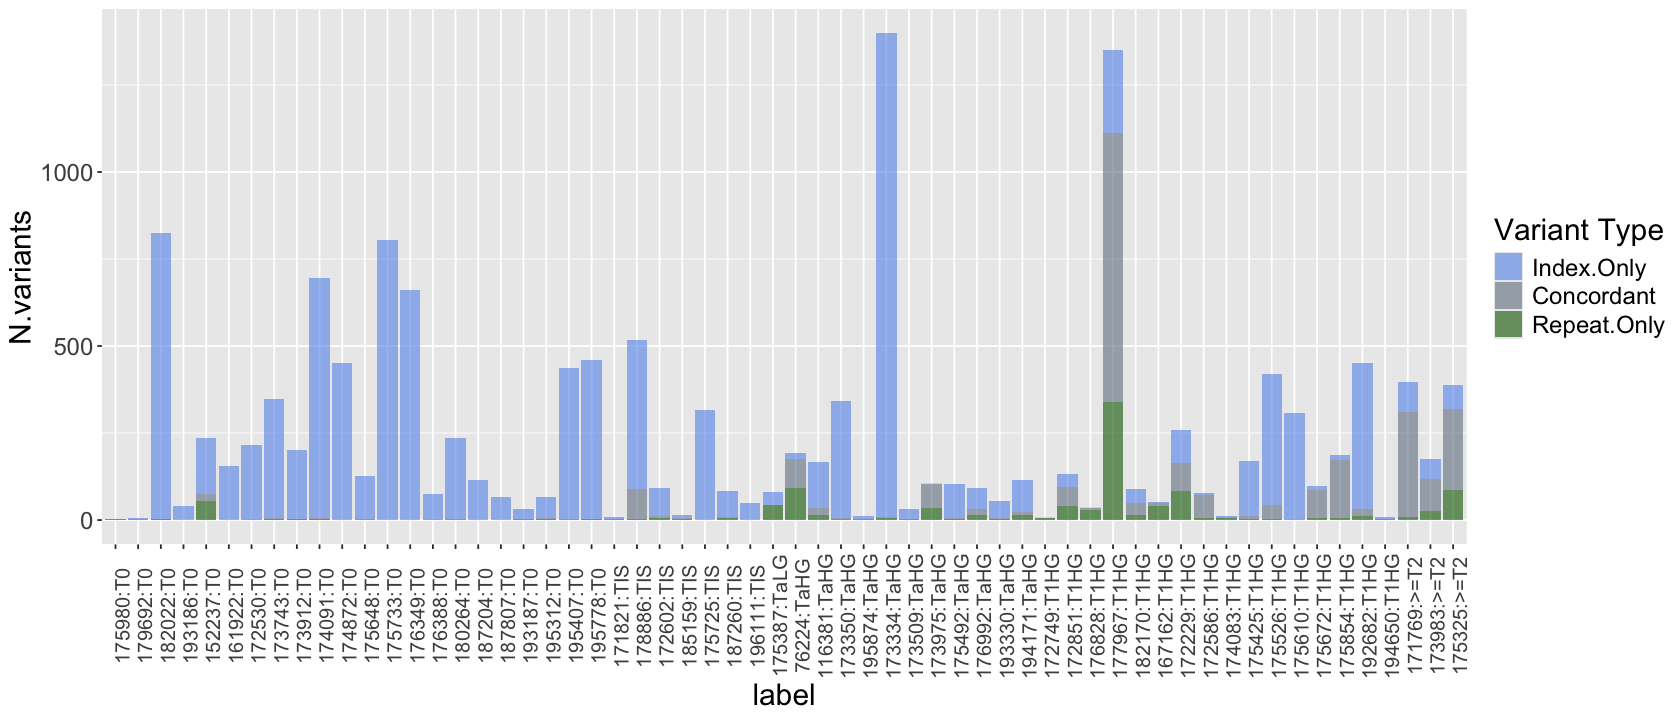

In [79]:
## index vs. repeat tumors - all patients
source("~/Desktop/Predicine/get_concordance_stats.R") ## separate plot for cnvs?
options(repr.plot.width=14,repr.plot.height=6)

# ####
plt.df = samples.ind_rep_paired
jpeg(glue("./Manuscript/plots/Concordance_barplot_index_repeat_SNV_unpatched_{Sys.Date()}.jpeg"), height=6, width=14, units="in", res=300)
colors=c("cornflowerblue","slategrey","darkgreen")
names(colors)=c("Index.Only","Concordant","Repeat.Only") # similar to venn
# ###
                     
###
# df_clin2 = df_clin %>% mutate("PT.STAGE"=factor(PT.STAGE, levels=c("T0","Tis","T1","T2a","T2b","T3a","T3b","T4a")),
#                              "PN.STAGE"=factor(PN.STAGE, levels=c("NX","N0","N1","N2"))) %>%
#                       arrange(PT.STAGE,PN.STAGE)

variants.sel = all.snv %>% filter(SampleID.short %in% plt.df$SampleID.short) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(plt.df %>% select(SampleID.short, StudyVisit, SampleType, PatientID), by="SampleID.short")
table(variants.sel$SampleType, variants.sel$StudyVisit)

df_concord_counts = get_concordance_stats(variant.data = variants.sel, 
                                          ref_sample_type = "IndexTURBT_tissue", 
                                          df_samples = plt.df %>%
                                                         select(PatientID,SampleID.short,SampleType,StudyVisit))  

plot_data = df_concord_counts %>% filter(StudyVisit=="RepeatTURBT") %>%
        mutate(Concordant= n_concord_vars,
               Index.Only=n_ref_vars-n_concord_vars, 
               Repeat.Only=n_sample_vars-n_concord_vars) %>%
        left_join(df_annot %>% select(all_of(c("PatientID","Repeat Stage"))), by="PatientID") %>%
        mutate(PatientID=factor(PatientID, levels=as.character(df_annot$PatientID), ordered=TRUE)) %>%
        arrange(PatientID)

plot_data = plot_data %>% rename("Repeat.Stage"="Repeat Stage") %>%
                           mutate(label = paste0(PatientID, ":", Repeat.Stage),
                                  label = factor(label, levels=label)) # set the bar plot order
levels(plot_data$PatientID)
levels(plot_data$label)

plot_data = plot_data %>% pivot_longer(cols = names(colors), #c("Repeat.Only","Concordant","Index.Only"), 
                                       names_to = "Category",values_to = "N.variants") %>%
                                    mutate("Category"=factor(Category, levels= names(colors))) #c("Repeat.Only","Concordant","Index.Only")

gg <- ggplot(plot_data, aes(x=label, y=N.variants, fill=Category)) +
    geom_bar(stat = "identity",alpha=0.6) +
    scale_fill_manual(name="Variant Type",
                      breaks=names(colors), 
                      values=colors) + # similar to ven.colors
    theme(text=element_text(size=18), #axis.ticks.x=element_blank(), 
          axis.text.x=element_text(size=12,angle = 90)
         )
show(gg)
dev.off()

show(gg)

        
         IndexTURBT Pre-RepeatTURBT <NA>
  tissue       9005               0    0
  urine           0            8506    0
  <NA>            0               0    0

[1] "IndexTURBT"      "Pre-RepeatTURBT"
[1] "tissue" "urine" 
[1] "reference sample: IndexTURBT_tissue"
[1] "median number reference variants: 76"
[1] "min: 1"
[1] "max: 1540"
[1] "sd: 238.331621927348"
[1] "MRD sample: Pre-RepeatTURBT_urine"
[1] "median number MRD variants: 73"
[1] "min: 0"
[1] "max: 1394"
[1] "sd: 228.564648105367"


[1] "175980" "169558" "179692" "182022" "193186" "152237" "161922" "172530"
 [9] "173254" "173743" "173912" "174091" "174872" "175648" "175733" "175831"
[17] "176349" "176388" "180264" "181568" "182435" "185014" "186478" "187204"
[25] "187807" "191692" "193187" "195312" "195407" "195778" "171821" "173359"
[33] "178886" "184485" "195451" "172602" "185159" "189953" "171374" "172153"
[41] "175725" "178919" "187260" "189342" "196111" "175387" "181439" "76224" 
[49] "116381" "173075" "173350" "173362" "185382" "188867" "193248" "195874"
[57] "196412" "173334" "173509" "173975" "175492" "176992" "185212" "186652"
[65] "193330" "194171" "172749" "182910" "172851" "176828" "177967" "182170"
[73] "185581" "190233" "165028" "167162" "172229" "172586" "174083" "174947"
[81] "175425" "175526" "175610" "175672" "175854" "184615" "184957" "189083"
[89] "191632" "192682" "194650" "173281" "171769" "173983" "175325" "184289"

[1] "179692:T0"   "193186:T0"   "173743:T0"   "175648:T0"   "175831:T0"  
 [6] "176388:T0"   "181568:T0"   "182435:T0"   "186478:T0"   "187204:T0"  
[11] "187807:T0"   "193187:T0"   "195312:T0"   "195407:T0"   "195778:T0"  
[16] "171821:TIS"  "184485:TIS"  "195451:TIS"  "172602:TIS"  "185159:TIS" 
[21] "189953:TIS"  "171374:TIS"  "175725:TIS"  "178919:TIS"  "187260:TIS" 
[26] "189342:TIS"  "196111:TIS"  "181439:TaHG" "76224:TaHG"  "173075:TaHG"
[31] "173362:TaHG" "185382:TaHG" "188867:TaHG" "193248:TaHG" "195874:TaHG"
[36] "196412:TaHG" "185212:TaHG" "186652:TaHG" "193330:TaHG" "194171:TaHG"
[41] "172749:T1HG" "182910:T1HG" "172851:T1HG" "176828:T1HG" "182170:T1HG"
[46] "185581:T1HG" "190233:T1HG" "172229:T1HG" "172586:T1HG" "174083:T1HG"
[51] "175425:T1HG" "175672:T1HG" "184615:T1HG" "184957:T1HG" "189083:T1HG"
[56] "191632:T1HG" "194650:T1HG" "171769:>=T2" "184289:>=T2"

pdf 
  2

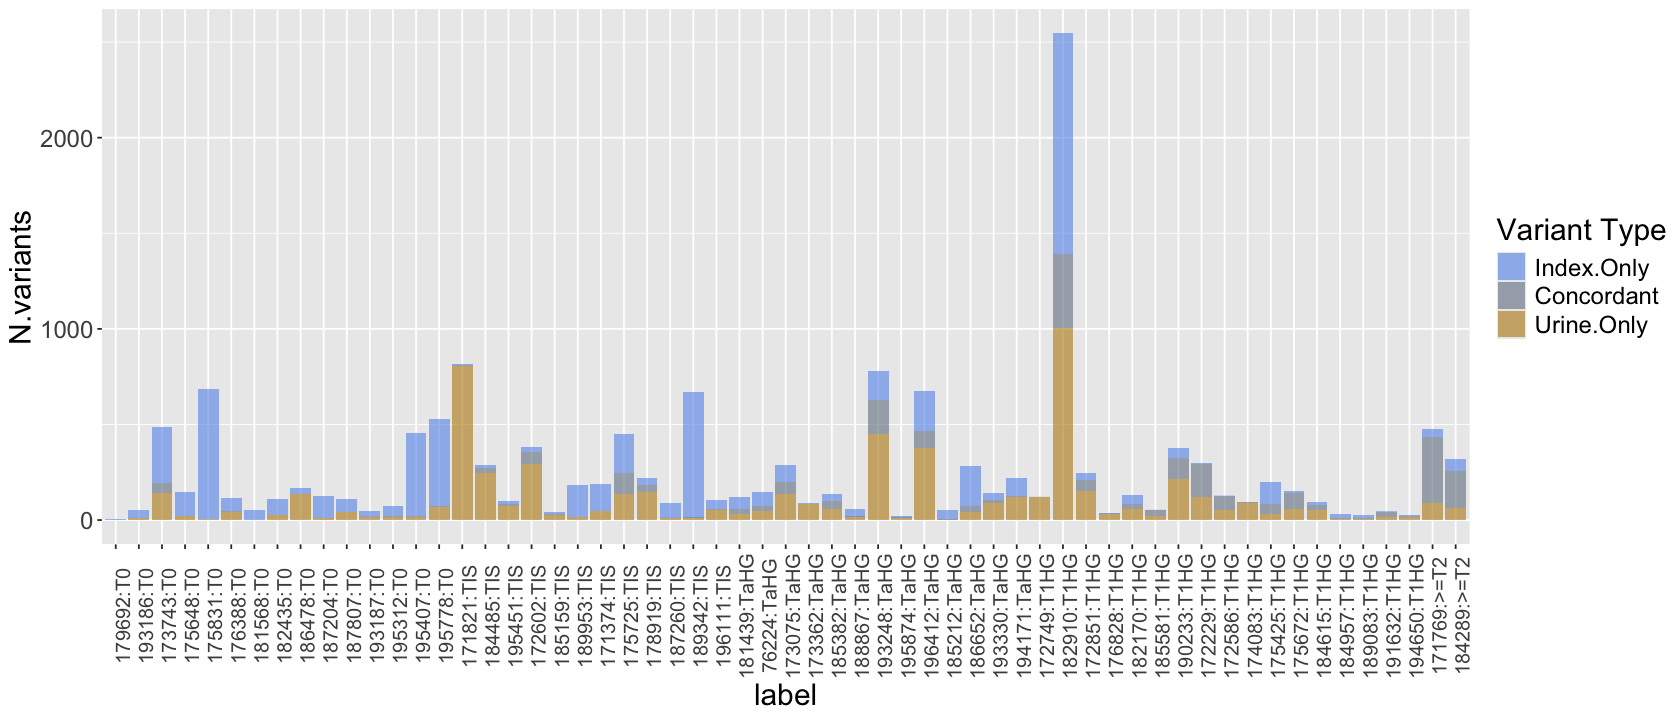

In [74]:
# index vs. preUR concordance per patient - all patients

## concordance by patient barplots
source("~/Desktop/Predicine/get_concordance_stats.R") ## separate plot for cnvs?
options(repr.plot.width=14,repr.plot.height=6)

####
plt.df = samples.ind_urine_paired
jpeg(glue("./Manuscript/plots/Concordance_barplot_index_urine_SNV_unpatched_{Sys.Date()}.jpeg"), height=6, width=14, units="in", res=300)
colors=c("cornflowerblue","slategrey","darkgoldenrod")
names(colors)=c("Index.Only","Concordant","Urine.Only")
                      
variants.sel = all.snv %>% filter(SampleID.short %in% plt.df$SampleID.short) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(plt.df %>% select(SampleID.short, StudyVisit, SampleType, PatientID), by="SampleID.short")
table(variants.sel$SampleType, variants.sel$StudyVisit)

df_concord_counts = get_concordance_stats(variant.data = variants.sel, 
                                          ref_sample_type = "IndexTURBT_tissue", 
                                          df_samples = plt.df %>%
                                                         select(PatientID,SampleID.short,SampleType,StudyVisit))  
plot_data = df_concord_counts %>% filter(SampleType=="urine") %>%
        mutate(Concordant= n_concord_vars,
               Index.Only=n_ref_vars-n_concord_vars, 
               Urine.Only=n_sample_vars-n_concord_vars) %>%
        left_join(df_annot %>% select(all_of(c("PatientID","Repeat Stage"))), by="PatientID") %>%
        mutate(PatientID=factor(PatientID, levels=as.character(df_annot$PatientID), ordered=TRUE)) %>%
        arrange(PatientID)
plot_data = plot_data %>% rename("Repeat.Stage"="Repeat Stage") %>%
                           mutate(label = paste0(PatientID, ":", Repeat.Stage),
                                  label = factor(label, levels=label)) # set the bar plot order
levels(plot_data$PatientID)
levels(plot_data$label)

plot_data = plot_data %>% pivot_longer(cols = names(colors), 
                                       names_to = "Category",values_to = "N.variants") %>%
                                       mutate("Category"=factor(Category, levels= names(colors)))

gg <- ggplot(plot_data, aes(x=label, y=N.variants, fill=Category)) +
    geom_bar(stat = "identity",alpha=0.6) +
    scale_fill_manual(name="Variant Type",
                      breaks=names(colors), 
                      values=colors) + # similar to ven.colors
    theme(text=element_text(size=18), #axis.ticks.x=element_blank(), 
          axis.text.x=element_text(size=12,angle = 90)
         )
show(gg)
dev.off()

show(gg)

## Gene mutation frequency barplot

In [98]:
samples.ind_rep_urine_paired = samples.orig %>% filter(SampleType != "buffy_coat") %>%
                group_by(PatientID) %>% mutate(count=n()) %>% filter(count==3) %>% ungroup()

nrow(samples.ind_rep_urine_paired)/3

nmibc.genes = read.csv("Manuscript/NMIBC_genes_JL_April2024.csv", as.is=T)

[1] 32

[1] 18


        
         IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  tissue       1844               0         809    0
  urine           0            3087           0    0
  <NA>            0               0           0    0


Likely somatic        Somatic           <NA> 
          1324           4416              0 

ERROR: Error in eval(expr, envir, enclos): 


[1] 10


[1] 57

pdf 
  2

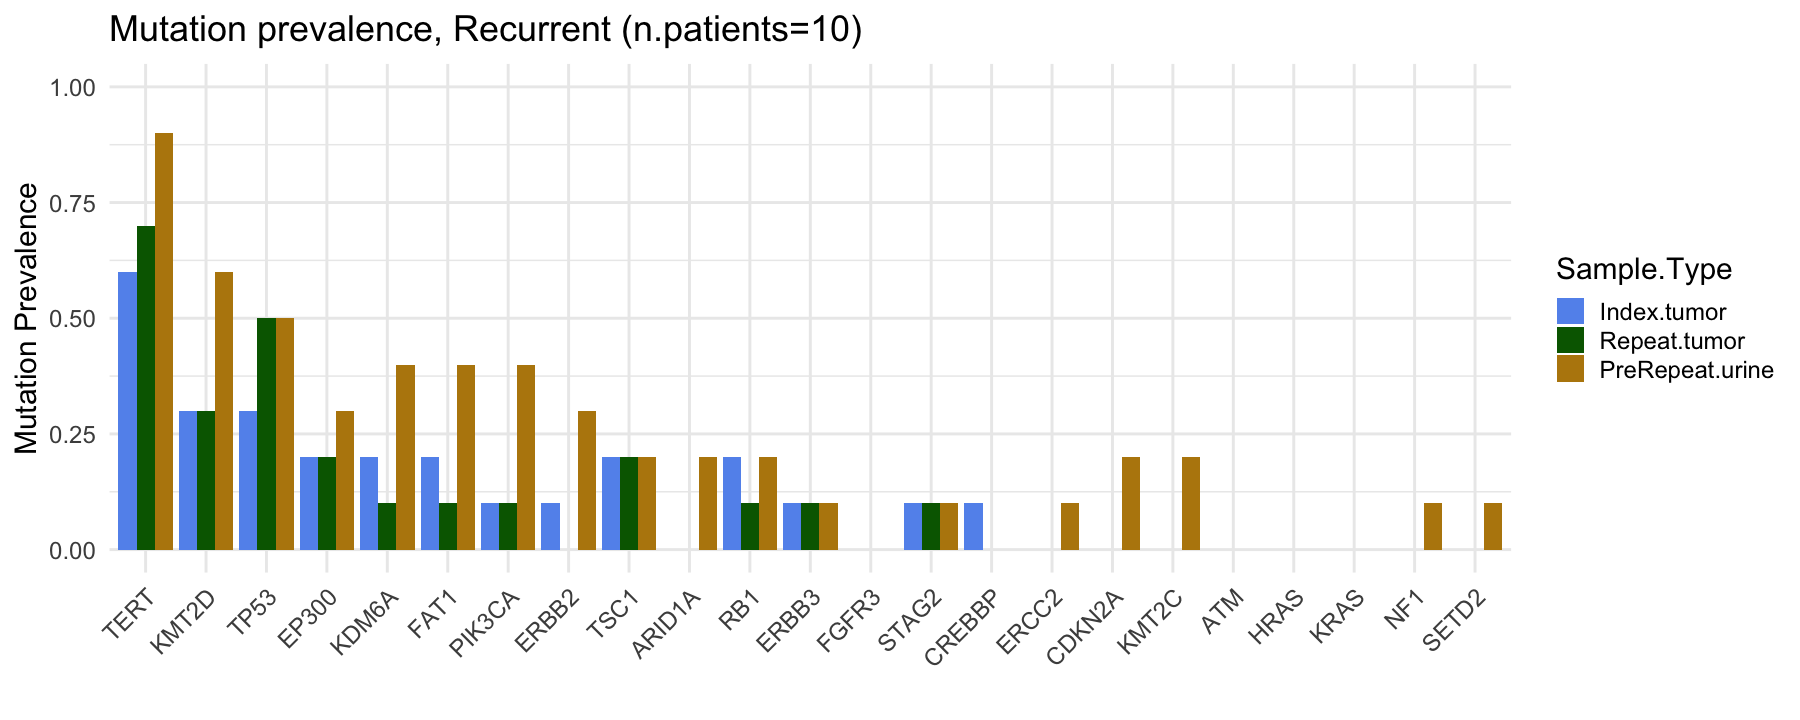

[1] 32

[1] 32


        
         IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  tissue       3665               0        1098    0
  urine           0            3938           0    0
  <NA>            0               0           0    0


Likely somatic        Somatic           <NA> 
          4203           4498              0 

pdf 
  2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

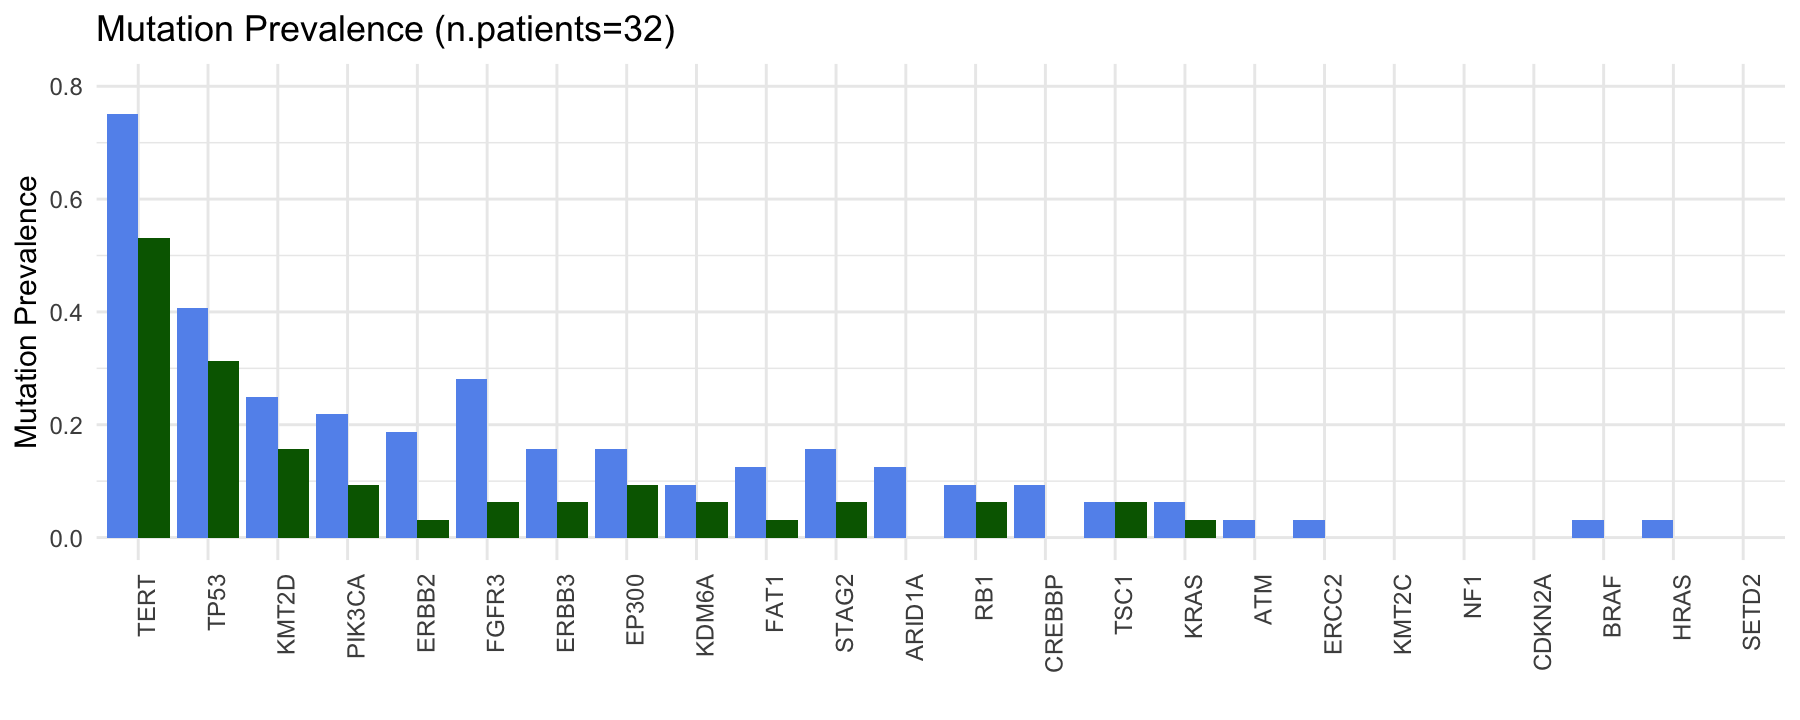

[1] 11


[1] 54

pdf 
  2

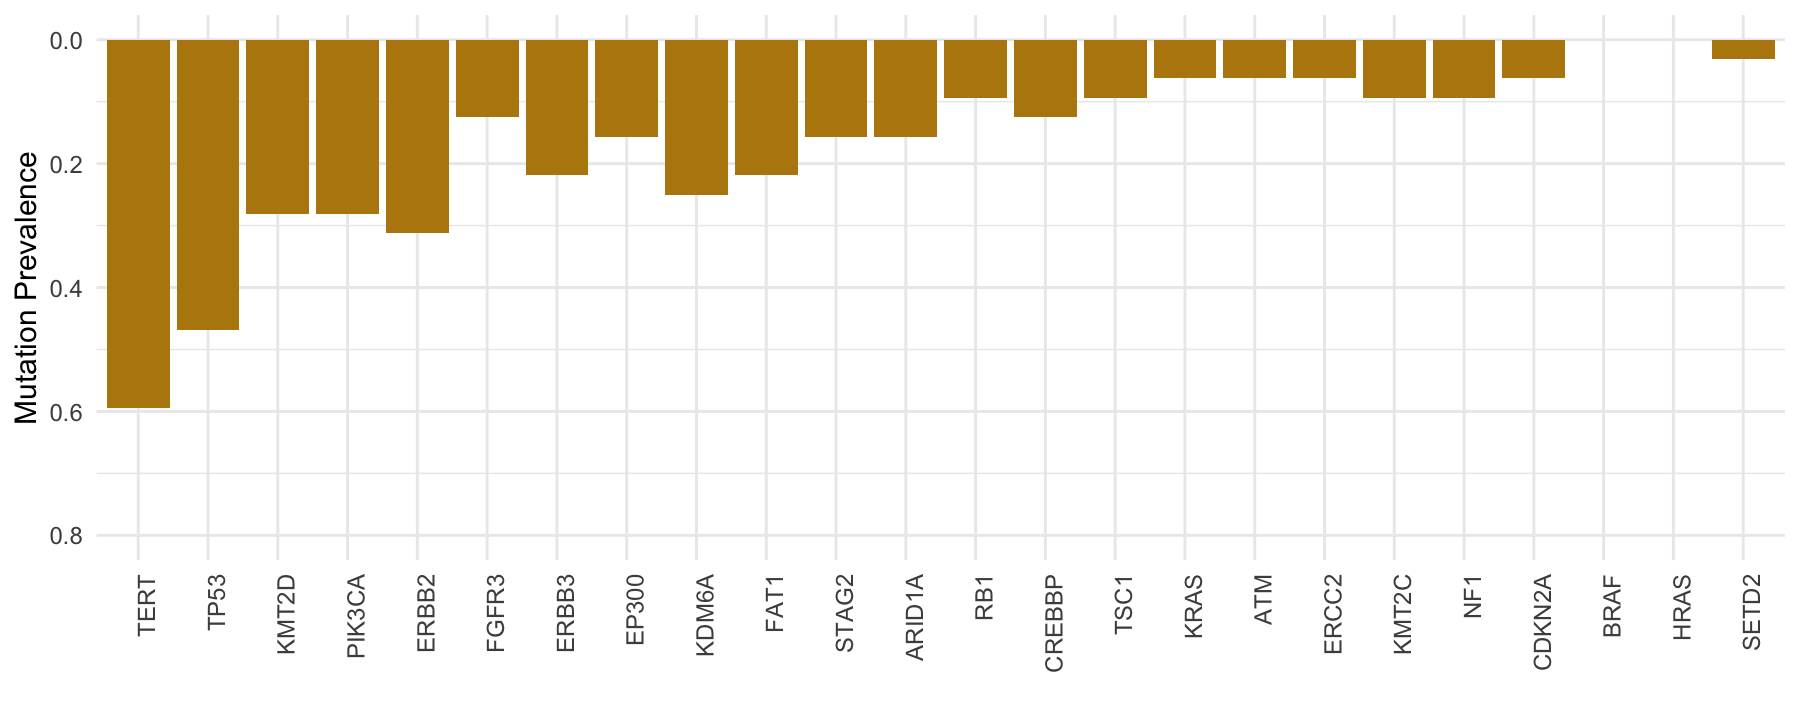

[1] 21


[1] 66

pdf 
  2

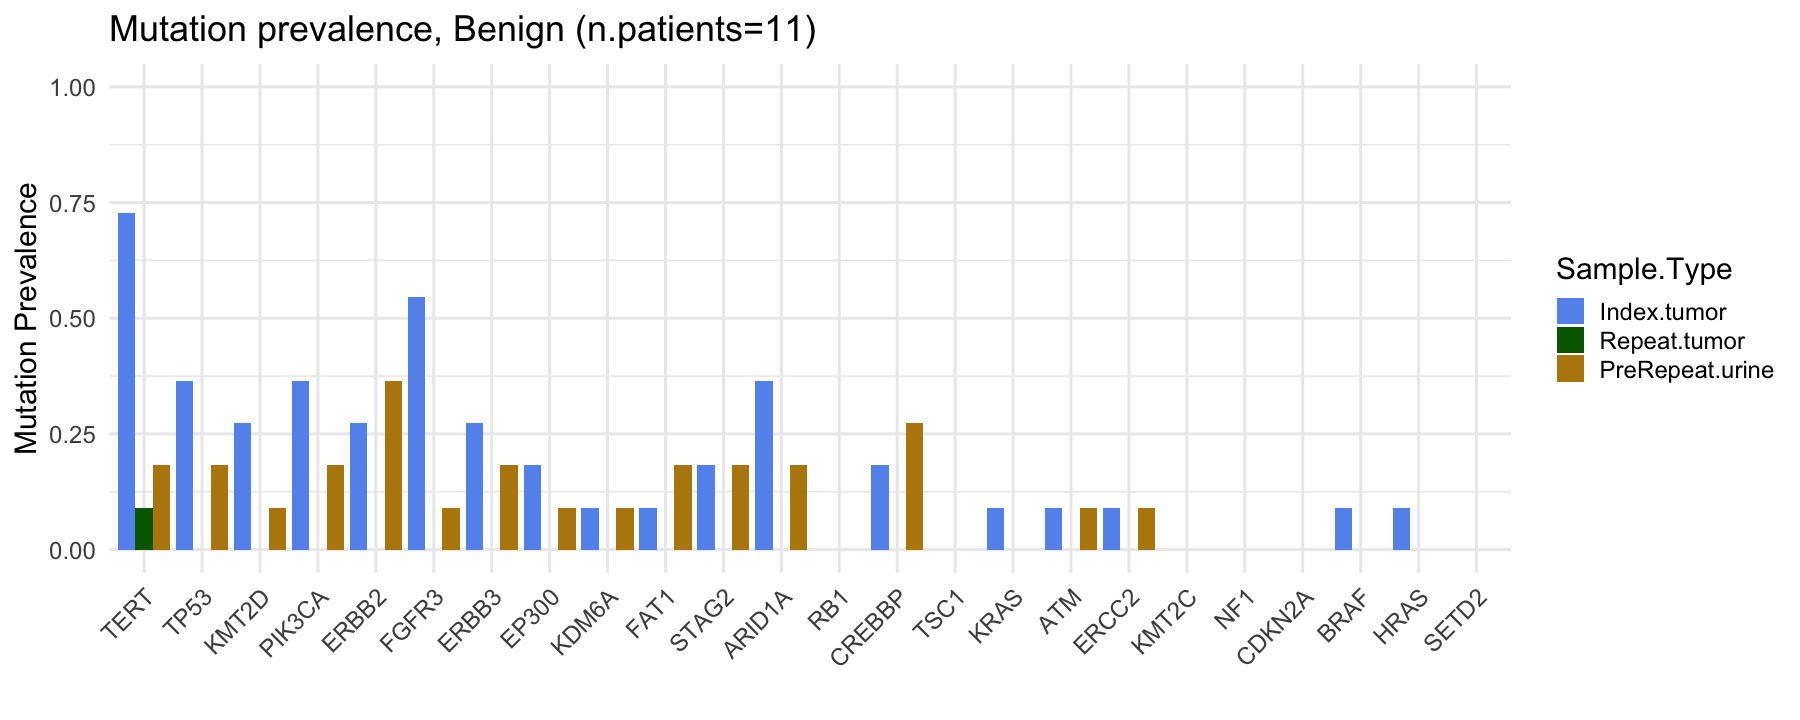

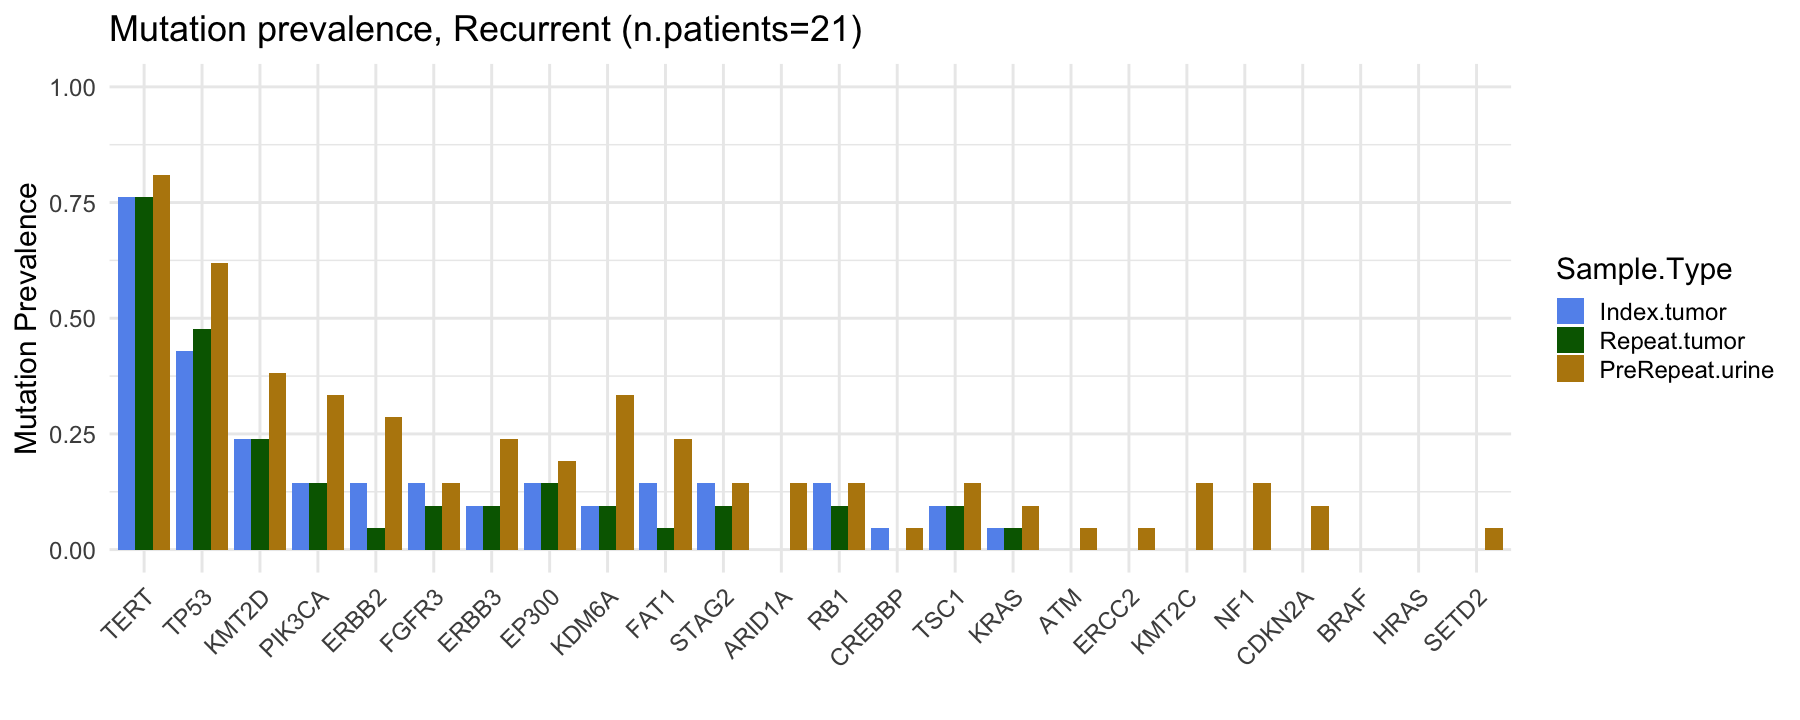

In [91]:
# 32 patients with and without PBMC data (split and combined plots)
gene.order = readRDS("ms_prevalence_gene_order_32pats.rds")
samples.ind_rep_urine_paired.add_nopbmc = samples.orig %>% filter(SampleType != "buffy_coat",
                                                      #has.pbmc.wes == "TRUE"
                                                                 ) %>%
                group_by(PatientID) %>% mutate(count=n()) %>% filter(count==3) %>% ungroup()

nrow(samples.ind_rep_urine_paired.add_nopbmc)/3
## upper/lower sample split barplot
options(repr.plot.width=15, repr.plot.height=6)
ven.colors = c("RepeatTURBT_tissue"="darkgreen",
             "IndexTURBT_tissue"="cornflowerblue",
            "Pre-RepeatTURBT_urine"="darkgoldenrod")
plt.colors = ven.colors
names(plt.colors) = c("Repeat.tumor","Index.tumor","PreRepeat.urine")
plt.colors = plt.colors[c("Index.tumor","Repeat.tumor","PreRepeat.urine")] # set order

variants.sel = all.snv %>% filter(SampleID.short %in% samples.ind_rep_urine_paired.add_nopbmc$SampleID.short) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired.add_nopbmc %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat") # just to make sure
n.pats = length(unique(samples.ind_rep_urine_paired.add_nopbmc$PatientID))
print(n.pats)
table(variants.sel$SampleType, variants.sel$StudyVisit)
table(variants.sel$VariantType)
plot.data = variants.sel %>% filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats) %>%
                mutate(total.mutated = Index.tumor + Repeat.tumor + PreRepeat.urine)
gene.order = plot.data$SYMBOL[order(plot.data$total.mutated, decreasing=TRUE)]
#saveRDS(gene.order, "ms_prevalence_gene_order_32pats.rds")

####### upper plot
plot.data.up = plot.data %>% select(-PreRepeat.urine,-total.mutated) %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(SYMBOL=factor(SYMBOL, levels=gene.order, ordered=TRUE)) %>%
                arrange(SYMBOL, Sample.Type)
#head(plot.data.up)
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_UpperPlt_32pats_{Sys.Date()}.jpg"), width=14, height=6, res=300, units = "in")
gg <- ggplot(plot.data.up, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1),legend.position = "none") +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation Prevalence (n.patients={n.pats})")) +
        ylim(c(0,0.8)) +
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors)
show(gg)
dev.off()
show(gg)

##### lower plot
plot.data.down = plot.data %>%
                mutate(SYMBOL=factor(SYMBOL, levels=gene.order, ordered=TRUE)) %>%
                arrange(SYMBOL)
#head(plot.data)
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_lowerPlt_32pats_{Sys.Date()}.jpg"), width=14, height=6, res=300, units = "in")
gg <- ggplot(plot.data.down, aes(x=SYMBOL, y=PreRepeat.urine, fill="PreRepeat.urine")) +
        geom_bar(stat = "identity") + 
        scale_y_continuous(trans = "reverse") +
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1), legend.position = "none") +
        labs(x="", y="Mutation Prevalence") +
        ylim(c(0.8,0)) +
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors)
show(gg)
dev.off()
show(gg)

################
## two bar plots separated by recur/benign status

#### set group - Benign
benign="TRUE"
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_benignPatients_32pate_{Sys.Date()}.jpg"), width=15, height=6, res=300, units = "in")

n.pats = length(unique(samples.ind_rep_urine_paired.add_nopbmc$PatientID[samples.ind_rep_urine_paired.add_nopbmc$benign==benign]))
print(n.pats)
sids = samples.ind_rep_urine_paired.add_nopbmc$SampleID.short[samples.ind_rep_urine_paired.add_nopbmc$benign==benign]
##### data #####
variants.sel = all.snv %>% filter(SampleID.short %in% sids) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired.add_nopbmc %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat")
plot.data = variants.sel %>% mutate(SYMBOL = factor(SYMBOL, levels=gene.order)) %>%
                filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats)
plot.data.all = plot.data %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor","PreRepeat.urine"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(Sample.Type = factor(Sample.Type, levels=c("Index.tumor","Repeat.tumor","PreRepeat.urine")))
                
nrow(plot.data.all)
# if (benign=="TRUE"){ # create rows for missing genes
#     mis.genes = gene.order[gene.order %!in% plot.data.all$SYMBOL]
#     df1 = data.frame("SYMBOL"=mis.genes, Sample.Type="Index.tumor","mutation.freq"=0.0)
#     df2 = data.frame("SYMBOL"=mis.genes, Sample.Type="Repeat.tumor","mutation.freq"=0.0)
#     df3 = data.frame("SYMBOL"=mis.genes, Sample.Type="PreRepeat.urine","mutation.freq"=0.0)
#     plot.data.all = rbind(plot.data.all, df1, df2, df3)
# }
# plot.data.all =  plot.data.all %>% arrange(SYMBOL, Sample.Type)
# nrow(plot.data.all)
### plot
gg <- ggplot(plot.data.all, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation prevalence, {ifelse(benign=='TRUE','Benign','Recurrent')} (n.patients={n.pats})")) +
        ylim(c(0,1)) + 
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors, drop=FALSE) +
        scale_x_discrete(drop=FALSE) # keep missing factor levels
show(gg)
dev.off()
show(gg)

#### set group - Recur
benign="FALSE"
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_recurPatients_32pats_{Sys.Date()}.jpg"), width=15, height=6, res=300, units = "in")
n.pats = length(unique(samples.ind_rep_urine_paired.add_nopbmc$PatientID[samples.ind_rep_urine_paired.add_nopbmc$benign==benign]))
print(n.pats)
sids = samples.ind_rep_urine_paired.add_nopbmc$SampleID.short[samples.ind_rep_urine_paired.add_nopbmc$benign==benign]
##### data #####
variants.sel = all.snv %>% filter(SampleID.short %in% sids) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired.add_nopbmc %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat")
plot.data = variants.sel %>% mutate(SYMBOL = factor(SYMBOL, levels=gene.order)) %>%
                filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats)
plot.data.all = plot.data %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor","PreRepeat.urine"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(Sample.Type = factor(Sample.Type, levels=c("Index.tumor","Repeat.tumor","PreRepeat.urine")))
                
nrow(plot.data.all)
gg <- ggplot(plot.data.all, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation prevalence, {ifelse(benign=='TRUE','Benign','Recurrent')} (n.patients={n.pats})")) +
        ylim(c(0,1)) + 
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors, drop=FALSE) +
        scale_x_discrete(drop=FALSE) # keep missing factor levels
show(gg)
dev.off()
show(gg)

[1] 18

[1] "TERT"   "KMT2D"  "TP53"   "PIK3CA" "EP300"  "KDM6A"  "FAT1"   "ERBB2" 
 [9] "TSC1"   "ARID1A" "RB1"    "ERBB3"  "FGFR3"  "STAG2"  "CREBBP" "ERCC2" 
[17] "KMT2C"  "CDKN2A" "KRAS"   "ATM"    "HRAS"   "NF1"    "SETD2"

[1] 18


        
         IndexTURBT Pre-RepeatTURBT RepeatTURBT <NA>
  tissue       1844               0         809    0
  urine           0            3087           0    0
  <NA>            0               0           0    0


Likely somatic        Somatic           <NA> 
          1324           4416              0 

pdf 
  2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


pdf 
  2

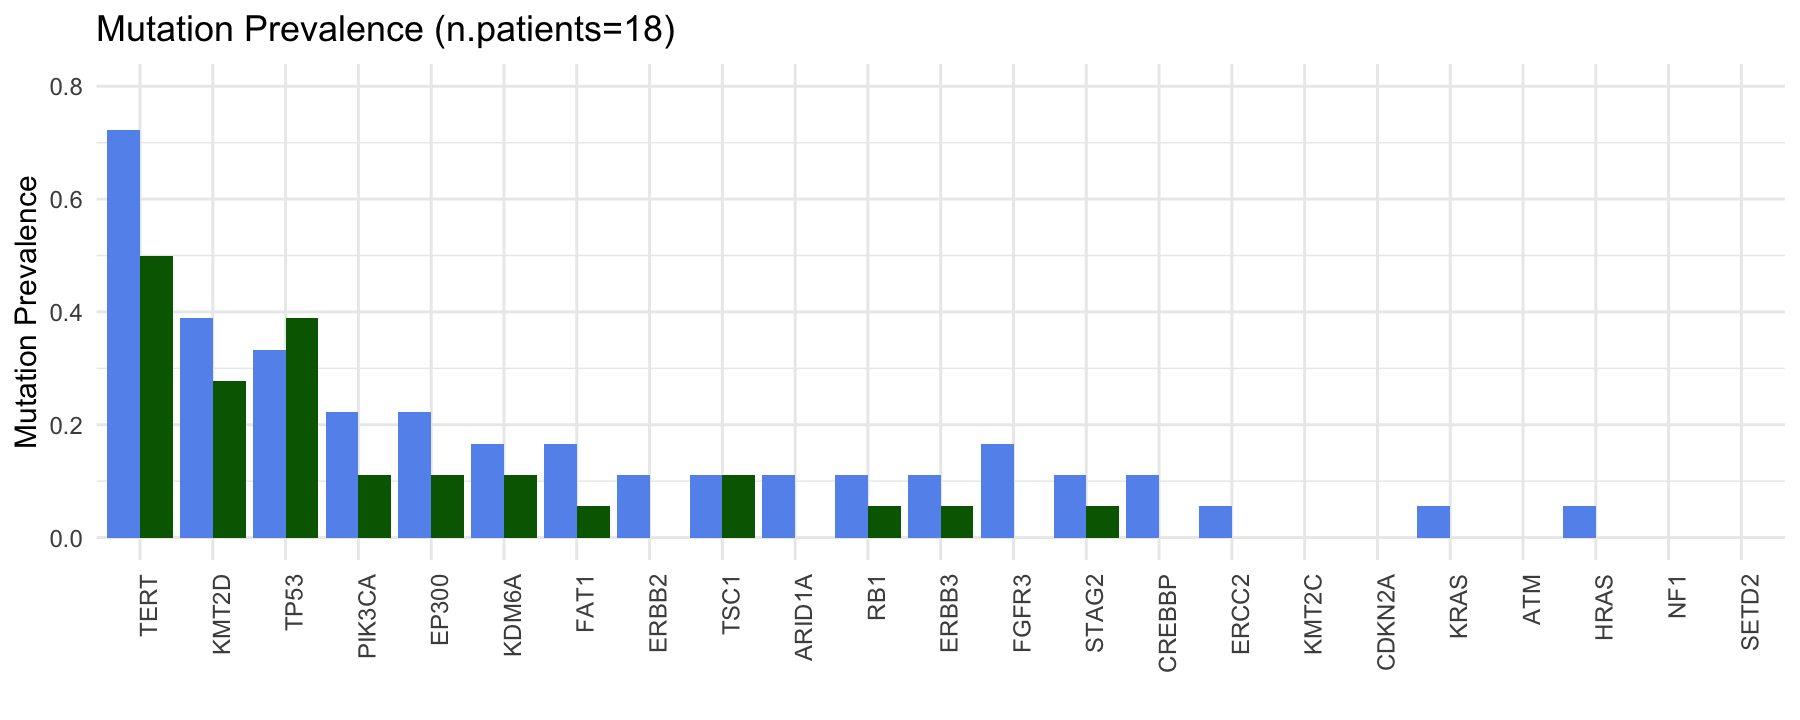

[1] 6


[1] 51

pdf 
  2

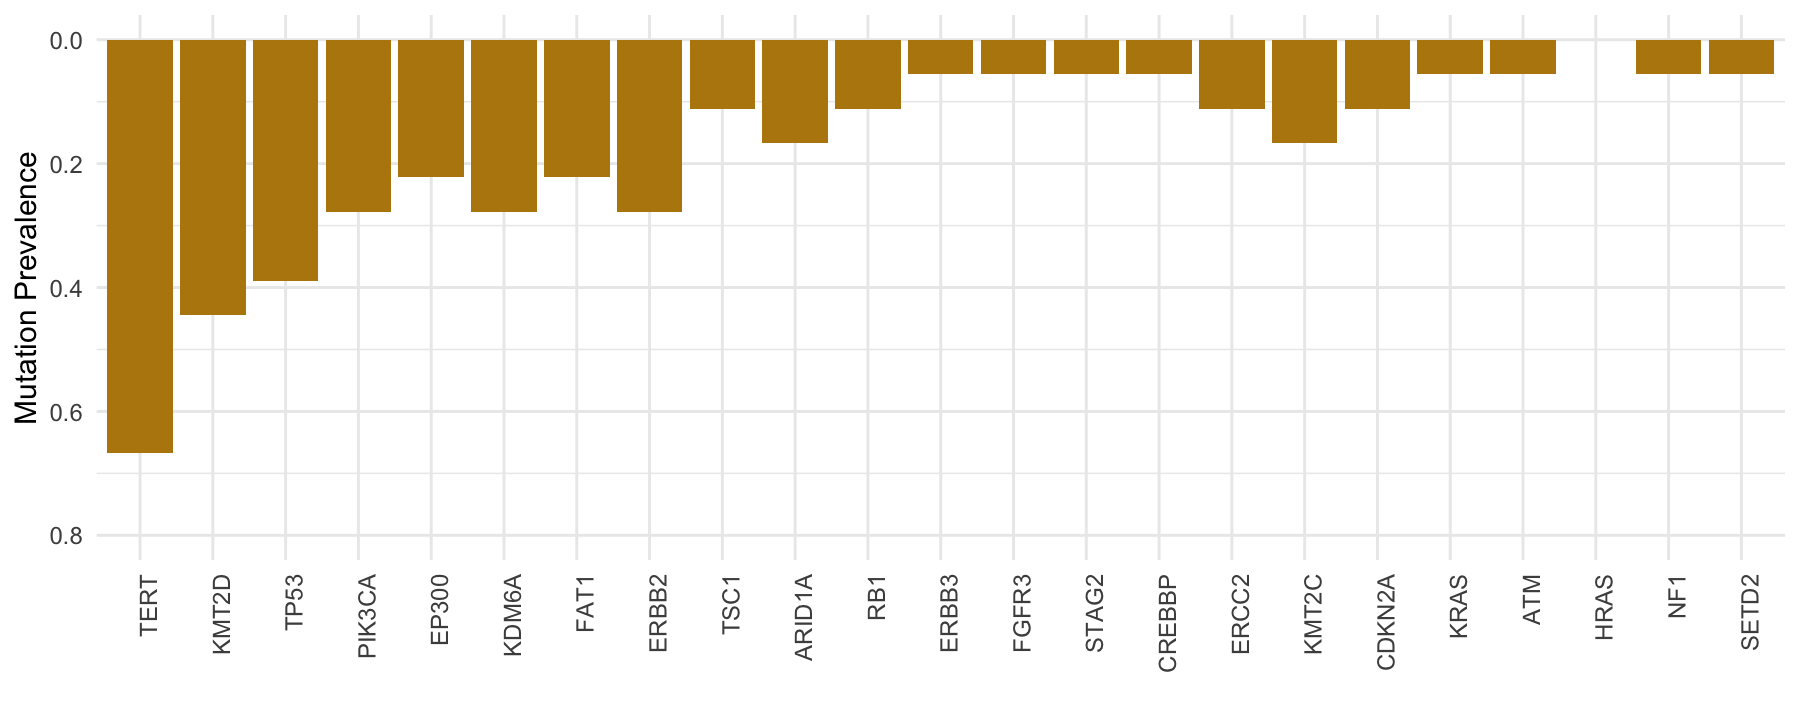

[1] 12


[1] 60

pdf 
  2

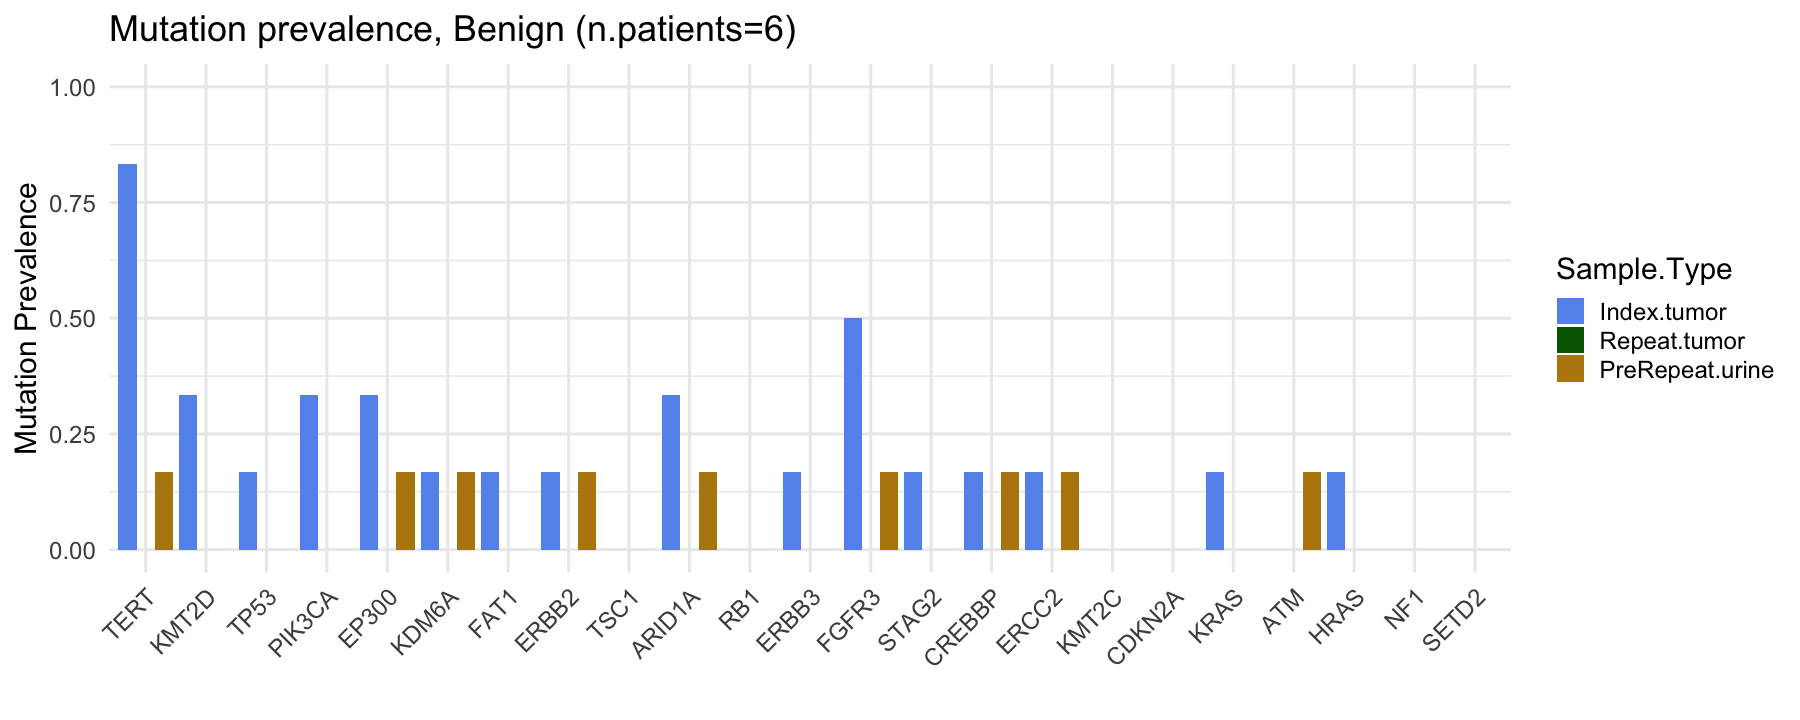

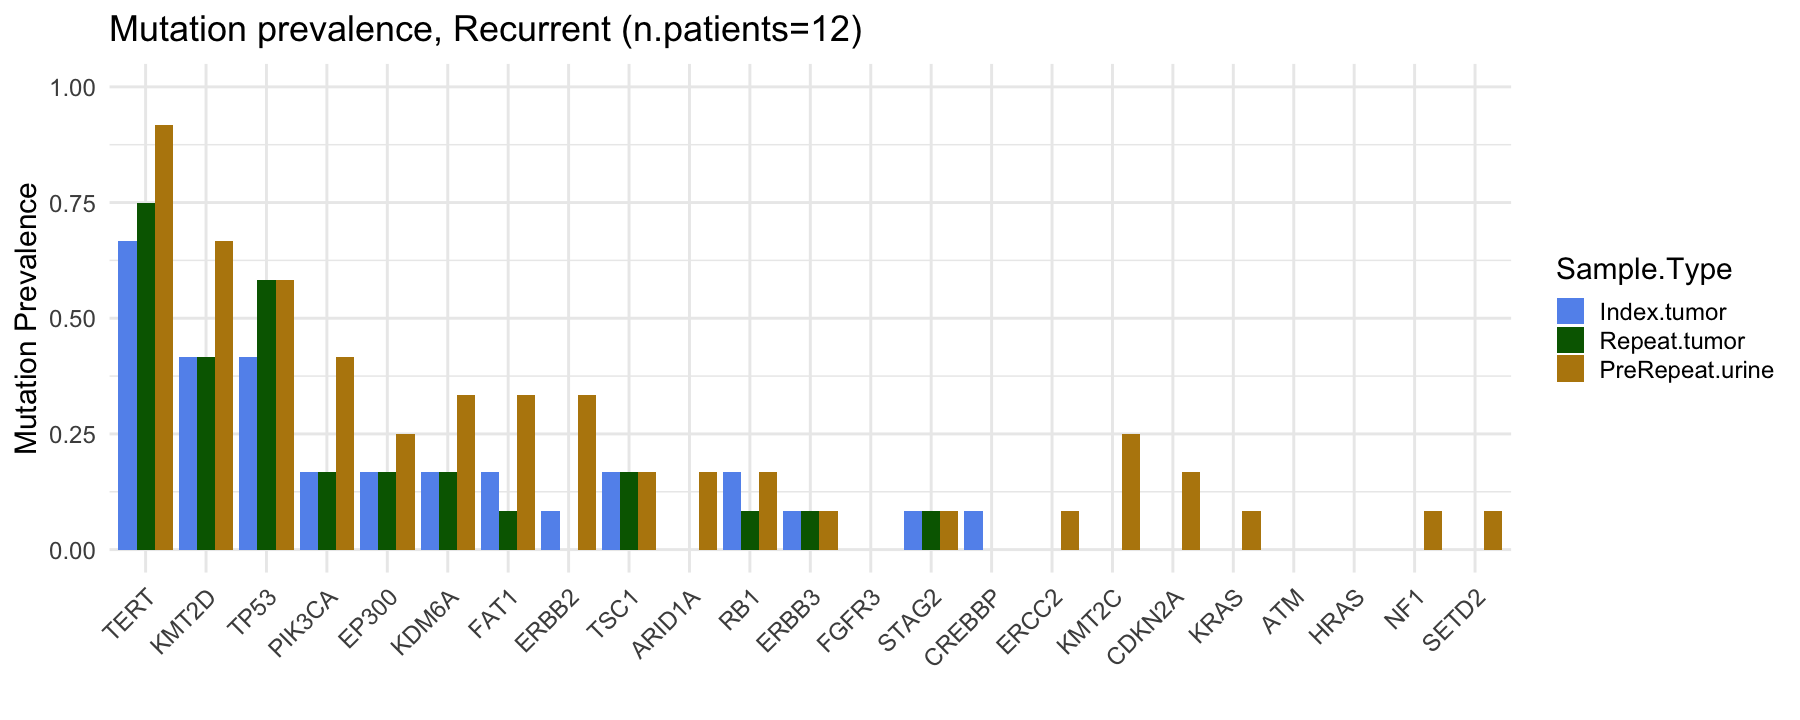

In [102]:
# Patients with PBMC ONLY wes data and 3 baselines - 18
# SNV here - do one for CNV ??

samples.ind_rep_urine_paired = samples.ind_rep_urine_paired %>% filter(has.pbmc.wes=="TRUE")
nrow(samples.ind_rep_urine_paired)/3

gene.order = readRDS("./ms_prevalence_gene_order.rds")
gene.order

## upper/lower sample split barplot
options(repr.plot.width=15, repr.plot.height=6)
ven.colors = c("RepeatTURBT_tissue"="darkgreen",
             "IndexTURBT_tissue"="cornflowerblue",
            "Pre-RepeatTURBT_urine"="darkgoldenrod")
plt.colors = ven.colors
names(plt.colors) = c("Repeat.tumor","Index.tumor","PreRepeat.urine")
plt.colors = plt.colors[c("Index.tumor","Repeat.tumor","PreRepeat.urine")] # set order

variants.sel = all.snv %>% filter(SampleID.short %in% samples.ind_rep_urine_paired$SampleID.short) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat") # just to make sure
n.pats = length(unique(samples.ind_rep_urine_paired$PatientID))
print(n.pats)
table(variants.sel$SampleType, variants.sel$StudyVisit)
table(variants.sel$VariantType)
plot.data = variants.sel %>% filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats) %>%
                mutate(total.mutated = Index.tumor + Repeat.tumor + PreRepeat.urine)
gene.order = plot.data$SYMBOL[order(plot.data$total.mutated, decreasing=TRUE)]
#saveRDS(gene.order, "ms_prevalence_gene_order.rds")

########################

####### upper plot
plot.data.up = plot.data %>% select(-PreRepeat.urine,-total.mutated) %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(SYMBOL=factor(SYMBOL, levels=gene.order, ordered=TRUE)) %>%
                arrange(SYMBOL, Sample.Type)
#head(plot.data.up)
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_UpperPlt_wPBMC_{Sys.Date()}.jpg"), width=14, height=6, res=300, units = "in")
gg <- ggplot(plot.data.up, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1),legend.position = "none") +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation Prevalence (n.patients={n.pats})")) +
        ylim(c(0,0.8)) +
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors)
show(gg)
dev.off()
show(gg)
##### lower plot
plot.data.down = plot.data %>%
                mutate(SYMBOL=factor(SYMBOL, levels=gene.order, ordered=TRUE)) %>%
                arrange(SYMBOL)
#head(plot.data)
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_lowerPlt_wPBMC_{Sys.Date()}.jpg"), width=14, height=6, res=300, units = "in")
gg <- ggplot(plot.data.down, aes(x=SYMBOL, y=PreRepeat.urine, fill="PreRepeat.urine")) +
        geom_bar(stat = "identity") + 
        scale_y_continuous(trans = "reverse") +
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1), legend.position = "none") +
        labs(x="", y="Mutation Prevalence") +
        ylim(c(0.8,0)) +
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors)
show(gg)
dev.off()
show(gg)

################### benign and recur patients together in one barplot
options(repr.plot.width=15, repr.plot.height=6)

#### set group - BENIGN
benign="TRUE"
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_benignPatients_wPBMC_{Sys.Date()}.jpg"), width=15, height=6, res=300, units = "in")

n.pats = length(unique(samples.ind_rep_urine_paired$PatientID[samples.ind_rep_urine_paired$benign==benign]))
print(n.pats)
sids = samples.ind_rep_urine_paired$SampleID.short[samples.ind_rep_urine_paired$benign==benign]
variants.sel = all.snv %>% filter(SampleID.short %in% sids) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat")
plot.data = variants.sel %>% mutate(SYMBOL = factor(SYMBOL, levels=gene.order)) %>%
                filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats)
plot.data.all = plot.data %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor","PreRepeat.urine"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(Sample.Type = factor(Sample.Type, levels=c("Index.tumor","Repeat.tumor","PreRepeat.urine")))
                
nrow(plot.data.all)
### plot
gg <- ggplot(plot.data.all, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation prevalence, {ifelse(benign=='TRUE','Benign','Recurrent')} (n.patients={n.pats})")) +
        ylim(c(0,1)) + 
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors, drop=FALSE) +
        scale_x_discrete(drop=FALSE) # keep missing factor levels
show(gg)
dev.off()
show(gg)

#### set group
benign="FALSE"
jpeg(glue("Manuscript/plots/Mutation_prevalence_barplot_recurPatients_wPBMC_{Sys.Date()}.jpg"), width=15, height=6, res=300, units = "in")
# benign="TRUE"
# jpeg(glue("Conferences/ASCO/ASCO_2024/Mutation_prevalence_barplot_benignPatients_{Sys.Date()}.jpg"), width=15, height=6, res=300, units = "in")

n.pats = length(unique(samples.ind_rep_urine_paired$PatientID[samples.ind_rep_urine_paired$benign==benign]))
print(n.pats)
sids = samples.ind_rep_urine_paired$SampleID.short[samples.ind_rep_urine_paired$benign==benign]

##### data #####
variants.sel = all.snv %>% filter(SampleID.short %in% sids) %>%
                select(-SampleType, -StudyVisit, -PatientID) %>% 
                left_join(samples.ind_rep_urine_paired %>% select(SampleID.short, StudyVisit, SampleType, PatientID, benign, has.pbmc.wes), by="SampleID.short")
variants.sel = variants.sel  %>% filter(SampleType != "buffy_coat")
plot.data = variants.sel %>% mutate(SYMBOL = factor(SYMBOL, levels=gene.order)) %>%
                filter(SYMBOL %in% nmibc.genes$Name) %>% 
                group_by(SYMBOL) %>%
                summarize(Index.tumor = length(unique(PatientID[StudyVisit=="IndexTURBT"]))/n.pats,
                          Repeat.tumor = length(unique(PatientID[StudyVisit=="RepeatTURBT"]))/n.pats,
                          PreRepeat.urine = length(unique(PatientID[StudyVisit=="Pre-RepeatTURBT"]))/n.pats)
plot.data.all = plot.data %>% 
                pivot_longer(cols = c("Index.tumor","Repeat.tumor","PreRepeat.urine"), values_to = "mutation.freq", names_to = "Sample.Type") %>%
                mutate(Sample.Type = factor(Sample.Type, levels=c("Index.tumor","Repeat.tumor","PreRepeat.urine")))
                
nrow(plot.data.all)
### plot
gg <- ggplot(plot.data.all, aes(x=SYMBOL, y=mutation.freq, fill=Sample.Type)) +
        geom_bar(stat = "identity", position = position_dodge()) + 
        theme_minimal(base_size=18) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        labs(x="", y="Mutation Prevalence", title=glue("Mutation prevalence, {ifelse(benign=='TRUE','Benign','Recurrent')} (n.patients={n.pats})")) +
        ylim(c(0,1)) + 
        scale_fill_manual(breaks = names(plt.colors), values=plt.colors, drop=FALSE) +
        scale_x_discrete(drop=FALSE) # keep missing factor levels
show(gg)
dev.off()

show(gg)

## OLD CODE: oncoplot of concordant urine/index mutations (only BEACON MRD markers and pathogenic hotspot panel variants, for AUA)

In [181]:
df_snv1 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00252_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv2 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00253_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")
df_snv3 = read.csv("./data/Urine-UCP/Pipeline_out_files_by_WO/WOP00254_PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short.csv")

df_snv = standardize_names(rbind(df_snv1,df_snv2,df_snv3)) %>% mutate(SampleID.short = make_SIDshort(sampleNames))
write.csv(df_snv, "./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_variants_filtered_clinicOnly_short_urine.csv", row.names=F)

print("summary")

df_all_vars = df_snv %>%  
    group_by(SampleID.short) %>% summarize(all.mutations.clinicOnly=n())

df_good_vars = df_snv %>% 
    filter(finalKeep %!in% c("FALSE","lowConfidence"),
                             grepl("somatic", VariantType, ignore.case=T)) %>%
    group_by(SampleID.short) %>% summarize(good.mutations.clinicOnly=n())

df_all_probes = df_snv %>% filter(wl.tier=="T00") %>%
    group_by(SampleID.short) %>% summarize(detected.probes.clinicOnly=n())

df_good_probes = df_snv %>% 
                            filter(finalKeep %!in% c("FALSE","lowConfidence"),
                                   grepl("somatic", VariantType, ignore.case=T)) %>%
                            filter(wl.tier=="T00") %>%
   group_by(SampleID.short) %>% summarize(good.detected.probes.clinicOnly=n())

df_summary = df_all_vars %>% full_join(df_good_vars, by="SampleID.short") %>% 
                             full_join(df_all_probes, by="SampleID.short") %>% 
                             full_join(df_good_probes, by="SampleID.short") %>% 
                             left_join(mrd.table, by="SampleID.short") %>%
                             left_join(df_clin %>% select(PatientID, is.repeat.pos), by="PatientID") %>% 
                             filter(StudyVisit %!in% c("Post TURBT","Surveillance 1"),
                                    SampleType %in% c("Urine","UCP")) %>%
                             relocate(PatientID, SampleID.short, SampleType, StudyVisit, is.repeat.pos, MRD.call)
df_summary ## MRD negative calls : 016 (true negative) and 021 (false negative, TF=0.00)

write.csv(df_summary, "./data/Urine-UCP/BEACON_pre_repeat_urine_mutaiton_counts_02172023.csv", row.names=F)

[1] "WARN: Missing: PatientID or SubjectID"
[1] "WARN: Missing: trialVisitNum or StudyVisit"
[1] "WARN: Missing: SampleType or SpecimenType"
[1] "summary"


PatientID,SampleID.short,SampleType,StudyVisit,is.repeat.pos,MRD.call,all.mutations.clinicOnly,good.mutations.clinicOnly,detected.probes.clinicOnly,good.detected.probes.clinicOnly,N.baseline.muts.detected.mrdInfo,N.personal.probes.detected.mrdInfo,MRD.score,TF.dynamic.muts.mrdInfo,TF.dynamic.highqual.muts.mrdInfo
<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
NMIBC010,P217590,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,38,40,38,39,36,9.25,0.677,0.1625357483
NMIBC005,P217591,Urine,Pre-Repeat TURBT,TRUE,TRUE,41,40,34,34,27,29,2.50,0.705,0.3306003890
NMIBC035,P217592,Urine,Pre-Repeat TURBT,TRUE,TRUE,40,40,36,36,40,36,36.00,0.683,0.0579642593
NMIBC009,P217594,Urine,Pre-Repeat TURBT,FALSE,TRUE,38,32,34,31,33,30,31.50,0.380,0.0072417228
NMIBC019,P217595,Urine,Pre-Repeat TURBT,FALSE,TRUE,54,29,53,28,38,36,29.00,0.702,0.0005027954
NMIBC016,P217596,Urine,Pre-Repeat TURBT,FALSE,FALSE,26,NA,26,NA,6,6,1.50,0.589,0.0000000000
NMIBC021,P219768,Urine,Pre-Repeat TURBT,TRUE,FALSE,32,22,32,22,2,2,1.00,0.281,0.0000000000
NMIBC003,P219770,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,77,69,69,72,64,8.75,0.643,0.6641799480
NMIBC013,P219771,Urine,Pre-Repeat TURBT,TRUE,TRUE,78,67,75,65,72,70,68.50,0.676,0.0039131614


In [78]:
unique(df_qc$StudyVisit)
unique(df_qc$SampleType)

df_clin_annot = df_clin %>% mutate(#SampleType2 = "Tissue",
           Index.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Index.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2")),
           Repeat.Stage=factor(gsub("Tis only (do not select if other histology present)","Tis",Repeat.Stage), levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Index.Stage) %>% 
    select(#"Tumor_Sample_Barcode", 
           "Smoking.Status", "Sex",
           "Previous history of NMIBC", "Prev.IV.Therapy",
           "Index.Stage", 'Index.CIS', "Repeat.Stage","Repeat.CIS","PatientID", "is.repeat.pos")


[1] "IndexTURBT"       "RepeatTURBT"      "Pre-Repeat TURBT" "Post TURBT"      
[5] "Surveillance 1"

[1] "FFPE"   "PBMC"   "Urine"  "Plasma" "UCP"

In [131]:
# select samples with qc!="Fail", has.Index, has MRD results even if no variants, 
source("~/Desktop/puffin/R/format_as_MAF.R")

df_ffpe_index = df_qc %>% filter(SampleType=="FFPE", StudyVisit=="IndexTURBT")
nrow(df_ffpe_index)
df_pre_urine_ucp = df_qc %>% filter(SampleType %in% c("Urine","UCP"), 
                                    StudyVisit=="Pre-Repeat TURBT",
                                    SampleID.short %in% df_mrd$SampleID.short,
                                    PatientID %in% df_ffpe_index$PatientID) %>%
                         left_join(df_clin_annot, by="PatientID") %>% 
                         rename("Smoking.Status"="Smoking.Status",
                                "Prev.History.NMIBC"="Previous history of NMIBC") %>%
                         mutate(across(everything(), as.character))
                         
# select variants
df_snv_sel = df_snv %>% filter(SampleID.short %in% df_pre_urine_ucp$SampleID.short, 
                               wl.tier=="T00") %>%
                        left_join(df_pre_urine_ucp, by="SampleID.short")

# must be a line in the maf snv data for all samples to include zero variant samples in plot
df_snv_selected_maf = format_as_MAF(df_snv_sel, df_pre_urine_ucp, # with df_samples input, includes 0 var samples
                                    variant.type="snv")
unique(df_snv_selected_maf$Tumor_Sample_Barcode)


[1] 11

Warning message in if (is.na(df_samples)) {:
“the condition has length > 1 and only the first element will be used”


[1] "Selected snvs: 399"


[1] "NMIBC033_Pre-Repeat TURBT_UCP"   "NMIBC021_Pre-Repeat TURBT_Urine"
 [3] "NMIBC003_Pre-Repeat TURBT_Urine" "NMIBC013_Pre-Repeat TURBT_Urine"
 [5] "NMIBC014_Pre-Repeat TURBT_Urine" "NMIBC010_Pre-Repeat TURBT_Urine"
 [7] "NMIBC005_Pre-Repeat TURBT_Urine" "NMIBC035_Pre-Repeat TURBT_Urine"
 [9] "NMIBC009_Pre-Repeat TURBT_Urine" "NMIBC019_Pre-Repeat TURBT_Urine"
[11] "NMIBC016_Pre-Repeat TURBT_Urine"

In [ ]:
## it seems that all urine variants were filtered out for patient NMIBC016
names(df_snv_sel)
df_snv_sel %>% filter(grepl('NMIBC016', PatientID)) %>% relocate(PatientID, SampleType, VariantType, finalKeep)

## NMIBC-021 had 2 variants detected, but had MRD.score=1.0

In [132]:
# there must be a color for Variant_Classification that is N.A. for placeholder mutations
# filter out of plot using var_type_incl below

var_reduc_dict = list(Missense = c("missense_variant","missense_variant&splice_region_variant"),
                   Synonymous = c("synonymous_variant","stop_retained_variant"),
                   N.A. = c('downstream_gene_variant',"intergenic_variant", "N.A."),
                   Promoter = c("upstream_gene_variant"),
                   Truncating = c('frameshift_variant',
                                   'stop_gained',
                                   'start_lost',
                                   'splice_donor_variant',
                                   'stop_gained&splice_region_variant',
                                   'stop_retained_variant',
                                   'splice_acceptor_variant',
                                  "splice_region_variant&synonymous_variant",
                                  "splice_donor_variant",
                                   'stop_gained&frameshift_variant'),
                    Intronic = c("intron_variant","intron_variant&non_coding_transcript_variant"),
                    In_Frame = c('inframe_deletion','inframe_insertion'),
                    UTR_3p =c('3_prime_UTR_variant'),
                    UTR_5p =c('5_prime_UTR_variant'))

bgCol = "#CCCCCC" #default oncoplot bgdcol
var_color_vec = c(
    "Missense" = "darkgreen", 
    "Truncating" = "blue",
    "In_Frame" = "darkred",
    "UTR_5p" = "cyan3",
    "UTR_3p" = "pink",
    "Gain" = "black",
    "Loss" = "grey52",
    "Multi_Hit" = "grey39",
    "Intronic"="springgreen3",
    "Synonymous"="slateblue1",
    "Promoter"="indianred3",
    "N.A."= bgCol
)

df_snv_selected_maf$Variant_Classification = factor(df_snv_selected_maf$Variant_Classification)
levels(df_snv_selected_maf$Variant_Classification) <- var_reduc_dict

In [133]:
df_pre_urine_ucp = df_pre_urine_ucp %>% unite(Tumor_Sample_Barcode, c(PatientID,StudyVisit,SampleType), remove=FALSE)

var_type_include = unique(df_snv_selected_maf$Variant_Classification[df_snv_selected_maf$Variant_Classification!="N.A."])

dat <- read.maf(df_snv_selected_maf, 
                cnTable = NULL, 
                vc_nonSyn = var_type_include, 
                clinicalData = df_pre_urine_ucp)

-Validating
--Found  5  variants with no Gene Symbols
--Annotating them as 'UnknownGene' for convenience
--Non MAF specific values in Variant_Classification column:
  Missense
  Truncating
  Synonymous
  Intronic
  N.A.
  UTR_3p
  In_Frame
  Promoter
--Non MAF specific values in Variant_Type column:
  SNV
  deletion
  insertion
  substitution
  NA
-Silent variants: 6 
-Summarizing
-Processing clinical data
-Finished in 0.093s elapsed (0.049s cpu) 


In [145]:
# reference oncoplot (squares only) with all samples

#pdf('./AUA/Oncoplot_abstract2_MRD_11012022.pdf', width=15, height = 20)
pdf('./ASCO_GU/Beacon_Oncoplot_02152023.pdf', width=15, height = 25)

options(repr.plot.width=13, repr.plot.height=20)

#sample_type_cols = c("Urine"="darkgoldenrod1", "UCP"="darkgoldenrod3")

# for sample ordering
df_pre_urine_ucp = df_pre_urine_ucp %>% mutate(Repeat.Stage = factor(Repeat.Stage, levels=c("T0","Tis","TaLG","TaHG","T1",">=T2"))) %>%
    arrange(Repeat.Stage, Index.Stage)
# PID_cols = colorRamps::primary.colors(n=length(df_pre_urine_ucp$PatientID))
# names(PID_cols) = df_pre_urine_ucp$PatientID

clin_cols = list(#SampleType=sample_type_cols, 
                 Sex=sex_cols, 
                 Smoking.Status=smoking_cols, 
                 Index.Stage=stage_cols,
                 Repeat.Stage=stage_cols,
                 Index.CIS=CIS_cols,
                 Repeat.CIS=CIS_cols,
                 Prev.History.NMIBC=history_cols,
                Prev.IV.Therapy=IVT_cols#,
                #PatientID=PID_cols
)

# must be a line in the maf snv data for all samples to include zero variant samples here
# all variant_classifications have to be in the var_color_vec for ANY colors to show up
oncoplot(dat, top=40, sortByMutation=F, showTitle = F, colors = var_color_vec, removeNonMutated = F, fill=T, barcode_mar = 8,
         showTumorSampleBarcodes=F, fontSize = 1.5, SampleNamefontSize = 1, sampleOrder = df_pre_urine_ucp$Tumor_Sample_Barcode,
          clinicalFeatures = c(#"SampleType"),
               "Repeat.Stage",
              "Index.Stage",
              "Repeat.CIS",
             "Index.CIS", 
             "Prev.History.NMIBC",
             "Prev.IV.Therapy",
             "Smoking.Status",
             "Sex"#,
#             "PatientID",
            #"is.repeat.pos"
         ),
        anno_height=3, gene_mar=12,
        drawRowBar=F, drawColBar=F, annotationColor=clin_cols,legendFontSize=3, annotationFontSize=1.5)


dev.off()

pdf 
  2

## compare concordance between BEACON urine and WES ffpes

In [103]:
# high conf variants

df_all_qc = read.csv(file = "./data/PRDC-MOFFITT-NMIBC-22001_NGSQC_all_2022-09-23_urine_ucp_pbmc_ffpe.csv",as.is=T) %>% filter(QC_Status!="Fail", Specimen_type!="Buffy Coat") %>%
                rename("StudyVisit"=trialVisitNum, "SampleType"=Specimen_type) %>%
                mutate("SampleID.short"=make_SIDshort(SampleID), "PatientID"=fix_PIDs(PatientID))

# Variant Short Marked inputs
# all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_supernatant_marked.csv") 
all.urine.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_supernatant_marked.csv",
                        as.is=T)
#all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-01_urine cell pellet_marked.csv")
all.ucp.snv = read.csv("./data/Urine-UCP/Urine_post_analysis/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-12-01_urine cell pellet_marked.csv",
                      as.is=T)
## FFPE variants, unpatched  ## use filtered?, or use Patched file here instead?
#all.ffpe.snv = read.csv("./data/FFPE_WES/PRDC-MOFFITT-NMIBC-22001_Variant_all_2022-12-06_tissue_marked.csv")
#all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_FFPE_filtered_double_patched.csv"
all.ffpe.snv = read.csv("./data/FFPE_WES/Peter_analysis _files/WOP00249_WOP00250_PRDC-MOFFITT-NMIBC-22001_Variant_short_all_2022-09-23_filtered.csv",
                        as.is=T)

# beacon.markers = all.ffpe.snv %>% filter(Selected %in% c("Yes","Core"))
# You need to run the postAnalysis R script I provided for MRD panel design. 
# (/home/pdu/Projects/TechEval/Rscript_templates/MRD_analysis_template_V2.R)
# need also the hotspot panel regions
# can run on existing _filtered.csv file or find peters copy here:
# /home/pdu/Projects/OtherAnalysis/MOFFITT/PRDC-MOFFITT-NMIBC-MIBC-22001

# cols <- intersect(names(all.urine.snv), names(all.ffpe.snv))
# all.snv_unfilt = rbind(beacon.markers[,cols], all.ucp.snv[,cols], all.ffpe.snv[,cols]) %>%
#             distinct()

# all.snv = all.snv_unfilt %>% filter(grepl("somatic", VariantType, ignore.case=T), !(finalKeep %in% c("Low Confidence", "FALSE"))) %>%
#             mutate("SampleID.short"=make_SIDshort(sampleNames)) %>%
#             distinct() %>%
#             group_by(PatientID, VariantID) %>% mutate(CONCORDANT=(n()>1)) %>% ungroup()
# head(all.snv)
# # write.table(all.snv, "./data/Urine-UCP/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.txt", sep="\t",
# #             row.names=F, col.names=T, quote=F)

# nrow(all.snv)
# table(df_all_qc$SampleType)


In [46]:
out_bed = all.snv %>% mutate(zero = 0, dot = ".") %>% select(seqnames, start, end, VariantID, VariantFreq, PatientID, SpecimenType, trialVisitNum, SampleID.short)
write.table(out_bed, "./data/all_snv_ffpe_urine_ucp_short_somatic_12212022.bed", sep="\t", row.names=F, col.names=F, quote=F)

In [45]:
# run on server  ## change this to the hotspot panel PREDICINE_MRD_V1
# library(rtracklayer)
# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEATLAS_V2")
# export(tmp, 'ATLAS_V2_target_regions_12012022.bed')

# tmp <- NGSutilities::getPanelTargetRegion("PREDICINEWES_V1") # couldnt transform this one to bed
# export(tmp, 'PREDICINEWES_V1_target_regions_12022022.bed')

# maybe overlap VRanges objects on server before export??
atlas.bed = read.csv("../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed", sep="\t",
                     stringsAsFactors=F, header=F)
names(atlas.bed) <- c("chr","start","stop","name","zero","dot")
tail(atlas.bed)

# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

,chr,start,stop,name,zero,dot
,<chr>,<int>,<int>,<chr>,<int>,<chr>
23280,chrY,2655606,2655727,chrY:2655607:2655727,0,.
23281,chrY,2847966,2848086,chrY:2847967:2848086,0,.
23282,chrY,6738492,6738612,chrY:6738493:6738612,0,.
23283,chrY,19490154,19490274,chrY:19490155:19490274,0,.
23284,chrY,26764543,26764664,chrY:26764544:26764664,0,.
23285,chrY,26764603,26764724,chrY:26764604:26764724,0,.


In [ ]:
# run:
# bedtools intersect -a all_snv_ffpe_urine_ucp_short_somatic_12212022.bed -b ../../../Translational_Science/Methods/ATLAS_V2_target_regions_12012022.bed -wa > NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed 

In [17]:
all.snv_atlas = read.csv("./data/NMIBC_ATLAS_snvs_urine_ucp_ffpe_12212022.bed", sep="\t", header=F) 
names(all.snv_atlas) <- c("chr","start","end","VariantID","VariantFreq","PatientID","SampleType","StudyVisit", "SampleID.short")
all.snv_atlas = all.snv_atlas %>% distinct(SampleID.short, VariantID, .keep_all=T) # 655 variants
nrow(all.snv_atlas)
head(all.snv_atlas)

[1] 655

,chr,start,end,VariantID,VariantFreq,PatientID,SampleType,StudyVisit,SampleID.short
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,chr1,155874285,155874285,chr1:155874285:A:C,1.12274980,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
2,chr1,9781506,9781506,chr1:9781506:G:A,0.52239031,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
3,chr12,25398285,25398285,chr12:25398285:C:T,0.01697361,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
4,chr12,49426213,49426224,chr12:49426213:TGCAGCTGCAGA:T,1.73946203,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
5,chr13,103524589,103524589,chr13:103524589:C:T,1.10524994,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592
6,chr16,2094797,2094797,chr16:2094797:C:T,0.40810100,NMIBC035,Supernatant,Pre-Repeat TURBT,P217592


In [182]:
df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(intersect(df_pre_urine$PatientID, df_repeatT$PatientID), df_indexT$PatientID)

df_samples = rbind(df_pre_urine, df_repeatT, df_indexT) %>% filter(PatientID %in% patients)
table(df_samples$SampleType)


      Supernatant            Tissue Urine Cell Pellet 
                5                12                 1 

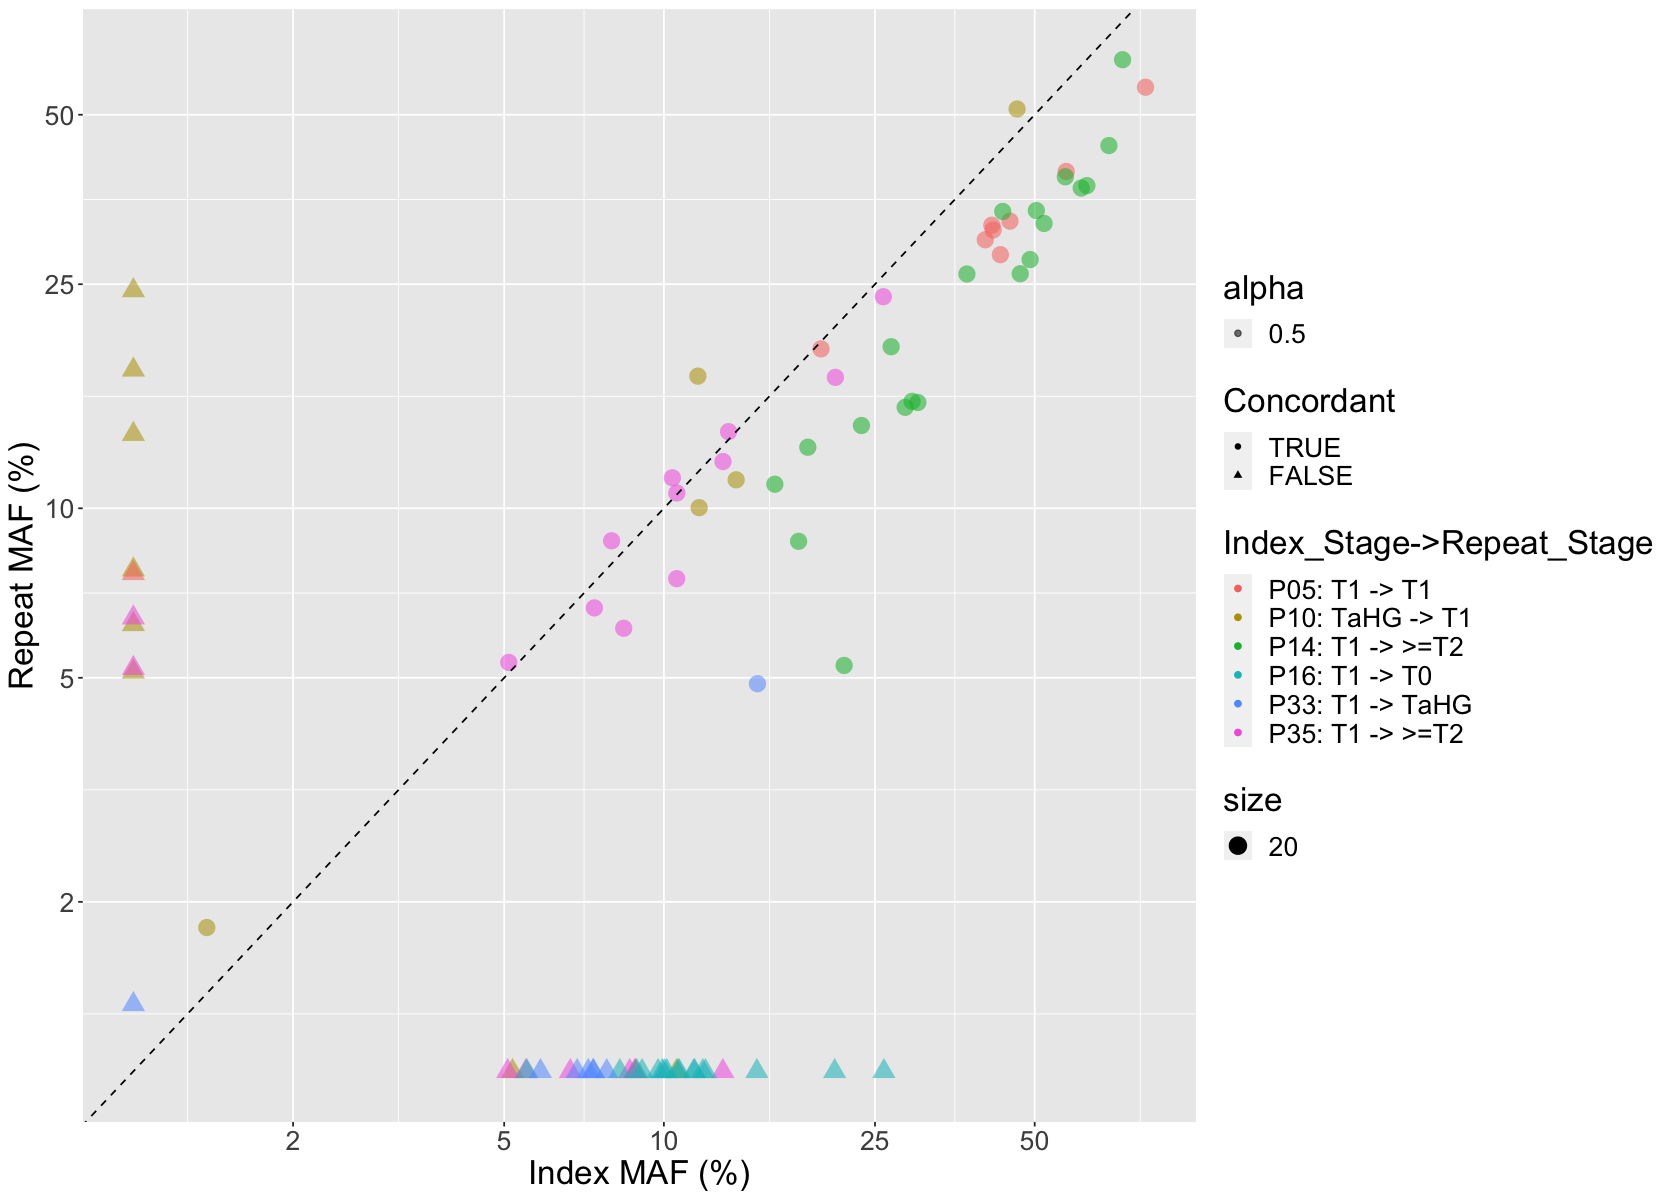

In [149]:
# index vs repeat frequency plot for ATLAS variants only, UNPATCHED, variant_short_all

# Unpatched
df_indexT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="IndexTURBT")
df_repeatT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, StudyVisit=="RepeatTURBT")
df_urineT = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short, SampleType %in% c("Supernatant", "Urine Cell Pellet"))

LOD = 1.0

df_compare_freq = df_indexT %>% full_join(df_repeatT, by=c("PatientID","VariantID"), suffix=c(".index",".repeat")) %>% 
    mutate(VariantFreq.index=ifelse(is.na(VariantFreq.index), LOD, VariantFreq.index),
           VariantFreq.repeat=ifelse(is.na(VariantFreq.repeat), LOD, VariantFreq.repeat),
           Concordant=factor((VariantFreq.repeat!=LOD & VariantFreq.index!=LOD), levels=c(TRUE, FALSE))
           #Patched=ifelse(is.na(Patched.index), Patched.repeat, Patched.index),
           #PatientID=ifelse(is.na(PatientID.index), PatientID.repeat, PatientID.index)
          ) %>%
    left_join(df_clin %>% select(Index.Stage,Repeat.Stage,PatientID), by="PatientID") %>%
           mutate("Patient"=sapply(PatientID, function(x) str_sub(x,-2,-1)), 
                  "Index_Stage->Repeat_Stage"=paste0("P",Patient,": ",Index.Stage," -> ",Repeat.Stage))


#pdf("./ASCO_GU/MAFs_index_vs_repeat_ATLAS_panel_only_12062022.pdf", height=10, width=12)
gg <- ggplot(df_compare_freq, aes(x=VariantFreq.index, y=VariantFreq.repeat, group=Concordant)) + 
        geom_point(aes(color=`Index_Stage->Repeat_Stage`, shape=Concordant, size=20, alpha=0.5)) +
        geom_abline(slope=1, intercept=c(0,0), linetype="dashed") +
        scale_y_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        scale_x_continuous(trans='log2', breaks=c(2.0, 5.0, 10.0, 25.0, 50.0)) +
        labs(x="Index MAF (%)", y="Repeat MAF (%)") +
        theme(text=element_text(size=20))

#show(gg)
#dev.off()
options(repr.plot.width=14, repr.plot.height=10)
show(gg)

[1] 219

[1] "index"


[1] 77

[1] "repeat"


[1] 55

[1] "urine/ucp"


[1] 87

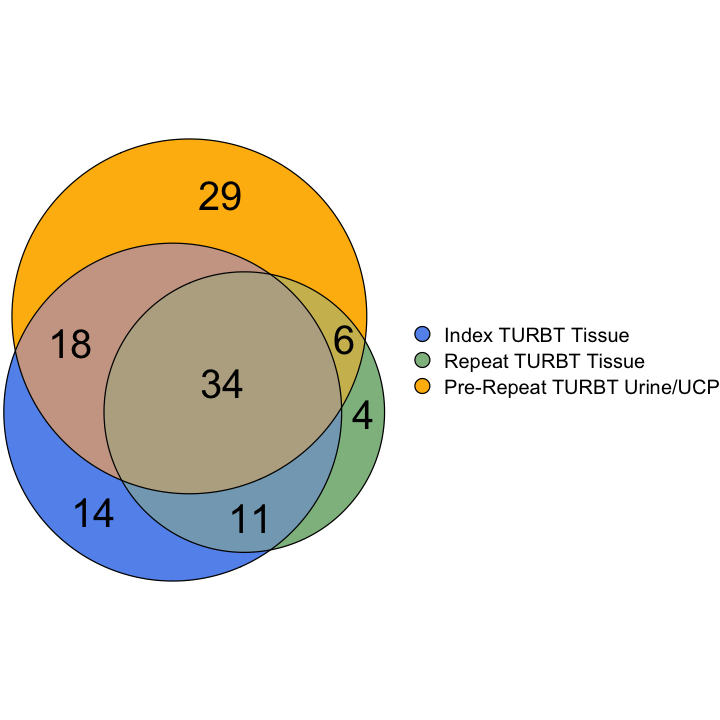

In [183]:
library(eulerr) # Unpatched

#pdf("./ASCO_GU/Venn_ATLAS_variants_12062022.pdf", width=5, height=5)
venn_variants = all.snv_atlas %>% filter(SampleID.short %in% df_samples$SampleID.short) %>%
                    distinct(SampleID.short, VariantID, .keep_all=T) %>%
                    mutate(label=paste0(PatientID, "_", VariantID)) 
                    
nrow(venn_variants)
index = venn_variants %>% filter(StudyVisit=="IndexTURBT")
print("index")
nrow(index)
repeat. = venn_variants %>% filter(StudyVisit=="RepeatTURBT")
print("repeat")
nrow(repeat.)
urine = venn_variants %>% filter(StudyVisit=="Pre-Repeat TURBT")
print("urine/ucp")
nrow(urine)
stopifnot(nrow(rbind(index,repeat.,urine))==nrow(venn_variants))

options(repr.plot.width=6, repr.plot.height=6)

v <- euler(list("Index TURBT Tissue"=index$label,  
             "Repeat TURBT Tissue"=repeat.$label,
             "Pre-Repeat TURBT Urine/UCP"=urine$label))
eulerr_options(padding = unit(5, "mm"))
plot(v,
     quantities = list(type = "counts", cex=2),
     #labels = list(cex=2.1),
     fills = list(fill = c("cornflowerblue", 
                           "darkseagreen", 
                           "darkgoldenrod1")
                  #alpha=0.6
                 ),
    legend = TRUE)
#dev.off()

In [19]:
unique(all.snv_atlas$SampleType)
unique(all.snv_atlas$StudyVisit)

[1] "Supernatant"       "Urine Cell Pellet" "Tissue"

[1] "Pre-Repeat TURBT" "Surveillance 1"   "Post TURBT"       "RepeatTURBT"     
[5] "IndexTURBT"


      Supernatant            Tissue Urine Cell Pellet 
                6                 7                 1 


      Supernatant            Tissue Urine Cell Pellet 
               10                11                 1 

[1] "NMIBC035"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC013"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


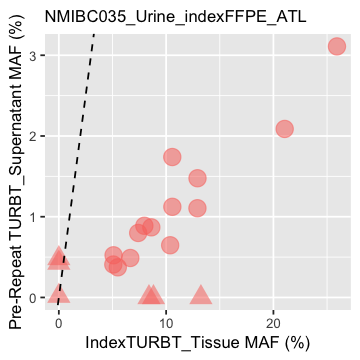

[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC005"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC016"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "WARN: No variants selected for one or both sample types."
[1] "NMIBC033"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC006"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC009"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC010"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC021"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC019"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC003"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC014"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "IndexTURBT_Tissue"            "Pre-Repeat TURBT_Supernatant"


Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "RepeatTURBT_Tissue"           "Pre-Repeat TURBT_Supernatant"
[1] "NMIBC001"
[1] "NMIBC018"


quartz_off_screen 
                2

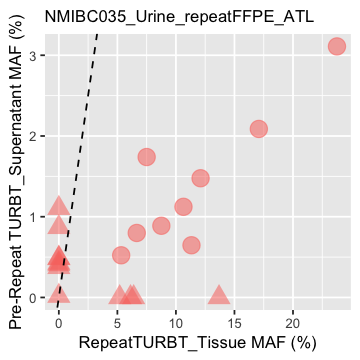

In [34]:
# MAF concordance scatters by patient prerepeat urine vs ffpe, ATLAS, unpatched ## swithch this to the MRD hotspot panel
library(gridExtra)
library(grid)
source("~/Desktop/puffin/R/compareMAFs.R")

df_pre_urine = df_all_qc %>% filter(StudyVisit=="Pre-Repeat TURBT")
df_repeatT = df_all_qc %>% filter(StudyVisit=="RepeatTURBT")
df_indexT = df_all_qc %>% filter(StudyVisit=="IndexTURBT")

patients = intersect(df_pre_urine$PatientID, df_repeatT$PatientID)
df_preurine_repeatT_samples = rbind(df_pre_urine, df_repeatT) %>% filter(PatientID %in% patients)
table(df_preurine_repeatT_samples$SampleType)

patients = intersect(df_pre_urine$PatientID, df_indexT$PatientID)
df_preurine_indexT_samples = rbind(df_pre_urine, df_indexT) %>% filter(PatientID %in% patients)
table(df_preurine_indexT_samples$SampleType)


plt.sz = 3
point.sz = 9
ncol = 2
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
# blank_scatter <- function(plot.title){
#     gg <- ggplot(data.frame(x=c(0,0), y=c(0,0)), aes(x=x, y=y)) + 
#            geom_point() +
#            ggtitle(plot.title) +
#             theme(plot.title=element_text(size=10), axis.text=element_blank(), axis.title=element_blank())
#     return(gg)
# }
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE
patients = unique(df_all_qc$PatientID)

# index vs. repeat
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_repeatTURBT_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_repeatTURBT_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
        
        
# urine vs index
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid,"_Urine_indexFFPE")
    if (pid %in% df_preurine_indexT_samples$PatientID){
        samples = unlist(df_preurine_indexT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples) %>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("IndexTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".1")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_indexFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()
    
    
# urine vs. repeat
plots = list()
for (pid in patients){
    plot.title=paste0(pid,"_Urine_repeatFFPE")
    if (pid %in% df_preurine_repeatT_samples$PatientID){
        samples = unlist(df_preurine_repeatT_samples %>% filter(PatientID==pid) %>% select(SampleID.short))
        pid.snv = all.snv_atlas %>% filter(SampleID.short %in% samples)%>%
                    mutate(SampleType=ifelse(SampleType=="Urine Cell Pellet","Supernatant", SampleType))
        pid.out = compareMAFs(pid.snv, selectors=c("RepeatTURBT_Tissue","Pre-Repeat TURBT_Supernatant"),
                                plot=plot.me, legend.position="none", plot.title=plot.title, point.sz=point.sz)
        plots[[paste0(pid,".2")]] = pid.out$plot
#     }else{
#         plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
}
# p <- do.call("grid.arrange", c(plots, ncol=ncol))
# #options(repr.plot.width=15, repr.plot.height=5*length(patients))
# #plot(p)
# pdf("./NMIBC_MAF_scatter_by_patient_Urine_vs_FFPEs_ATL_01102023.pdf", height=(plt.sz*length(patients)), width=plt.sz*ncol)
# plot(p)
# dev.off()

# one plot per page
pdf("./NMIBC_MAF_scatter_by_patient_Urine_repeatFFPE_01162023.pdf", onefile = TRUE, height=5, width=5)
for (p in names(plots)){
    show(plots[[p]])
}   
dev.off()


In [36]:
all.snv_out = all.snv_unfilt %>% mutate("in.ATLAS"=(VariantID %in% all.snv_atlas$VariantID))
write.table(all.snv_out, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked.tsv", sep="\t",
            row.names=F, col.names=T, quote=F)

# write.table(all.snv, "./data/PRDC-MOFFITT-NMIBC-22001_Variant_all_short_2022-12-06_tissue_urine_ucp_marked_somatic.tsv", sep="\t",
#             row.names=F, col.names=T, quote=F)

In [147]:
get_max_concord_maf2 <- function(all_snvs_atlas, ref_sample_types, ref_study_visit, df_qc){
    stopifnot(nrow(df_qc)>0)
    sample_data = list()
    # for each patient, extract preTURB urine/ucp variants
    for (pid in unique(df_qc$PatientID)){
        print(pid)
        df_pid = df_qc %>% filter(PatientID==pid, SampleType!="Buffy Coat")
        ref_sid = df_pid %>% filter(SampleType %in% ref_sample_types, StudyVisit==ref_study_visit)
        if (nrow(ref_sid) >0){
            if (nrow(ref_sid)>1){print(paste0("WARN: more than one ref sample: ",pid))}
            ref_sid = ref_sid$SampleID.short[1]
        }else{
            print(paste0("no ref. sample. skipping: ", pid))
            next
        }
        #print(ref_sid)
        df_ref_vars = all_snvs_atlas %>% filter(SampleID.short==ref_sid)
        n_ref_vars = nrow(df_ref_vars)
        
        df_sel_samples = df_qc %>% filter(PatientID==pid)
        for (sid.short in unique(df_sel_samples$SampleID.short)){
            sample_type = df_pid %>% filter(SampleID.short==sid.short) %>% select(SampleType)
            study_visit = df_pid %>% filter(SampleID.short==sid.short) %>% select(StudyVisit)
            n_sample_vars = nrow(all_snvs_atlas %>% filter(SampleID.short==sid.short))
    
            if (n_sample_vars == 0){
                sample_concord_var = 0
                n_concord_vars = 0
            }else{
                sample_concord_var = all_snvs_atlas %>% filter(SampleID.short==sid.short, VariantID %in% df_ref_vars$VariantID)
                n_concord_vars = nrow(sample_concord_var)
            }
            
            # for finding max MAF:
#             if (nrow(sample_concord_snvs > 0){
#                 max_cMAF = max(sample_concord_snv$altDepth / sample_concord_snv$totalDepth)
#                 #var_name = sample_concord_snv[sample_concord_snv$] TODO
#             }else{
#                 max_cMAF = 0
#             }
#             sample_data[[sid.short]] <- c(n_ref_snvs, n_concord_snvs, max_cMAF, sample_type, pid)
            sample_data[[sid.short]] <- c(n_ref_vars, n_sample_vars, n_concord_vars, sample_type, study_visit, pid)
            #print(length(sample_data))
            }
        }

    df_max_mafs = do.call(rbind, sample_data)
    df_max_mafs <- cbind(rownames(df_max_mafs), data.frame(df_max_mafs, row.names=NULL))
#     names(df_max_mafs) <- c("SampleID.short","n_ref_snvs", "n_concord_snvs", "max_cMAF", "SampleType", "PatientID")
    #names(df_max_mafs) <- c("SampleID.short","n_ref_vars", "n_sample_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    names(df_max_mafs) <- c("SampleID.short","n_ref_preUrine_snvs", "n_SID_vars", "n_concord_vars", "SampleType", "StudyVisit","PatientID")
    
    # attach cfDNA yields and collection day
    df_max_mafs2 = df_max_mafs %>% left_join(df_qc, by="SampleID.short") #%>% 
#       left_join(df_sid_to_day %>% select(-SampleType), by="SampleID.short") #%>%
      #left_join(df_qc %>% select(SampleID.short, NAYield), by="SampleID.short")
    
    #df_max_mafs2 = df_max_mafs2 %>% filter(n_ref_snvs!=0)
    #df_max_mafs2$amt_ctDNA = df_max_mafs2$NAYield * (df_max_mafs2$max_cMAF / 100) *1000
    #df_max_mafs2$log_amt_ctDNA = log(df_max_mafs2$amt_ctDNA + 1)
    
    return(df_max_mafs2)
    }

In [149]:
df_concord_counts2 = get_max_concord_maf2(all_snvs_atlas = all.snv_atlas,
                                         ref_sample_types= c("Supernatant", "Urine Cell Pellet"),
                                         ref_study_visit="Pre-Repeat TURBT",
                                         df_qc = df_all_qc) #all samples in project

df_concord_counts2

[1] "NMIBC035"
[1] "NMIBC013"
[1] "NMIBC005"
[1] "NMIBC016"
[1] "NMIBC033"
[1] "NMIBC006"
[1] "NMIBC009"
[1] "NMIBC010"
[1] "NMIBC021"
[1] "NMIBC019"
[1] "NMIBC003"
[1] "NMIBC014"
[1] "NMIBC001"
[1] "NMIBC018"


SampleID.short,n_ref_preUrine_snvs,n_SID_vars,n_concord_vars,SampleType.x,StudyVisit.x,PatientID.x,X,SampleID,Total.reads..M.,⋯,category,sampleFolder,Panel2.Target.unique.fragment.coverage,Panel2.Target.read.coverage,Panel2.Within.2.fold.....after.dedup,Panel2.Within.2.fold.....before.dedup,PatientID.y,externalSampleID,StudyVisit.y,Duplicated
<chr>,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<int>,<chr>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
P220085,36,23,19,Tissue,IndexTURBT,NMIBC035,1,P220085,260.0,⋯,RUO,P220085_220907,200,341,58.8,59.6,NMIBC035,06S22036059,IndexTURBT,FALSE
P220086,36,22,14,Tissue,RepeatTURBT,NMIBC035,6,P220086,245.0,⋯,RUO,P220086_220907,134,226,50.8,50.6,NMIBC035,06S22052900,RepeatTURBT,FALSE
P217592,36,36,36,Supernatant,Pre-Repeat TURBT,NMIBC035,31,P217592,113.0,⋯,RUO,P217592_221014,NA,NA,NA,NA,NMIBC035,06S22034638,Pre-Repeat TURBT,FALSE
P220076,83,140,79,Tissue,IndexTURBT,NMIBC013,2,P220076,257.0,⋯,RUO,P220076_220902,198,317,57.5,58.4,NMIBC013,06S22068063,IndexTURBT,FALSE
P219771,83,83,83,Supernatant,Pre-Repeat TURBT,NMIBC013,33,P219771,108.0,⋯,RUO,P219771_221014,NA,NA,NA,NA,NMIBC013,06S22021715,Pre-Repeat TURBT,FALSE
P219778,83,54,47,Supernatant,Surveillance 1,NMIBC013,34,P219778,102.0,⋯,RUO,P219778_221014,NA,NA,NA,NA,NMIBC013,06S22049794,Surveillance 1,FALSE
P220070,22,12,9,Tissue,RepeatTURBT,NMIBC005,3,P220070,251.0,⋯,RUO,P220070_220907,169,280,47.1,47.3,NMIBC005,06S22052895,RepeatTURBT,FALSE
P220069,22,11,9,Tissue,IndexTURBT,NMIBC005,5,P220069,245.0,⋯,RUO,P220069_220907,180,339,61.5,61.0,NMIBC005,06S22035975,IndexTURBT,FALSE
P217599,22,19,9,Supernatant,Post TURBT,NMIBC005,26,P217599,126.0,⋯,RUO,P217599_221014,NA,NA,NA,NA,NMIBC005,06S22023956,Post TURBT,FALSE


In [ ]:
# MAF scatters by patient
library(gridExtra)
library(grid)

plt.sz = 3
options(repr.plot.width=plt.sz, repr.plot.height=plt.sz)
blank_scatter <- function(plot.title){
    gg <- ggplot(data.frame(x=c(0,0),y=c(0,0)), aes(x=x, y=y)) + 
           geom_point() +
           ggtitle(plot.title)
    return(gg)
}
#blank_scatter <- grid.rect(gp=gpar(col="white", width=5, height=5))

plot.me = TRUE

patients = df_clin$PatientID
plots = list()
for (pid in patients){
    print(pid)
    plot.title=paste0(pid," urine_ffpe_WES+")
    if (pid %in% samples_paired_urine_ffpe$PatientID){
        print("urine vs. tissue")
        samples = unique(unlist(samples_paired_urine_ffpe %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_wes = all.snv_wes %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_wes, selectors=c("Cystectomy_FFPE","Pre Op_Urine"),
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".1")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".1")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_ffpe_ATLAS")
    if (pid %in% samples_paired_ffpe_plasma$PatientID){
        print("plasma vs. tissue")
        samples = unique(unlist(samples_paired_ffpe_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Cystectomy_FFPE","Pre Op_Plasma"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".2")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".2")]] = blank_scatter(plot.title)
    }
    
    plot.title=paste0(pid," plasma_urine_ATLAS")
    if (pid %in% samples_paired_urine_plasma$PatientID){
        print("urine vs. plasma")
        samples = unique(unlist(samples_paired_urine_plasma %>% filter(PatientID==pid) %>% select(SampleID)))
        print(samples)
        pid.snv_atlas = all.snv_inAtlas %>% filter(SampleID %in% samples)
        pid.out = compareMAFs(pid.snv_atlas, selectors=c("Pre Op_Plasma","Pre Op_Urine"), log.axes=TRUE,
                            plot=plot.me, legend.position="none", plot.title=plot.title)
        plots[[paste0(pid,".3")]] = pid.out$plot
    }else{
        plots[[paste0(pid,".3")]] = blank_scatter(plot.title)
    }
}

p <- do.call("grid.arrange", c(plots, ncol=3))
#options(repr.plot.width=15, repr.plot.height=5*length(patients))
#plot(p)

pdf("./MIBC_MAF_scatter_by_patient_01102023.pdf", height=plt.sz*length(patients), width=plt.sz*3)
plot(p)
dev.off()


In [ ]:
# prerepeat_pid n_variants type=unique,index_concordant,repeat_concordant ## need to make this based on percentages
# df_concord_counts_f = df_concord_counts[,1:7]
# pre_rep_counts = df_concord_counts_f %>% filter(StudyVisit.x!="Pre-Repeat TURBT")
# index_counts = df_concord_counts_f %>% filter(StudyVisit.x!="IndexTURBT")
# repeat_counts = df_concord_counts_f %>% filter(StudyVisit.x!="RepeatTURBT")

# df_plot = pre_rep_counts %>% select(PatientID.x, n_SID_vars) %>% 
#                 left_join(index_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x") %>%
#                 left_join(repeat_counts %>% select(PatientID.x, n_concord_vars), by="PatientID.x", suffix=c(".index",".repeat")) %>%
#           mutate(unique.vars)
#           pivot_longer(!PatientID.x, names_to="Variants")

# head(df_plot)

# ggplot(df_plot, aes(x=as.character(PatientID.x), y=as.numeric(value), fill=Variants)) +
#     geom_bar(stat = "identity")

## LPWGS CNB + TF analysis (urine) - see second notebook

[1] TRUE
[1] TRUE
[1] 43
number of NA labels: 0
[1] "case/control: 22 / 21"


Setting levels: control = FALSE, case = TRUE



  threshold specificity sensitivity
1    0.0218   0.7142857   0.8181818
[1] "target sens 1"
  threshold specificity sensitivity
1      -Inf           0           1
[1] "AUC: 0.762987012987013"


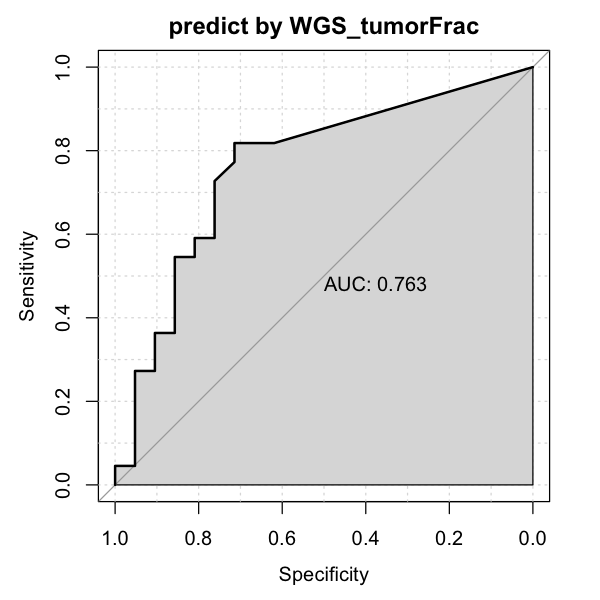

In [79]:
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, target_sens=NA){
    print(label_col %in% names(df))
    print(score_col %in% names(df))
    print(sum(!is.na(df[[score_col]])))
    df = df %>% rename("label"={{label_col}}, "score"={{score_col}}) %>% mutate("label"=as.character(label))
    print(glue("number of NA labels: {sum(is.na(df$label))}"))
    print(sprintf("case/control: %s / %s", sum(df$label=="TRUE"), sum(df$label=="FALSE")))
    
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(label=="TRUE", score >= thresh))
      FN = nrow(df %>% filter(label=="TRUE", score < thresh))
      TN = nrow(df %>% filter(label=="FALSE", score < thresh))
      FP = nrow(df %>% filter(label=="FALSE", score >= thresh))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    
    pROC_obj <- roc_(data=df, response="label", 
                predictor="score", smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE, main=title)
    }
    print(coords(pROC_obj, x="best"))
    
    if (!is.na(target_sens)){
        print(sprintf("target sens %s", target_sens))
        print(coords(pROC_obj, x=target_sens, input="sensitivity", 
                     ret=c("threshold","specificity", "sensitivity")))
        }
    print(paste0("AUC: ", auc(pROC_obj)))
}
# for ESMO abstract
get_sens_spec(df_urine_pre, "disease.positive", "wgsTumorfrac_ichorCNA", target_sens=1.0, title="predict by WGS_tumorFrac")

In [51]:
## selection table for WES+
# check patient treatment and expected followup samples with MCC
source("~/Desktop/puffin/R/helper_functions.R")
unique(df_lpwgs_all$SampleType)
unique(df_lpwgs_all$StudyVisit)

df_urine_post = df_lpwgs_all %>% filter(SampleType == "Urine", 
                                        StudyVisit!="Pre-Repeat TURBT")
nrow(df_urine_post)
df_pbmc_all = df_wes_qc.all %>% filter(SampleType %in% c("PBMC", "Buffy Coat", "Buffy_Coat"))
nrow(df_pbmc_all)
df_preurine_summary = standardize_names(df_lpwgs_all, "samples") %>% filter(SampleType=="Urine", StudyVisit=="Pre-Repeat TURBT")

# did we do lpwgs for these batch 1 samples? lpwgs data missing
ss = df_wes_qc1.urine_pbmc %>% filter(Specimen_type=="Supernatant")

df_preurine_summary = df_preurine_summary %>%
                                left_join(df_clin %>% select(PatientID, Sex, Index.Stage, Repeat.Stage, disease.positive), by="PatientID") %>%
                                mutate(has.germ = PatientID %in% df_pbmc_all$PatientID,
                                       n.followup.urines = (lapply(PatientID, function(x) sum(df_urine_post$PatientID == x))),
                                       WES.completed=SampleID.short %in% ss$SampleID)
                                                                                         
df_concord = get_concordance_stats(variant.data = all.snv, ref_sample_type = "IndexTURBT_Tissue", 
                                        df_samples = df_wes_qc.all)

df_preurine_summary = df_preurine_summary %>% left_join(df_concord %>% filter(StudyVisit=="IndexTURBT"), by="PatientID") %>%
                                              left_join(df_concord %>% filter(StudyVisit=="RepeatTURBT"), by="PatientID",
                                                           suffix=c(".index",".repeat")) %>%
                                              left_join(df_concord %>% filter(StudyVisit=="Pre-Repeat TURBT") %>% 
                                                                        select(PatientID,n_sample_vars,n_concord_vars), by="PatientID") %>%
                                              left_join(df_qc_all, by="SampleID.short", suffix=c(".",".qc")) %>%
                                              left_join(df_wes_qc2.all %>% select(SampleID.short, library_yield_ug), by="SampleID.short", suffix=c(".",".ngsqc"))
df_preurine_summary$MRD.completed = (df_preurine_summary$SampleID.short.x %in% mrd.table$SampleID.short)
stopifnot(all(!duplicated(df_preurine_summary$SampleID.short.x)))      
                                                            
write.csv(df_preurine_summary %>% mutate(across(everything(),as.character)) %>%
                                  relocate(PatientID., SampleID.short.x, SampleType.x, StudyVisit.x, DNAYield, library_yield_ug, 
                                           wgsTumorfrac_ichorCNA, wgsTumorfrac_EM, cnbScore, 
                                           Sex, Index.Stage, Repeat.Stage, disease.positive, has.germ, n.followup.urines, WES.completed, MRD.completed, 
                                           n_sample_vars.index, n_sample_vars.repeat, n_concord_vars.repeat, pct.concord.repeat),
          "./prerepeat_urine_wes_selection_table_05192023.csv", row.names=F) # refine in excel                                              

[1] "Tissue" "Urine"

[1] "IndexTURBT"       "RepeatTURBT"      "Post TURBT"       "Surveillance 1"  
[5] "Pre-Repeat TURBT" "Follow Up 1"

[1] 41

[1] 46

[1] "Pre-Repeat TURBT" "IndexTURBT"       "RepeatTURBT"     
[1] "PBMC"   "Urine"  "Tissue"
[1] "WARN: No ref. sample for: NMIBC006"
[1] "WARN: No ref. sample for: NMIBC018"
[1] "WARN: No ref. sample for: NMIBC001"
[1] "WARN: No ref. sample for: NMIBC011"
[1] "WARN: No ref. sample for: 174947"
[1] "WARN: No ref. sample for: 173281"
[1] "reference sample: IndexTURBT_Tissue"
[1] "median number reference variants: 154"
[1] "min: 0"
[1] "max: 1392"
[1] "sd: 303.474386873707"
[1] "MRD sample: Pre-Repeat TURBT_Urine" "MRD sample: RepeatTURBT_Tissue"    
[1] "median number MRD variants: 42.5"
[1] "min: 0"
[1] "max: 1113"
[1] "sd: 203.173380293514"
